# SBA Loan Default Analaysis  and Model

As part of this exercise we will review and understand SBA data for loan disbursed and try to predict the probability of default of PIF based on the key traits available in the data.

For this we are planning to explore the data and try to zero down on the features of interest and build learning models that can help predict the defaulters with more accuracy and also balance on the wrong classification of False Positive, i.e. Classification of HIGH RISK profile as low_risk .

## Install the dependent libraries in the order.

In [1]:
#!pip install geopandas
#!pip install -U scikit-learn

In [2]:
#Import the libraries of importance some will be repeated but that should be okay
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize_scalar
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score

import pandas as pd
import geopandas as gpd
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import os
import math
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    recall_score, precision_score, f1_score, accuracy_score
)
from sklearn.model_selection import TunedThresholdClassifierCV # Import the necessary class
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder

np.set_printoptions(precision=6, suppress=True)

pd.set_option('display.max_columns', None)

## Load the SBA data attached to the data frame 

In [3]:
# Load the data and get the default datatypes assigned to the values. 
# Define date columns
date_columns = ['ApprovalDate', 'ChgOffDate', 'DisbursementDate']
# Read the dataset
file_path = "SBAnational.csv"
df = pd.read_csv(file_path, header=0,dtype={'ApprovalFY': str,'Zip': str}, parse_dates=date_columns).set_index('LoanNr_ChkDgt')
print('1',df.shape[0])

1 899164


### Load the 3 digit ZIP Codes data file downloaded from USPS website.

The goal is to map the 3 digit zipcodes to the cities as to understand the geography of the business

In [4]:
# Read the PDF file from the USPS downloads.

import pdfplumber

# Open the PDF file
file_path = 'L002 3-Digit ZIP Code Prefix Matrix.pdf'

# Initialize a list to store the rows
zips = []

# Extract text from the PDF
with pdfplumber.open(file_path) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        
        # Extract lines from text
        lines = text.split("\n")
        
        for line in lines:
            # Skip headers and irrelevant lines
            if line.strip() and line[0:3].isdigit():
                # Split line by spaces or a fixed-width format
                parts = line.split()
                if len(parts) >= 2:
                    zip_prefix = parts[0]  # 3-digit ZIP prefix
                    destination = " ".join(parts[1:])  # Combine remaining parts as destination
                    zips.append([zip_prefix, destination])

# Create a pandas DataFrame
df1 = pd.DataFrame(zips, columns=["3-Digit ZIP Prefix", "Destination"])

df1['3-Digit ZIP Prefix'] = df1['3-Digit ZIP Prefix'].str[:3]
df1['final_destination'] = df1.apply(
    lambda row: row['Destination'].split(row['3-Digit ZIP Prefix'])[0].strip()
    if row['3-Digit ZIP Prefix'] in row['Destination'] else row['Destination'],
    axis=1
)
# Now split the values in the final_destination to city and state. 

df1['state'] = df1['final_destination'].str[-2:]
df1['city']= df1['final_destination'].str[:-2]
df1.drop(columns=['Destination','final_destination'], inplace=True)
df1.rename(columns = {'3-Digit ZIP Prefix':'3_ZIP'},inplace= True)

# Data Cleanup

## Data Cleaning
1. **City and State Mapping**:  
   - Filled missing `City` and `State` fields using the first three digits of ZIP codes.  
   - Mapped with external data (`L002 3-Digit ZIP Code Prefix Matrix.pdf`) for accurate geographic information.  

2. **ZIP Code Standardization**:  
   - Standardized ZIP codes by prefixing with `0` if the length was 4.

3. **Approval Fiscal Year (ApprovalFY)**:  
   - Removed alphabetic characters.  
   - Converted the column to integers for consistency.

4. **Standardized Numeric Columns**:  
   - Removed dollar signs and commas from columns like `BalanceGross`, `DisbursementGross`, `ChgOffPrinGr`, `GrAppv`, and `SBA_Appv`.  
   - Converted them to numeric format.

5. **LowDoc Cleanup**:  
   - Errors in the `LowDoc` column (`Y` or `N`) were corrected.  
   - Flagged loans below $150,000 as "Low Docs".

6. **Term Adjustment**:  
   - Updated terms below 6 months to a minimum of 6 months.

7. **MIS_Status Conversion**:  
   - Converted `MIS_Status` to binary (`1` for defaulted, `0` for paid in full).

8. **Handling Missing Values**:  
   - Dropped records with missing values in `BankState`, `DisbursementDate`, `State`, and `City`.  
   - Filled missing values in `NewExists` with `0` (undefined).


In [5]:

# Column Approval FY
#ApprovalFY have characters in the data so we are replacing alphabetic values to empty string
df['ApprovalFY'] = df['ApprovalFY'].str.replace(r'[^0-9]', ' ', regex=True).astype('Int16')
print('2',df.shape[0])
# Column ZIP, City and States

# So we have the length from 1 to 5 which is odd. We have to identfiy the zipcodes where the value is 4 to prefix
# with 0 to make it a five digit zipcode.
df['Zip'] = df['Zip'].apply(lambda x : '0'+ x if len(x)==4 else x)
df['zip_length'] = df['Zip'].apply(len)

# Now load the zipcode mapping file from the USPS and map the cities and states in to the bad zipcodes and 
# correct zipcodes i.e. length 4-5 to cities and state from the USPS. 
# Download the zip details from USPS -  https://postalpro.usps.com/ZIP_Locale_Detail
cols_dtype = {'AREA NAME' : 'string',
              'AREA CODE':'string', 
              'DISTRICT NAME' : 'string',
              'DISTRICT NO':'string',
              'DELIVERY ZIPCODE':'string',
              'LOCALE NAME':'string',
              'PHYSICAL DELV ADDR':'string',
              'PHYSICAL CITY':'string',
              'PHYSICAL STATE':'string',
              'PHYSICAL ZIP':'string',
              'PHYSICAL ZIP 4':'string'}

# Read the ZIP information from excel downloaded from the USPS Attached with the project submission
zip_data = pd.read_excel('ZIP_Locale_Detail.xls', sheet_name='ZIP_DETAIL', dtype=cols_dtype)

df['City'] = df['City'].str.upper().str.strip()
df['State'] = df['State'].str.upper().str.strip()
print('3',df.shape[0])
# Step 2: Filter rows where zip_length <= 2 or Zip is missing
mask = (df['zip_length'] <= 2) | (df['Zip'].isnull())

# Step 3: Prepare a unique version of df2 for merging (dropping duplicates)
df2_unique = zip_data.drop_duplicates(subset=['LOCALE NAME', 'PHYSICAL STATE'], keep='first')

# Step 4: Perform the merge with left join to get the PHYSICAL ZIP
merged_df = df[mask].merge(df2_unique, left_on=['City', 'State'], right_on=['LOCALE NAME', 'PHYSICAL STATE'], how='left')

# Step 5: Create a mapping for Zip codes using the merged DataFrame
# Map the 'PHYSICAL ZIP' values to the rows that are missing or incorrect in the original df
zip_map = merged_df.set_index('City')['DELIVERY ZIPCODE'].to_dict()

# Step 6: Apply the map to update the Zip column for the matching rows
df.loc[mask, 'Zip'] = df.loc[mask, 'City'].map(zip_map).combine_first(df.loc[mask, 'Zip'])
print('4',df.shape[0])

# Update the city and state details for the 3 digit zipcodes to understand the correct information. 
# Also correct the city and state details for normal zipcodes as well. It has to be iterative to ensure
## That the cities are correctly mapped, so does the states instead of some bad data points to avoid any biases.

# So what we can do is to get the city and state information for all the zip_codes whose length is not  and replace the original columns
# Step 1: Filter rows where Zip length is not 3
mask_invalid_zip = df['Zip'].str.len() != 3

# Step 2: Prepare a unique version of zip_data for merging (dropping duplicates)
df3_unique = zip_data.drop_duplicates(subset=['DELIVERY ZIPCODE'], keep='first')

# Step 3: Perform the merge with left join to get City and State details
merged_df = df[mask_invalid_zip].merge(
    df3_unique,
    left_on='Zip',
    right_on='DELIVERY ZIPCODE',
    how='left'
)

# Step 4: Create mappings for City and State from the merged DataFrame
city_map = merged_df.set_index('Zip')['LOCALE NAME'].to_dict()
state_map = merged_df.set_index('Zip')['PHYSICAL STATE'].to_dict()

# Step 5: Update the City and State columns in the original DataFrame
df.loc[mask_invalid_zip, 'City'] = df.loc[mask_invalid_zip, 'Zip'].map(city_map).combine_first(df.loc[mask_invalid_zip, 'City'])
df.loc[mask_invalid_zip, 'State'] = df.loc[mask_invalid_zip, 'Zip'].map(state_map).combine_first(df.loc[mask_invalid_zip, 'State'])

print('5',df.shape[0])
# City, ZIP and State cleaned.

2 899164
3 899164
4 899164
5 899164


In [6]:
df['Zip'].str.len().unique() # Still we have ziipcodes with low lengths

array([5, 1, 3, 2])

---

## New Features
1. **SBA Portion Calculation**:  
   - Created a column `SBA_portion` as the percentage of the approved gross amount covered by SBA.

2. **Recession Indicator**:  
   - Flagged loans with maturity dates between 2007-12-01 and 2009-06-30 as during the recession.

3. **Real Estate Indicator**:  
   - Flagged loans with terms greater than 240 months as real estate-backed (`RealEstate` column).

4. **Franchise Flag**:  
   - Created a column `If_Franchise` to indicate loans linked to a franchise (`FranchiseCode` not equal to 0 or 1).

5. **Revolving Line of Credit**:  
   - Added `correct_RevLineCr` to flag revolving lines of credit based on predefined codes.

6. **Industry Consolidation**:  
   - Consolidated industries in the `NAICS` column into 7 major categories.  
   - Grouped less frequent ones into an "Other" category.

7. **DefaultRateBucket**:  
   - Categorized states into buckets based on default rates.

8. **CompanySize**:  
   - Categorized businesses based on the number of employees:  
     - `0`: No employees.  
     - `1`: Micro-businesses (1–5 employees).  
     - `2`: Small businesses (6–50 employees).  
     - `3`: Medium businesses (51–250 employees).  
     - `4`: Large businesses (more than 250 employees).

9. **Job Creation**:  
   - Grouped businesses by jobs created:  
     - `0`: Minimal (0–1 jobs).  
     - `1`: Small (2–10 jobs).  
     - `2`: Moderate (11–20 jobs).  
     - `3`: Significant (more than 20 jobs).

---

In [7]:
# NAICS Cleanup and industry Flags along with the economic Sector

# Let's Dive into NAICS ..
df['Industry'] = df['NAICS'].apply(lambda x : str(x)[:2] if x !=0 else '00')
print('6',df.shape[0])
def get_naics(x):
    x = int(x)
    if x == 0:
        return None
    elif 31 <= x <= 33:
        return str(31)
    elif 44 <= x <= 45:
        return str(44)
    elif 48 <= x <= 49:
        return str(48)
    else:
        return str(x)

df['Industry'] = df['NAICS'].apply(lambda x : str(x)[:2] if x !=0 else '00')

df['econ_sector'] = df['Industry'].apply(get_naics)
print('7',df.shape[0])
# Define the mapping of econ_sector values
econ_sector_mapping = {
    '00': 'Unknown Industry Category',
    '11': 'Agriculture, Forestry, Fishing and Hunting',
    '21': 'Mining, Quarrying, and Oil and Gas Extraction',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale Trade',
    '44': 'Retail Trade',
    '45': 'Retail Trade',
    '48': 'Transportation and Warehousing',
    '49': 'Transportation and Warehousing',
    '51': 'Information',
    '52': 'Finance and Insurance',
    '53': 'Real Estate and Rental and Leasing',
    '54': 'Professional, Scientific, and Technical Services',
    '55': 'Management of Companies and Enterprises',
    '56': 'Administrative and Support and Waste Management and Remediation Services',
    '61': 'Educational Services',
    '62': 'Health Care and Social Assistance',
    '71': 'Arts, Entertainment, and Recreation',
    '72': 'Accommodation and Food Services',
    '81': 'Other Services (except Public Administration)',
    '92': 'Public Administration'
}

# Get the new Industry based on the mode of the State to fill the missing industry values

# Group and count records
grouped_df = df[~(df['Industry'] == '00')].groupby(['State', 'Industry']).size().reset_index(name='Count')

# Identify the prominent industry (highest count) for each state
prominent_industries = grouped_df.loc[grouped_df.groupby('State')['Count'].idxmax()].reset_index().drop(columns=['Count','index'])

# Step 1: Precompute the prominent industry for each state
prominent_industry_map = prominent_industries.set_index('State')['Industry'].to_dict()
print('16',df.shape[0])
# Step 2: Apply the mapping to fill the '00' values in the Industry column
def fill_industry(row):
    if row['Industry'] == '00':  # Replace placeholder values
        return prominent_industry_map.get(row['State'], row['Industry'])  # Fallback to original if state not in map
    return row['Industry']  # Keep the original value if not '00'


# Fill the industries based on the mode of the states to ensure we can atleast categorize the industries

df['filled_industry'] = df.apply(fill_industry, axis=1)


# Create an Industry flag based on the total count of industry to identify the data classification

# # Step 1: Calculate the count of each industry
# industry_counts = df['filled_industry'].value_counts()

# # Step 2: Identify industries with less than 50,000 occurrences
# low_count_industries = industry_counts[industry_counts < 50000].index

# Step 3: Create a new flag for the 'filled_industry' column

df['IndustryFlag'] = df['filled_industry'].apply(lambda x: x if x in ('44','81','72','23','54','62') else 'Other')

#This is done to reduce the number of industry categories

# Step 4: Verify the transformation
print(df['IndustryFlag'].value_counts())


# Replace the numerical econ_sector values with their corresponding descriptions
df['econ_sector'] = df['filled_industry'].map(econ_sector_mapping)

# Correct the Dollar values and convert to numeric

# CHange all the columns to numeric columns to ensure better insights
print('8',df.shape[0])
dollar_cols = ['BalanceGross','DisbursementGross','ChgOffPrinGr','GrAppv','SBA_Appv']
for col in dollar_cols:
    
    df[col]= df[col].str.replace('$','',regex =False)
    df[col]= df[col].str.replace(',','',regex =False)
    df[col] = df[col].astype('float64').round().astype('Int64')

    
# Cleaning up the records where the MIS_Status is NA. We analyzed the data and the data showed lot of incorrect
# entries as the disbursement data is missing or is 0 while the ChgOffPrinGr amount is significant which shows the 
# default amount .
print('9',df.shape[0])
df = df.dropna(subset=['MIS_Status'])

# Now fix the Low Doc column with the incorrect values based on the case's article. THe values expected to be Y or N, with error in data entry
# as well.  As per the rule it suggest to have the Low Docs when the loan approval amount is less than $150,000

df['LowDoc_correct'] = (df['GrAppv'] < 150000).astype('Int8')  # Created a new column instead so we can decide 
# which one to keep. 

# Create the new feature for Term 
print('10',df.shape[0])
df['updated_term'] = df['Term'].apply(lambda x : 6 if x <=6 else x)

###Calculate the Maturity Date and Year to identify if the loan was active during the recession period of Great Recession

# Calculate maturity date
df['maturity_date'] = df.apply(lambda row: row['DisbursementDate'] + pd.DateOffset(months=row['updated_term']), axis=1)

# Extract year from maturity_date
df['maturity_year'] = df['maturity_date'].dt.year.astype('Int16')

# 
#New Variables
print('11',df.shape[0])
df['DisbursementYear'] = df['DisbursementDate'].dt.year.astype('Int16')

# Recession Calculation if the loan was active during the recession period of Dec 2007 to June 2009
target_start = pd.Timestamp('2007-12-01')
target_end = pd.Timestamp('2009-06-30')
df['recession'] = (
    (df['DisbursementDate'] <= target_end) &  # Disbursed before or during the target period
    (df['maturity_date'] >= target_start)     # Matured after or during the target period
).astype(int)  # Convert boolean to 1/0

#df['recession'] = df[df['DisbursementYear'].notnull()].apply(lambda x: 1 if (x['maturity_year'] >= 2007) & (x['DisbursementYear'] <= 2009) else 0, axis=1).astype('Int8')

df['RealEstate'] = df.apply(lambda x: 1 if x['updated_term'] >= 240 else 0, axis=1)

df['SBA_portion'] = (df['SBA_Appv'] / df['GrAppv']) * 100
print('12',df.shape[0])

# Fill the missing values in NewExists with 0 citing the information is missing if its new or existing.

df['NewExist'] = df['NewExist'].astype('Int8')
df['NewExist'] = df['NewExist'].fillna(0)
df =df[df['NewExist'] != 0]
print('13',df.shape[0])  

# Drop the records based on NewExists if it fits your theory of analysis

# Create a new fields to capture if its a Franchise or not a franchise.

df['If_Franchise']= ((df['FranchiseCode'] != 0) & (df['FranchiseCode'] !=1)).astype('Int8')
print('14',df.shape[0])

# We do not need to fit in the urban rural information as none of the values are missing and those are classified as 0


# Here if we notice that N and 0 and - would mean same or similar while 1 , Q , `, Y and T would mean similar, caue Y and T are
# very close to each other on QWERTY keyboard.

def update_rev_line(x):
    if x in ('1','`','2','3','Q','W','Y','T','U','R','5','4'):
        return 1
    else:
        return 0
df['correct_RevLineCr'] = df['RevLineCr'].apply(update_rev_line)
print('15',df.shape[0])



# CHange the MIS_STATUS Value for paid in full vs defaulted. PIF is 1 else 0
df['MIS_Status'] = df['MIS_Status'].apply(lambda x : 0 if x == 'P I F' else 1 ).astype('Int8')

df['Zip2'] = df['Zip'].str.slice(0,2).astype('string')


# Drop any data which does not have Bank State, No disbursement, State or City information
df = df.dropna(subset=['BankState','DisbursementDate','State','City'])
df.head()

6 899164
7 899164
16 899164
Other    283558
44       206602
81        96248
72        88438
23        85312
54        83640
62        55366
Name: IndustryFlag, dtype: int64
8 899164
9 899164
10 897167
11 897167
12 897167
13 896005
14 896005
15 896005


Name                       City State  \
LoanNr_ChkDgt                                                                   
1000014003                    ABC HOBBYCRAFT             DIAMOND VALLEY    IN   
1000024006       LANDMARK BAR & GRILLE (THE)                     GOSHEN    IN   
1000034009             WHITLOCK DDS, TODD M.                 WOODBRIDGE    IN   
1000044001     BIG BUCKS PAWN & JEWELRY, LLC               BROKEN ARROW    OK   
1000054004       ANASTASIA CONFECTIONS, INC.  GORE STREET CARRIER ANNEX    FL   

                 Zip                           Bank BankState   NAICS  \
LoanNr_ChkDgt                                                           
1000014003     47711               FIFTH THIRD BANK        OH  451120   
1000024006     46526                1ST SOURCE BANK        IN  722410   
1000034009     47401        GRANT COUNTY STATE BANK        IN  621210   
1000044001     74012  1ST NATL BK & TR CO OF BROKEN        OK       0   
1000054004     32801        FLORIDA BUS. DEVEL CORP        FL       0   

              ApprovalDate  ApprovalFY  Term  NoEmp  NewExist  CreateJob  \
LoanNr_ChkDgt                                                              
1000014003      1997-02-28        1997    84      4         2          0   
1000024006      1997-02-28        1997    60      2         2          0   
1000034009      1997-02-28        1997   180      7         1          0   
1000044001      1997-02-28        1997    60      2         1          0   
1000054004      1997-02-28        1997   240     14         1          7   

               RetainedJob  FranchiseCode  UrbanRural RevLineCr LowDoc  \
LoanNr_ChkDgt                                                            
1000014003               0              1           0         N      Y   
1000024006               0              1           0         N      Y   
1000034009               0              1           0         N      N   
1000044001               0              1           0         N      Y   
1000054004               7              1           0         N      N   

              ChgOffDate DisbursementDate  DisbursementGross  BalanceGross  \
LoanNr_ChkDgt                                                                
1000014003           NaT       1999-02-28              60000             0   
1000024006           NaT       1997-05-31              40000             0   
1000034009           NaT       1997-12-31             287000             0   
1000044001           NaT       1997-06-30              35000             0   
1000054004           NaT       1997-05-14             229000             0   

               MIS_Status  ChgOffPrinGr  GrAppv  SBA_Appv  zip_length  \
LoanNr_ChkDgt                                                           
1000014003              0             0   60000     48000           5   
1000024006              0             0   40000     32000           5   
1000034009              0             0  287000    215250           5   
1000044001              0             0   35000     28000           5   
1000054004              0             0  229000    229000           5   

              Industry                        econ_sector filled_industry  \
LoanNr_ChkDgt                                                               
1000014003          45                       Retail Trade              45   
1000024006          72    Accommodation and Food Services              72   
1000034009          62  Health Care and Social Assistance              62   
1000044001          00                       Retail Trade              44   
1000054004          00                       Retail Trade              44   

              IndustryFlag  LowDoc_correct  updated_term maturity_date  \
LoanNr_ChkDgt                                                            
1000014003           Other               1            84    2006-02-28   
1000024006              72               1            60    2002-05-31   
1000034009   

In [8]:
# Lets check the missing ZIP Codes to understand what went wrong there. 
'''Around more than 50% of the loans are defaulted if the values for CITY and State are not correct as the zip
code information is missing. This could be a clue to identify if the business shared wrong details. 
Let's generate a flag for such columns where the zipcode is less than or equal to 3 '''

print(df[df['Zip'].str.len()<=3]['MIS_Status'].value_counts())
df['bad_geo_flag'] =(df['Zip'].str.len() <=3).astype('category')
df = df.drop(df[df['bad_geo_flag']==1].index)  # Dropped the bad geography records from the data set
df['bad_geo_flag'].unique()
#df[df['Zip'].str.len()<=3]

# Drop the records where the ZIP Code is less than 3 and drop those rows.

0    57
1    50
Name: MIS_Status, dtype: Int64


[False, True]
Categories (2, bool): [False, True]

In [9]:
# Calculate the Default Rate at the State Level. 

counts = df.shape[0]
# 3. Calculate default rate for each state
default_rate_df = (
    df.groupby('State')['MIS_Status']
    .agg(total_loans='count', defaults='sum')
    .assign(default_rate=lambda x: (x['defaults'] / x['total_loans'])*100)
    .reset_index()
)

default_rate_df['loan_percentages'] = (default_rate_df['total_loans']/counts)*100
#print(default_rate_df.sort_values(by='default_rate', ascending = False))


def return_DefaultRateBucket(x):
    if x in ('FL'):
        return 5
    elif x in ('GA','DC','NV','IL','MI','TN','AZ','SC','NJ'):
        return 4
    elif x in ('NY','MD','KY','NC','TX','VA','CA','LA','DE','CO','UT','IN','AR','AL','OH','WV','MS','OK'):
        return 3
    elif x in ('OR','MO','HI','PA','ID','CT','WA','KS','MA','WI','MN','IA','RI','AK','NE','NM','NH','ME'):
        return 2
    else: return 1

df['DefaultRateBucket'] = df['State'].apply(return_DefaultRateBucket)
#df['DefaultRateBucket']
# Calculate the defauult rate of the loans in the state and bucket them in a category based on default percentages.
# The percentages are identifies from the default_rate_df. Check the Diagram as well

## Plot the geographical information of loan defaults 

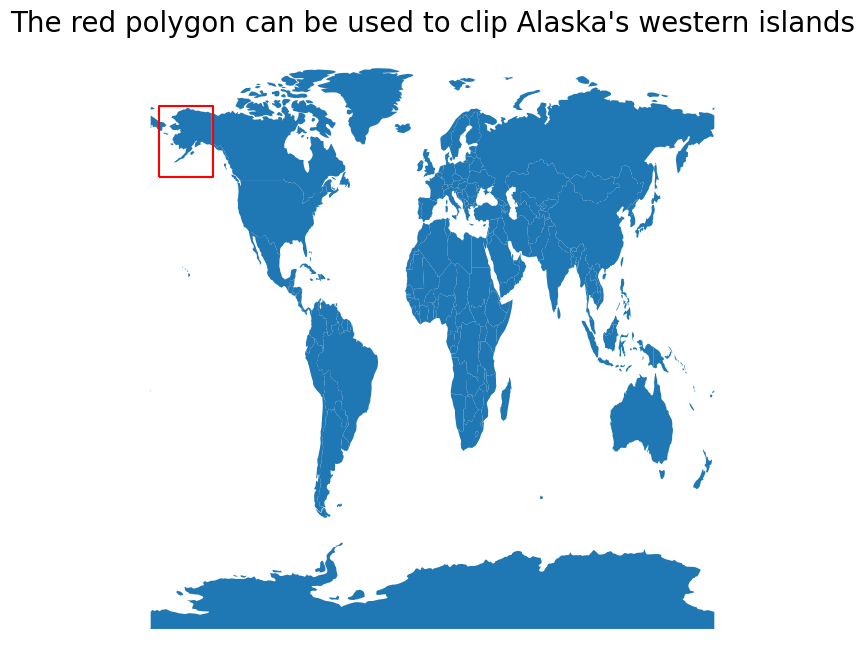

/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


0.0 27.47767530376226


/var/folders/t6/62p5k1w921vdm0907xrsq0ph0000gn/T/ipykernel_26933/1410943493.py:132: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


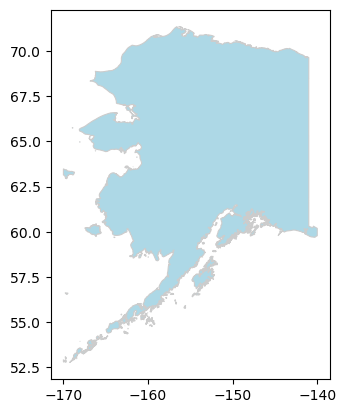

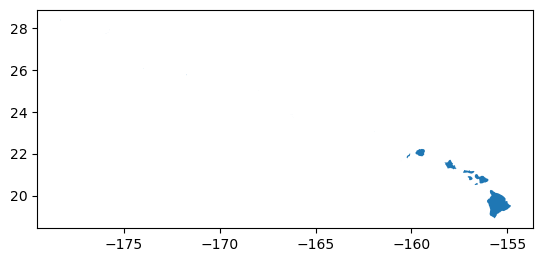

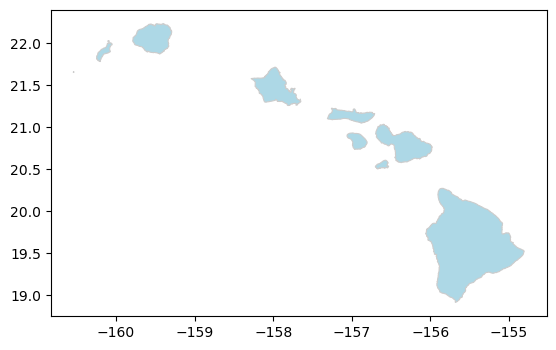

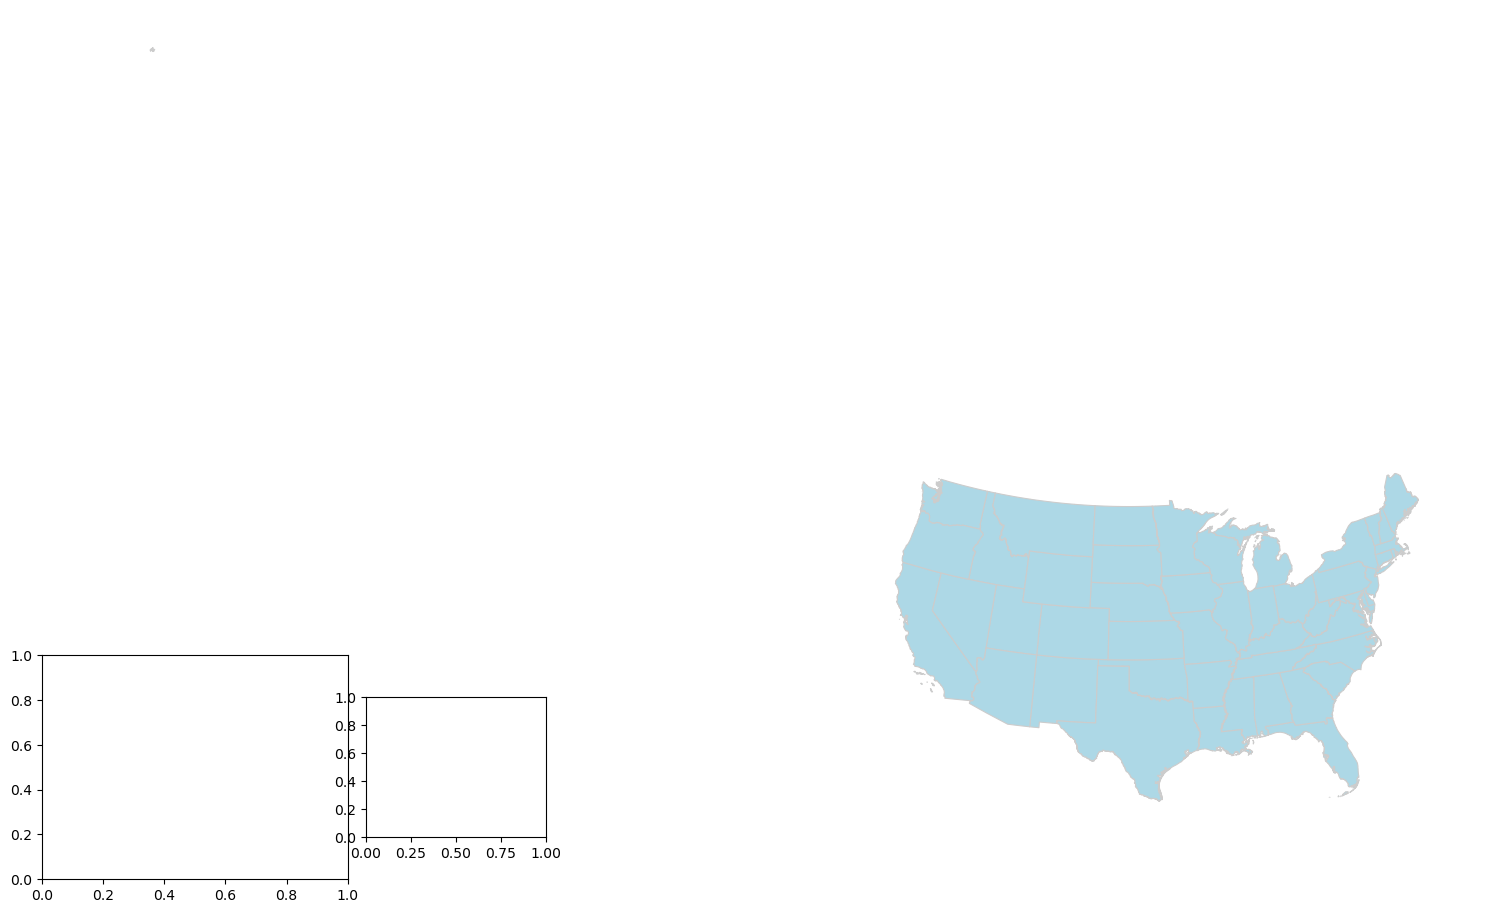

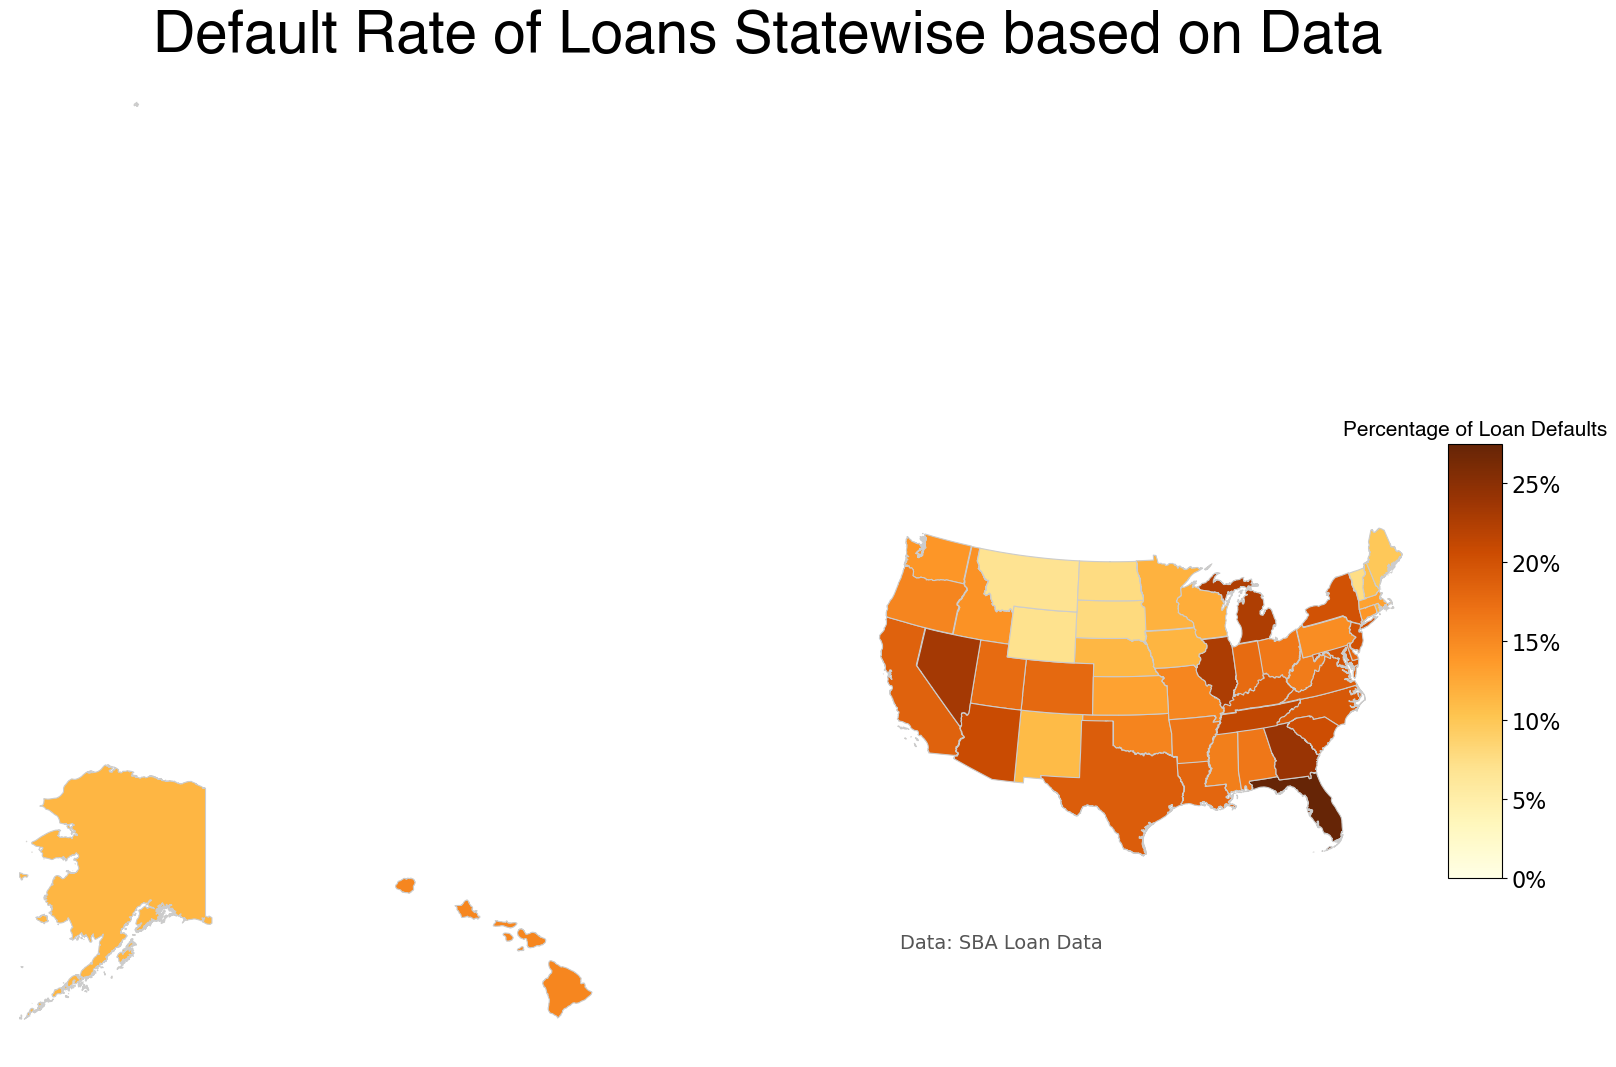

In [10]:
# Lets plot the geographical data here . 

gdf = gpd.read_file('cb_2018_us_state_500k')


# Merge the default rate data with the gdf data .

gdf = gdf.merge(default_rate_df,left_on='STUSPS',right_on='State')
alaska_gdf = gdf[gdf.State=='AK']
hawaii_gdf = gdf[gdf.State=='HI']

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
polygon = Polygon([(-175,50),(-175,72),(-140, 72),(-140,50)])
# polygon=hipolygon
poly_gdf = gpd.GeoDataFrame( geometry=[polygon], crs=world.crs)
fig, ax1 = plt.subplots(1, figsize=(8, 18))
world.plot(ax=ax1)
poly_gdf.boundary.plot(ax = ax1, color="red")
ax1.set_title("The red polygon can be used to clip Alaska's western islands", fontsize=20)
ax1.set_axis_off()
plt.show()

polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
# apply1(alaska_gdf,0,36)
alaska_gdf.clip(polygon).plot( color='lightblue', linewidth=0.8, edgecolor='0.8')
# alaska_gdf.clip(polygon).plot(column=variable, cmap = colormap, linewidth=0.8,ax=akax, edgecolor='0.8')
hawaii_gdf.plot()
hipolygon = Polygon([(-161,0),(-161,90),(-120,90),(-120,0)])
hawaii_gdf.clip(hipolygon).plot(color='lightblue', linewidth=0.8, edgecolor='0.8')

# Create a "copy" of gdf for re-projecting
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for with Matplotlib for main map
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box from the main map
ax.axis('off')


# create map of all states except AK and HI in the main map axis
visframe[~visframe.State.isin(['HI','AK'])].plot(color='lightblue', linewidth=0.8, ax=ax, edgecolor='0.8')


# Add Alaska Axis (x, y, width, height)
akax = fig.add_axes([0.1, 0.17, 0.17, 0.16])   


# Add Hawaii Axis(x, y, width, height)
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   

# We'll later map Alaska in "akax" and Hawaii in "hiax"

# Apply this the gdf to ensure that all states are assigned colors by the same function
def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

# **************************
# set the value column that will be visualised
variable = 'default_rate'

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf.default_rate.min(), gdf.default_rate.max() #math.ceil(gdf.pct_food_insecure.max())
print(vmin,vmax)
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "YlOrBr"
gdf = makeColorColumn(gdf,variable,vmin,vmax)

# create "visframe" as a re-projected gdf using EPSG 2163
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis('off')

# set the font for the visualization to Helvetica
hfont = {'fontname':'Helvetica'}

# add a title and annotation
ax.set_title('Default Rate of Loans Statewise based on Data', **hfont, fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Percentage of Loan Defaults', **hfont, fontdict={'fontsize': '15', 'fontweight' : '0'})
# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
# reformat tick labels on legend

# reformat tick labels on legend
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)
ax.annotate("Data: SBA Loan Data ", xy=(0.50, .085), xycoords='figure fraction', fontsize=14, color='#555555')

# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for row in visframe.itertuples():
    if row.State not in ['AK','HI']:
        vf = visframe[visframe.State==row.State]
        c = gdf[gdf.State==row.State][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

# add Alaska
akax = fig.add_axes([0.05, 0.1, 0.2, 0.2])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.State=='AK']
alaska_gdf.clip(polygon).plot(color=gdf[gdf.State=='AK'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([0.3, 0.1, 0.12, 0.12])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.State=='HI']
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')

plt.show()

In [11]:
# New Attribute Creation-
# Classify the companies based on the number of employees. 
def classify_company_size(no_emp):
    if no_emp ==0:
        return 0
    elif 1 <= no_emp <=5:
        return 1
    elif 6 <= no_emp <= 50:
        return 2
    elif 51 <= no_emp <= 250:
        return 3
    else:
        return 4

# Apply the function to classify company size
df['CompanySize'] = df['NoEmp'].apply(classify_company_size)

In [12]:
# Create a flag from jobs created flag to ensure it can be properly bucketed

def createjob_flags(x):
    if x == 0 or x == 1 :
        return 0
    elif 1 < x <=10:
        return 1
    elif 11 < x <=20:
        return 2
    else:
        return 3
    
df['JOB_CREATED'] = df['CreateJob'].apply(createjob_flags)

In [13]:
# Save the DataFrame to a CSV file in the specified directory
allvarcleaneddata = df.copy()
allvarcleaneddata.to_csv('FinalData/allvarcleaneddata.csv')

# EDA 

In [14]:
target_col_list = ['City','State','Zip','Zip2','BankState','ApprovalDate','ApprovalFY','NoEmp','NewExist','CreateJob',
 'RetainedJob','UrbanRural','ChgOffDate','DisbursementDate',
 'DisbursementGross','BalanceGross','MIS_Status','ChgOffPrinGr','GrAppv','SBA_Appv','econ_sector',
 'LowDoc_correct','updated_term','maturity_date','maturity_year','DisbursementYear','recession',
 'RealEstate','SBA_portion','If_Franchise','correct_RevLineCr','filled_industry','bad_geo_flag','CompanySize','JOB_CREATED','DefaultRateBucket','IndustryFlag']

data = df[target_col_list].copy()

data.head()

City State    Zip Zip2 BankState  \
LoanNr_ChkDgt                                                          
1000014003                DIAMOND VALLEY    IN  47711   47        OH   
1000024006                        GOSHEN    IN  46526   46        IN   
1000034009                    WOODBRIDGE    IN  47401   47        IN   
1000044001                  BROKEN ARROW    OK  74012   74        OK   
1000054004     GORE STREET CARRIER ANNEX    FL  32801   32        FL   

              ApprovalDate  ApprovalFY  NoEmp  NewExist  CreateJob  \
LoanNr_ChkDgt                                                        
1000014003      1997-02-28        1997      4         2          0   
1000024006      1997-02-28        1997      2         2          0   
1000034009      1997-02-28        1997      7         1          0   
1000044001      1997-02-28        1997      2         1          0   
1000054004      1997-02-28        1997     14         1          7   

               RetainedJob  UrbanRural ChgOffDate DisbursementDate  \
LoanNr_ChkDgt                                                        
1000014003               0           0        NaT       1999-02-28   
1000024006               0           0        NaT       1997-05-31   
1000034009               0           0        NaT       1997-12-31   
1000044001               0           0        NaT       1997-06-30   
1000054004               7           0        NaT       1997-05-14   

               DisbursementGross  BalanceGross  MIS_Status  ChgOffPrinGr  \
LoanNr_ChkDgt                                                              
1000014003                 60000             0           0             0   
1000024006                 40000             0           0             0   
1000034009                287000             0           0             0   
1000044001                 35000             0           0             0   
1000054004                229000             0           0             0   

               GrAppv  SBA_Appv                        econ_sector  \
LoanNr_ChkDgt                                                        
1000014003      60000     48000                       Retail Trade   
1000024006      40000     32000    Accommodation and Food Services   
1000034009     287000    215250  Health Care and Social Assistance   
1000044001      35000     28000                       Retail Trade   
1000054004     229000    229000                       Retail Trade   

               LowDoc_correct  updated_term maturity_date  maturity_year  \
LoanNr_ChkDgt                                                              
1000014003                  1            84    2006-02-28           2006   
1000024006                  1            60    2002-05-31           2002   
1000034009                  0           180    2012-12-31           2012   
1000044001                  1            60    2002-06-30           2002   
1000054004                  0           240    2017-05-14           2017   

               DisbursementYear  recession  RealEstate  SBA_portion  \
LoanNr_ChkDgt                                                         
1000014003                 1999          0           0         80.0   
1000024006                 1997          0           0         80.0   
1000034009                 1997          1           0         75.0   
1000044001                 1997          0           0         80.0   
1000054004                 1997          1           1        100.0   

               If_Franchise  correct_RevLineCr filled_industry bad_geo_flag  \
LoanNr_ChkDgt                                                                 
1000014003                0                  0              45        False   
1000024006                0                  0              72        False   
1000034009                0                  0              62        False   
1000044001                0                  0              44        False   
1000054004          

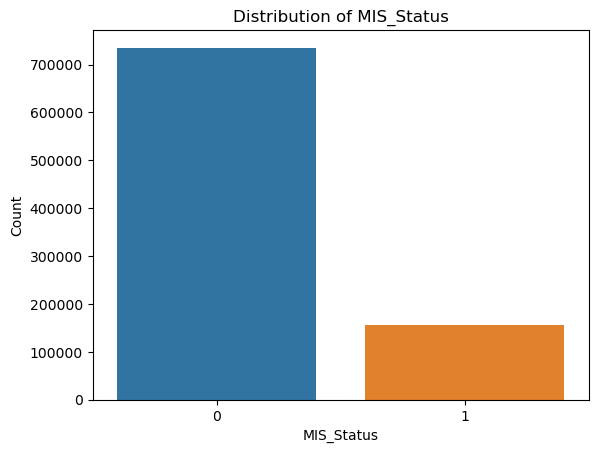

count    892320.0
mean     0.176039
std      0.380853
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           1.0
Name: MIS_Status, dtype: Float64


In [15]:
##17.6% of the data belong to the default class which indicates the data is imbalanced
# Plot the distribution of the target variable
sns.countplot(x='MIS_Status', data=data)
plt.title('Distribution of MIS_Status')
plt.xlabel('MIS_Status')
plt.ylabel('Count')
plt.show()

# Descriptive statistics for 'MIS_Status'
print(data['MIS_Status'].describe())

In [16]:
# Define the column groups
categorical_cols = ['State','BankState', 'econ_sector', 'filled_industry','NewExist',
                    'RealEstate','UrbanRural','correct_RevLineCr','bad_geo_flag','CompanySize','JOB_CREATED','DefaultRateBucket','IndustryFlag']
numerical_cols = ['NoEmp', 'CreateJob', 'RetainedJob', 
                  'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
                  'updated_term', 'SBA_portion']
binary_cols = ['MIS_Status', 'LowDoc_correct', 'recession', 'If_Franchise']


In [17]:
# 2. Descriptive statistics for predictors
# For categorical predictors, check value counts
categorical_summary = data[categorical_cols].describe(include=['object'])

# For numerical predictors, get summary statistics
numerical_summary = data[numerical_cols].describe()

# Print summary statistics
print("Categorical Predictors Summary:\n", categorical_summary)
print("Numerical Predictors Summary:\n", numerical_summary)

Categorical Predictors Summary:
          State BankState   econ_sector filled_industry IndustryFlag
count   892320    892320        892320          892320       892320
unique      52        56            20              24            7
top         CA        CA  Retail Trade              44        Other
freq    129889    117723        247452          205214       281397
Numerical Predictors Summary:
                NoEmp      CreateJob    RetainedJob  DisbursementGross  \
count  892320.000000  892320.000000  892320.000000           892320.0   
mean       11.401163       8.388360      10.758095      201701.327324   
std        73.776226     235.921474     236.381852      287876.767279   
min         0.000000       0.000000       0.000000             4000.0   
25%         2.000000       0.000000       0.000000            42500.0   
50%         4.000000       0.000000       1.000000           100000.0   
75%        10.000000       1.000000       4.000000           239000.0   
max      999

# Loan Data Analysis: Insights and Observations

## 1. Loan Distribution by State
- States like **California**, **Texas**, **New York**, and **Florida** lead in the amount of loan disbursed.
- This aligns with their thriving startup and business ecosystems, making them prominent hubs for loan procurement.

## 2. Loan Distribution by Industry
- **Retail** dominates the industry sector, likely due to the prevalence of small businesses such as:
  - Mom-and-pop shops
  - Retail stores
  - Boutique shops
- Other significant contributors include:
  - **Service Sector**
  - **Food Industry**
  - **Construction Businesses**

## 3. Loan Status: New vs. Existing Businesses
- Most loans were procured by **existing businesses**, which are perceived as lower risk.
- **New ventures**:
  - Seen as higher risk, leading to fewer loans in this category.
  - Likely underrepresented due to stricter lending criteria.

## 4. Revolving Line of Credit
- Most loans **did not have a revolving line of credit**:
  - Valid as revolving lines of credit generally have higher interest rates and pose higher risks.

## 5. Company Size
- Company sizes range broadly, from **0 to 3000+ employees**.
- However, **90% of the data falls between 0-100 employees**:
  - Companies have been categorized based on employee count for clearer analysis.

## 6. State Default Rates
- Certain states exhibit **high default rates** compared to others.
- These states have been grouped into **default rate buckets** for better categorization and analysis.

---

# Visualizations for the Observations

Below are the visual representations of these insights.

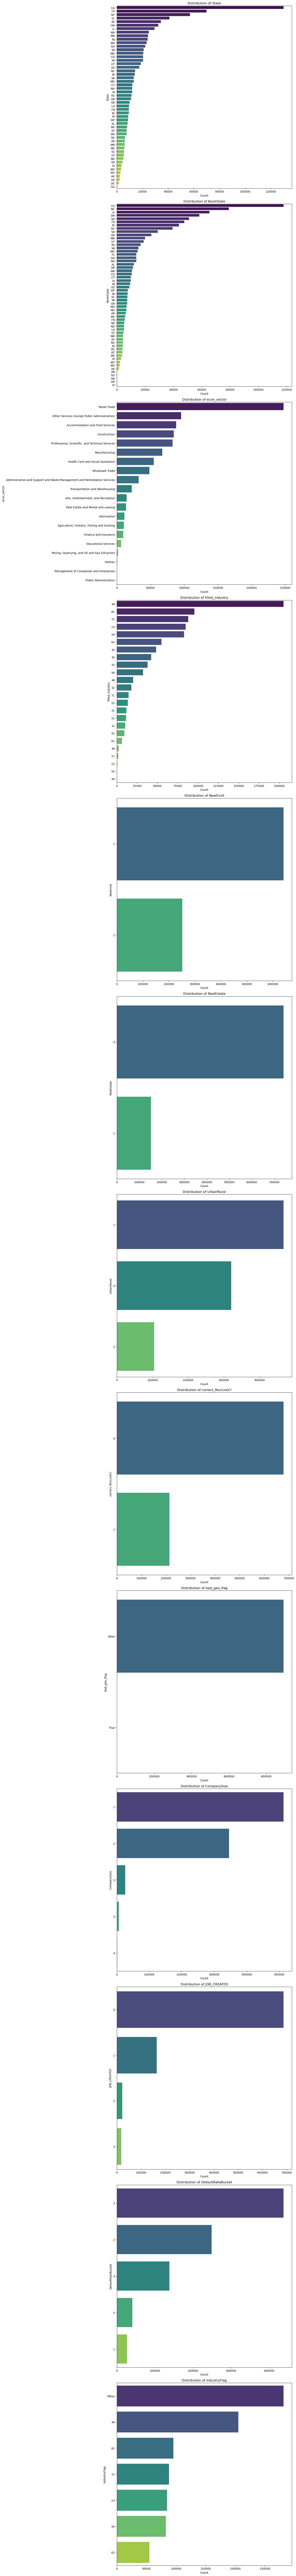

In [18]:
# Plot categorical columns
plt.figure(figsize=(15, 10* len(categorical_cols)))
for i, col in enumerate(categorical_cols, start=1):
    plt.subplot(len(categorical_cols), 1, i)
    sns.countplot(data=data, y=col, order=df[col].value_counts().index, palette='viridis')
    plt.title(f"Distribution of {col}")
    plt.xlabel("Count")
    plt.yticks(rotation=0)
    plt.ylabel(col)
plt.tight_layout()
plt.show()


## Visualizing categorical predictors vs MIS_Status using bar plots

# Data Exploration and Analysis

## Observations on Numerical Predictors
1. **High Variance and Outliers**:  
   - Features like `BalanceGross`, `ChgOffPrinGr`, `GrAppv`, and `SBA_Appv` exhibit very high variance.  
   - Minimum values are 0, but maximum values include extreme outliers (e.g., `BalanceGross` reaches up to 996,262).  
   - These features are highly skewed, with many low or zero values and a few extreme high values.

2. **Features with Zeros**:  
   - Variables like `NoEmp` (number of employees), `CreateJob`, and `RetainedJob` have many zeros.  
   - For instance, the mean of `CreateJob` is 8.39, but the 25th percentile is 0, showing that many businesses did not create jobs.

3. **Correlations**:  
   - Strong correlations observed between `GrAppv` and `SBA_Appv` (likely reflecting their similar ranges).  

## Observations on Categorical Features
1. **Uneven Distributions**:  
   - Features like `State`, `BankState`, `econ_sector`, and `IndustryFlag` are unevenly distributed.  
   - Example: `State` has 51 unique categories, but some values (e.g., `CA`) dominate in frequency.

## Disbursement Analysis
1. **Range and Skewness**:  
   - `DisbursementGross` ranges from 0 to a maximum of 11,446,325.  
   - A large portion of values are 0 or very low (e.g., 25th percentile is 0), suggesting many businesses either did not receive loans or received very small amounts.





## Visualizing numerical predictors vs MIS_Status using boxplots

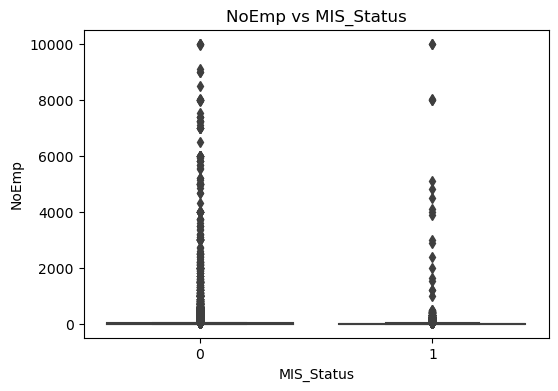

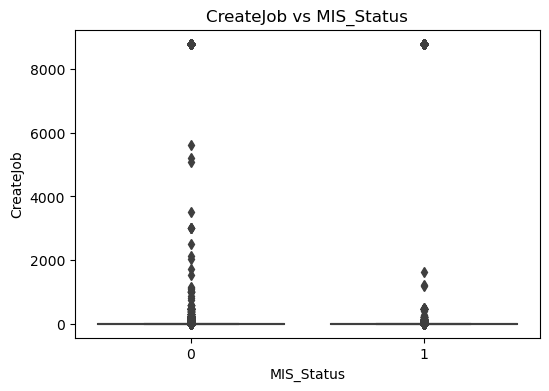

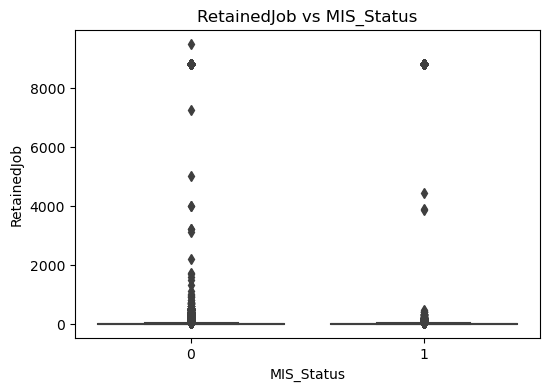

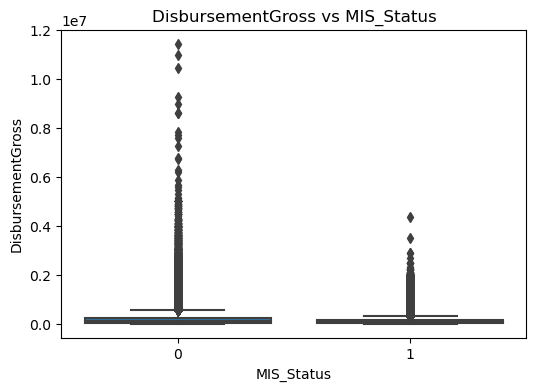

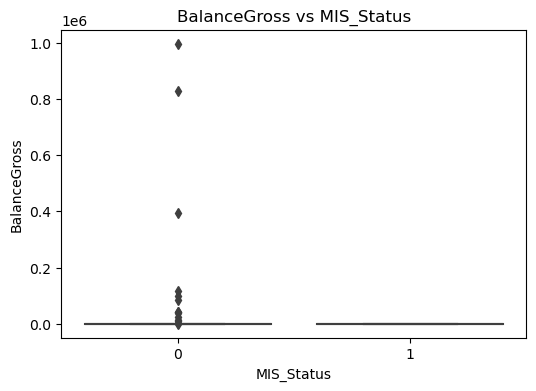

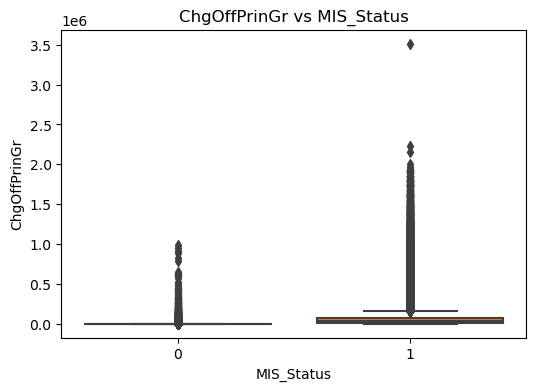

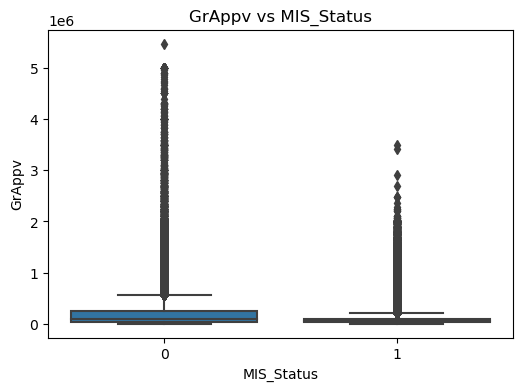

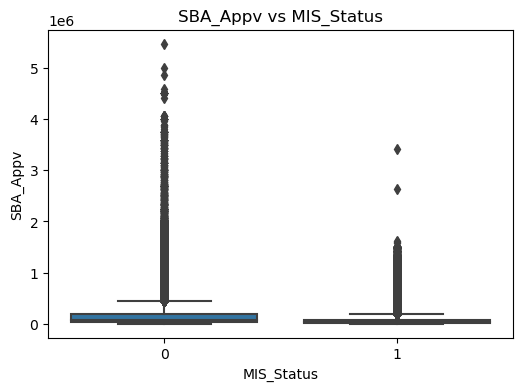

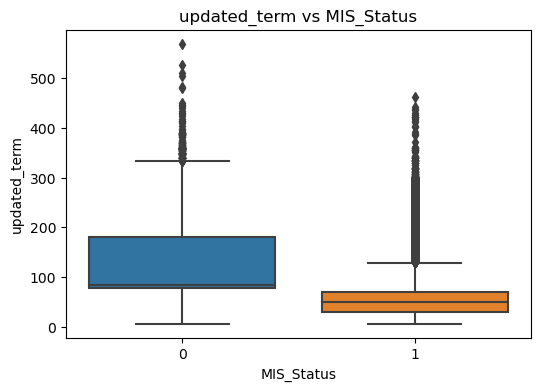

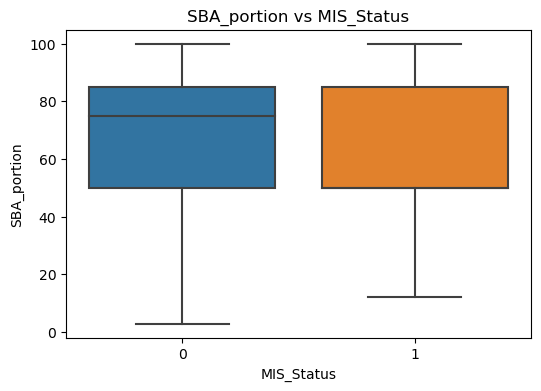

In [19]:

for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='MIS_Status', y=col, data=data)
    plt.title(f'{col} vs MIS_Status')
    plt.xlabel('MIS_Status')
    plt.ylabel(col)
    plt.show()

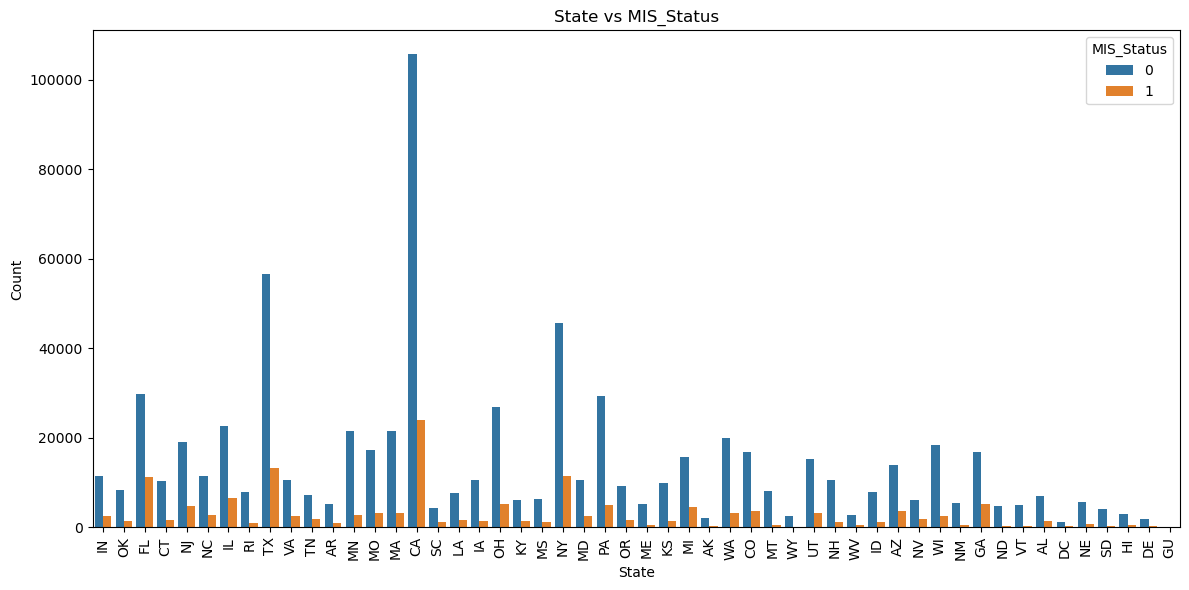

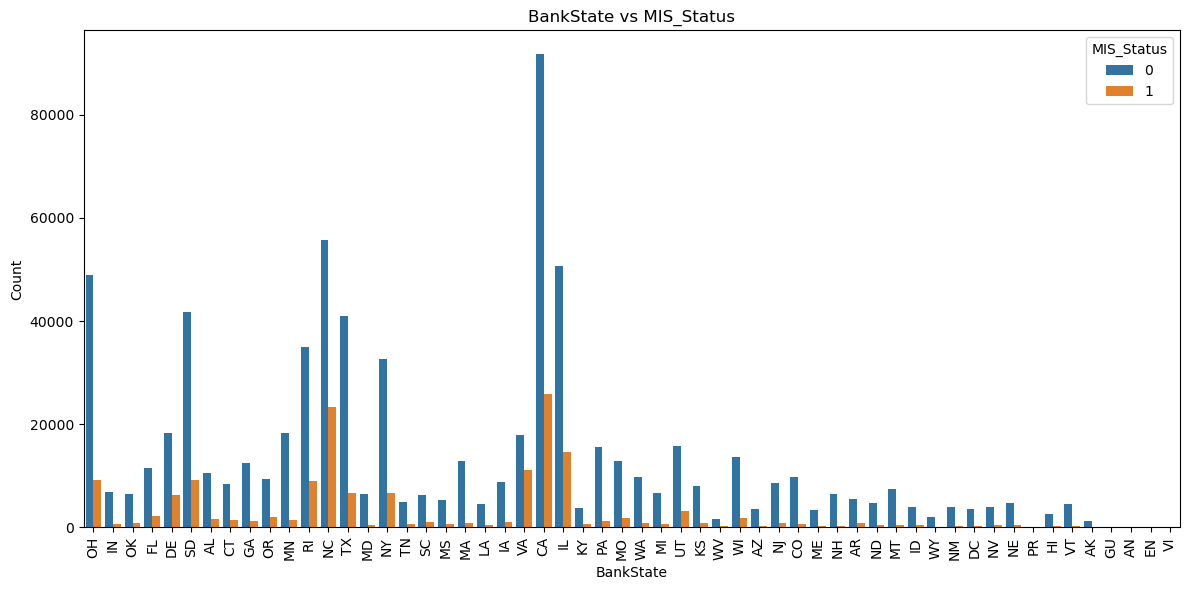

/var/folders/t6/62p5k1w921vdm0907xrsq0ph0000gn/T/ipykernel_26933/2399228387.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


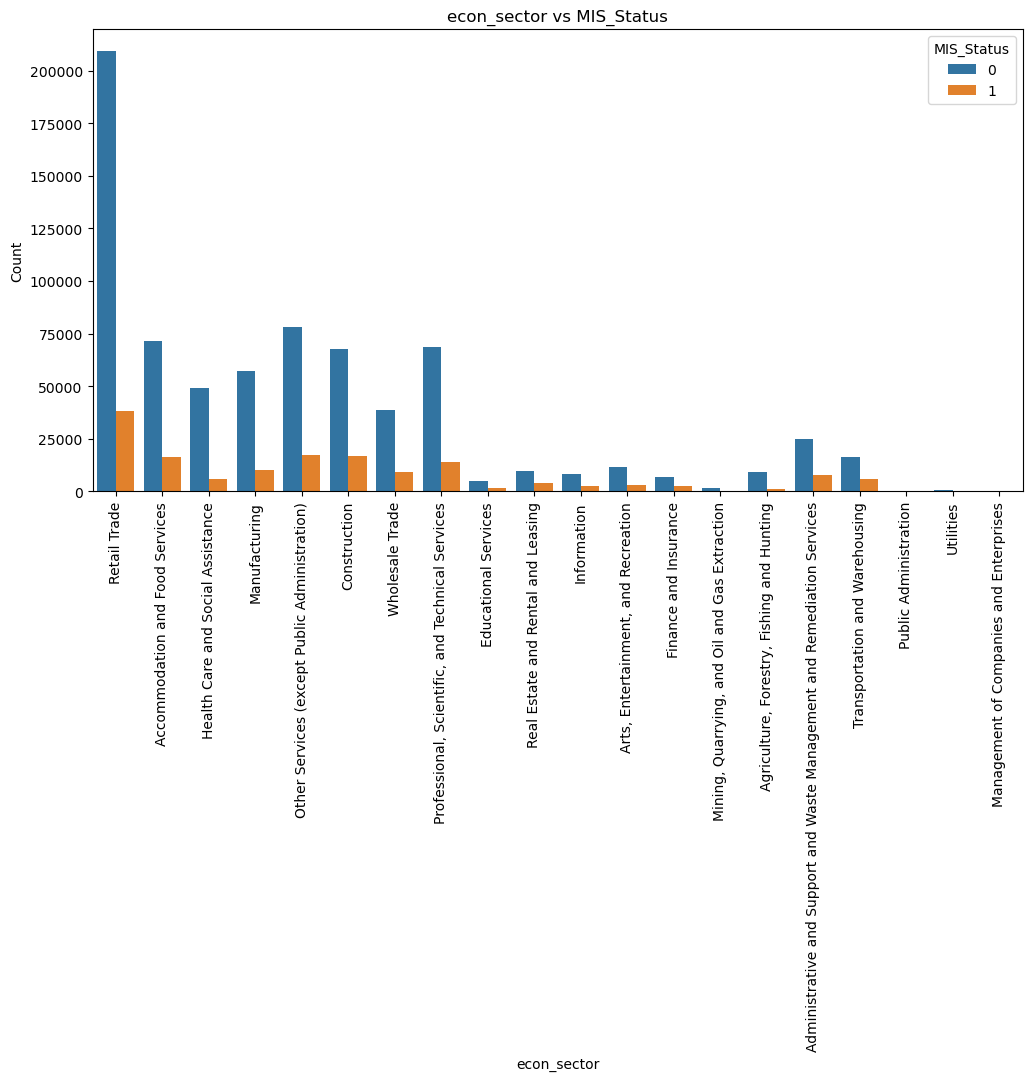

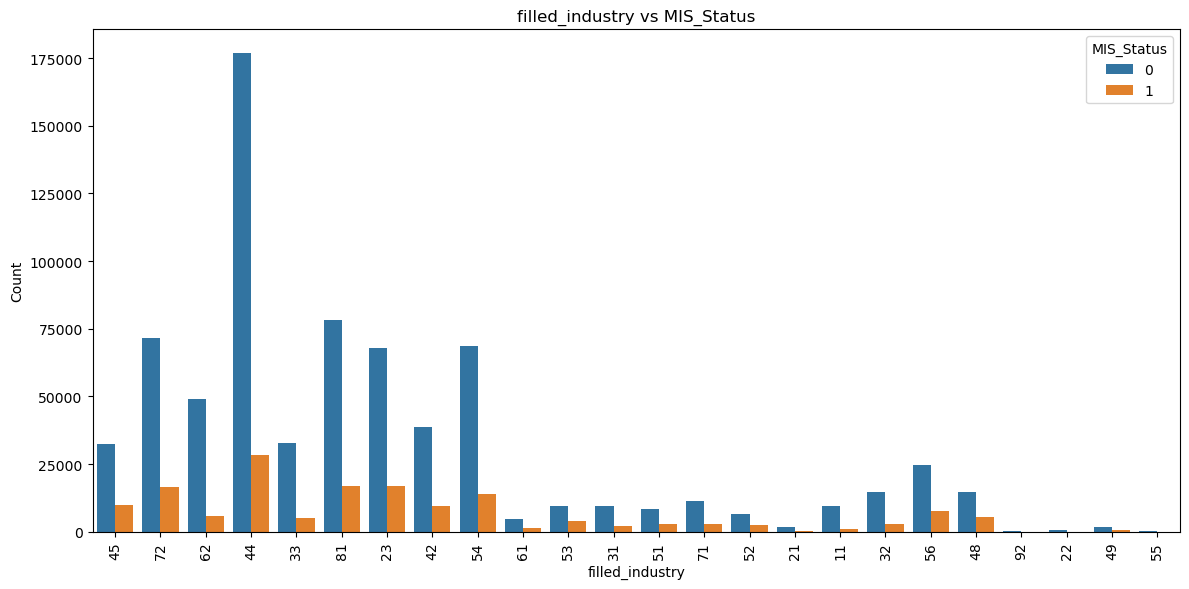

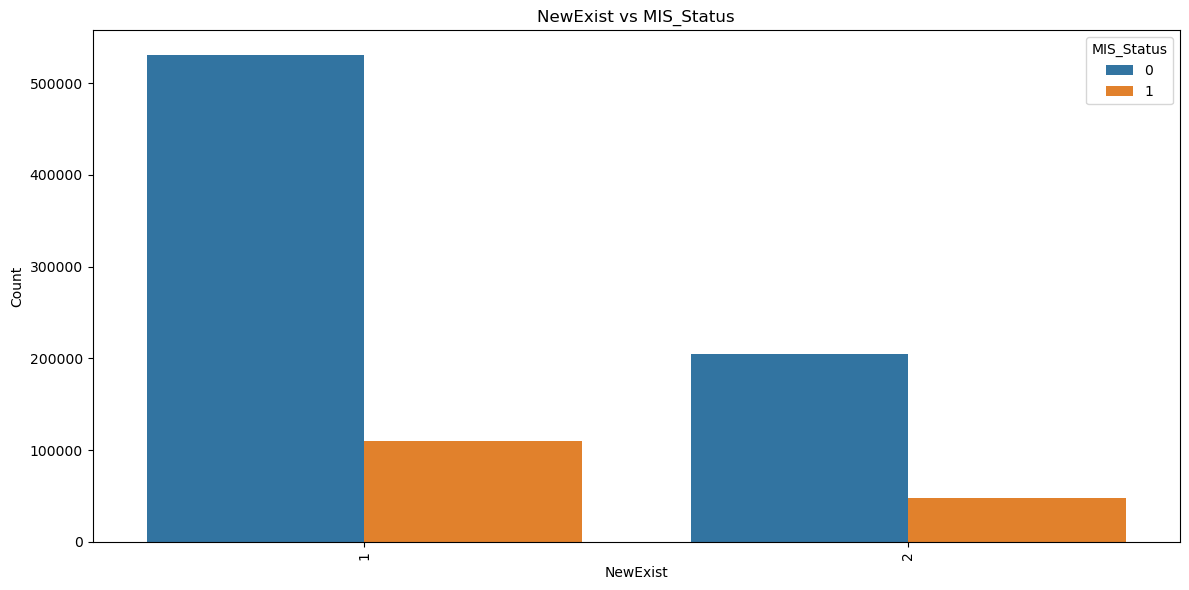

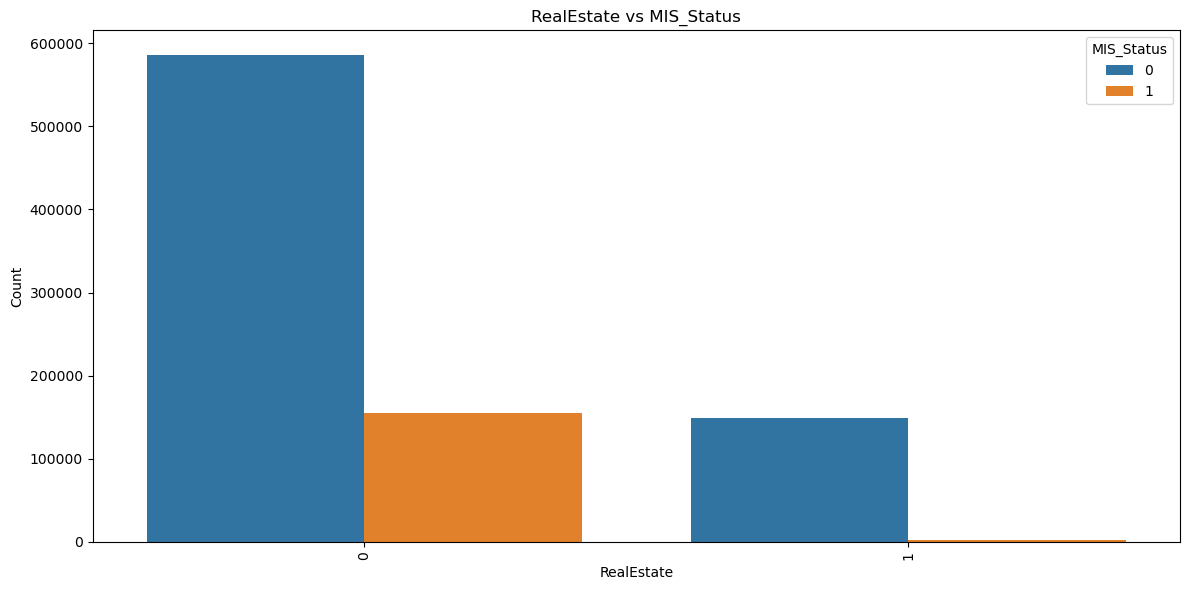

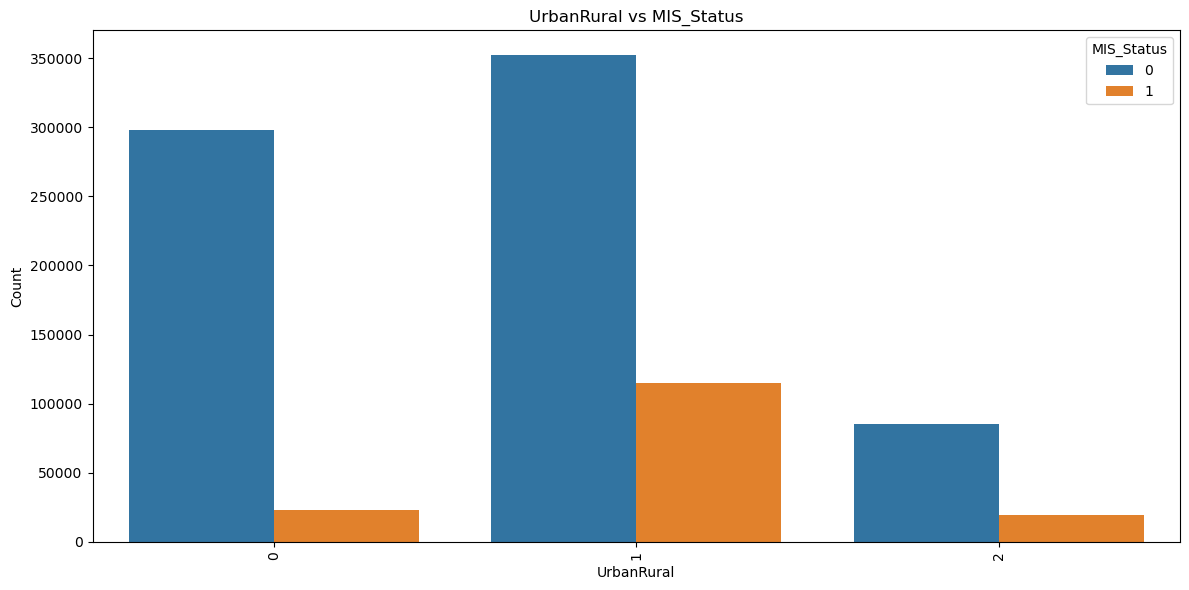

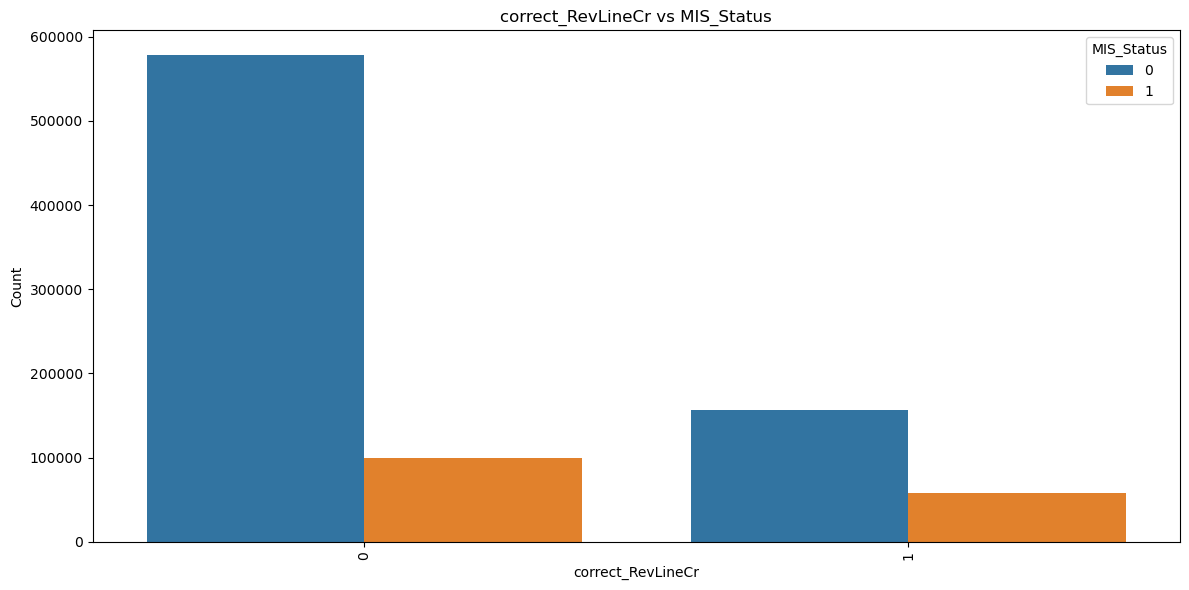

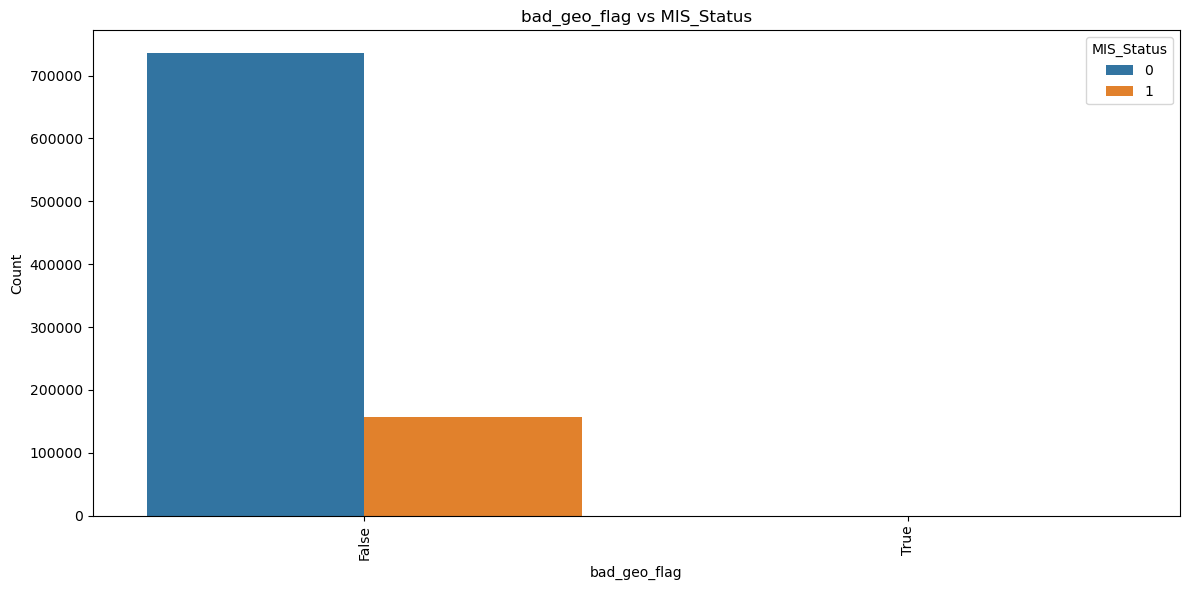

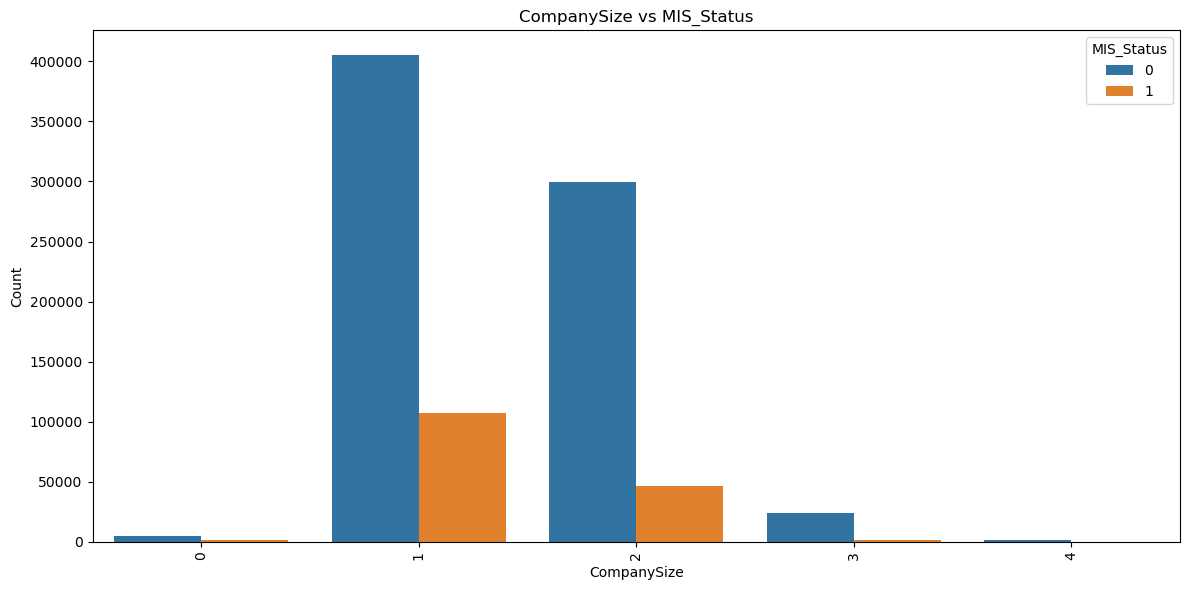

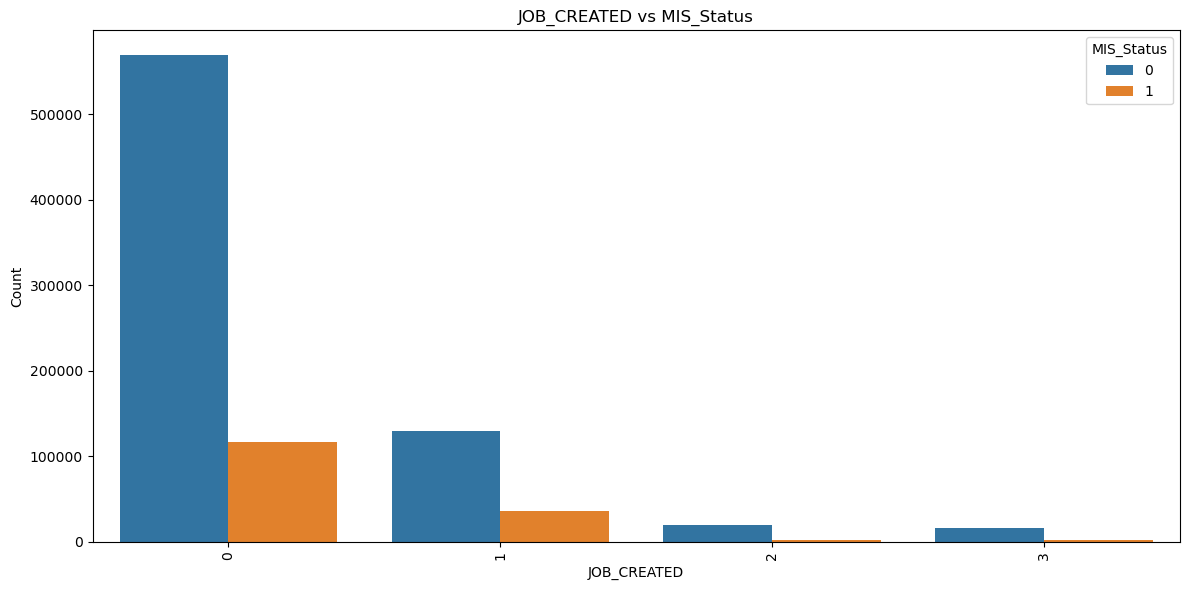

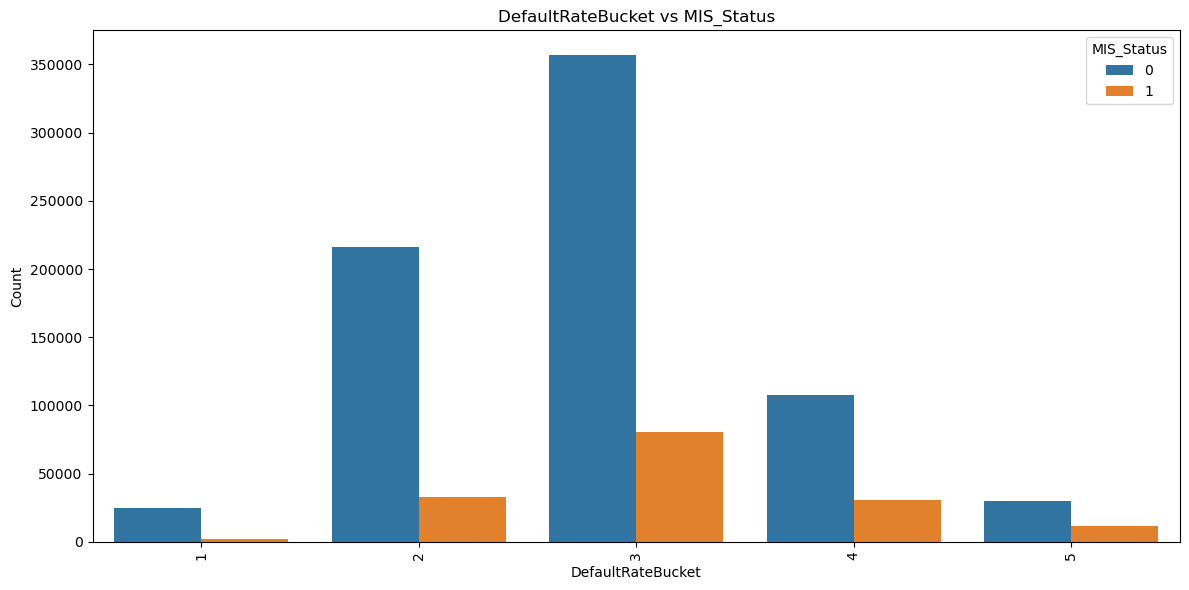

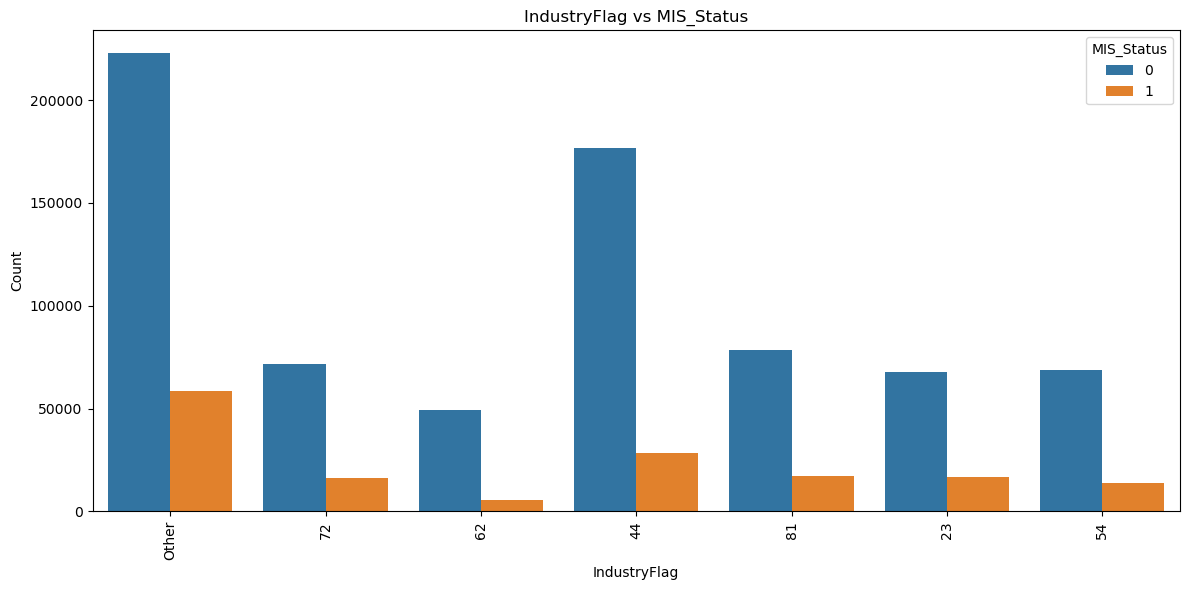

In [20]:

for col in categorical_cols:
    plt.figure(figsize=(12, 6))  
    sns.countplot(x=col, hue='MIS_Status', data=data)  
    plt.title(f'{col} vs MIS_Status') 
    plt.xlabel(col)  
    plt.ylabel('Count')  
    plt.xticks(rotation=90)  
    plt.tight_layout()  
    plt.show()

/var/folders/t6/62p5k1w921vdm0907xrsq0ph0000gn/T/ipykernel_26933/1718404512.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=temp_data[temp_data['MIS_Status'] == 0], x='NoEmp', label='MIS_Status = 0', shade=True, color='blue')
/var/folders/t6/62p5k1w921vdm0907xrsq0ph0000gn/T/ipykernel_26933/1718404512.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=temp_data[temp_data['MIS_Status'] == 1], x='NoEmp', label='MIS_Status = 1', shade=True, color='orange')


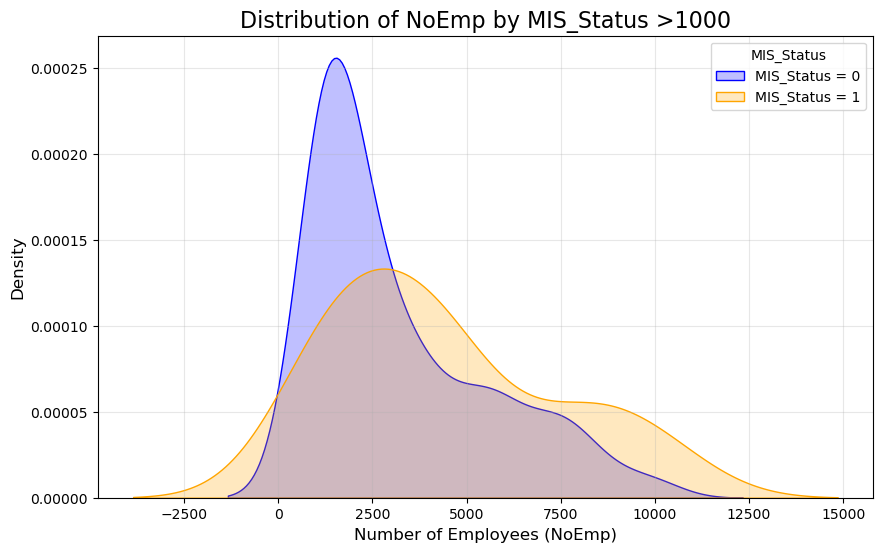

In [21]:
'''Visual representation of the Employee distribution wrt to the MIS_Defaulters. 
This is for the firms where the employee count is more than 1000'''
# Set up the figure
temp_data = data[data['NoEmp'] >=1000]
plt.figure(figsize=(10, 6))

# Plot KDE distributions for NoEmp grouped by MIS_Status
sns.kdeplot(data=temp_data[temp_data['MIS_Status'] == 0], x='NoEmp', label='MIS_Status = 0', shade=True, color='blue')
sns.kdeplot(data=temp_data[temp_data['MIS_Status'] == 1], x='NoEmp', label='MIS_Status = 1', shade=True, color='orange')

# Customize the plot
plt.title('Distribution of NoEmp by MIS_Status >1000', fontsize=16)
plt.xlabel('Number of Employees (NoEmp)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='MIS_Status', fontsize=10)
plt.grid(alpha=0.3)

# Display the plot
plt.show()

/var/folders/t6/62p5k1w921vdm0907xrsq0ph0000gn/T/ipykernel_26933/3010151729.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=temp_data[temp_data['MIS_Status'] == 0], x='NoEmp', label='MIS_Status = 0', shade=True, color='blue')
/var/folders/t6/62p5k1w921vdm0907xrsq0ph0000gn/T/ipykernel_26933/3010151729.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=temp_data[temp_data['MIS_Status'] == 1], x='NoEmp', label='MIS_Status = 1', shade=True, color='orange')


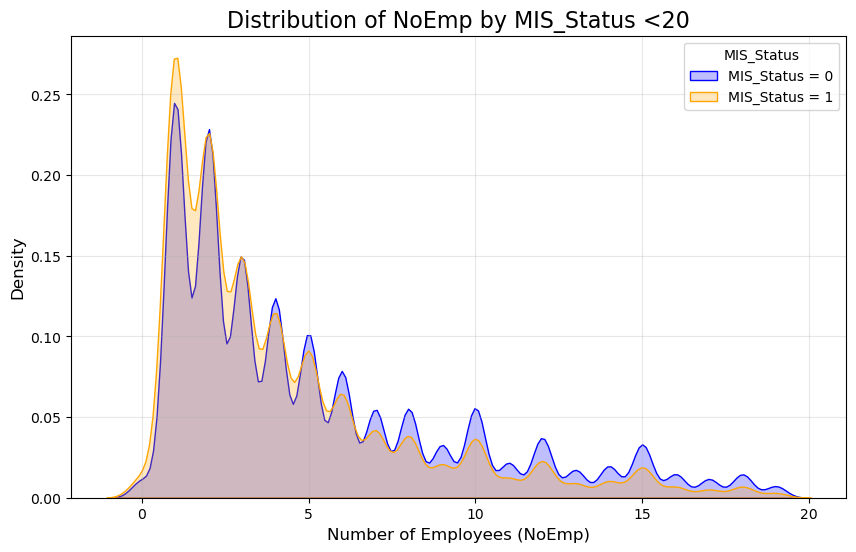

In [22]:
'''Visual representation of the Employee distribution wrt to the MIS_Defaulters. 
This is for the firms where the employee count is less than 1000'''
# Set up the figure
temp_data = data[data['NoEmp'] <20]
plt.figure(figsize=(10, 6))

# Plot KDE distributions for NoEmp grouped by MIS_Status
sns.kdeplot(data=temp_data[temp_data['MIS_Status'] == 0], x='NoEmp', label='MIS_Status = 0', shade=True, color='blue')
sns.kdeplot(data=temp_data[temp_data['MIS_Status'] == 1], x='NoEmp', label='MIS_Status = 1', shade=True, color='orange')

# Customize the plot
plt.title('Distribution of NoEmp by MIS_Status <20', fontsize=16)
plt.xlabel('Number of Employees (NoEmp)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='MIS_Status', fontsize=10)
plt.grid(alpha=0.3)

# Display the plot
plt.show()

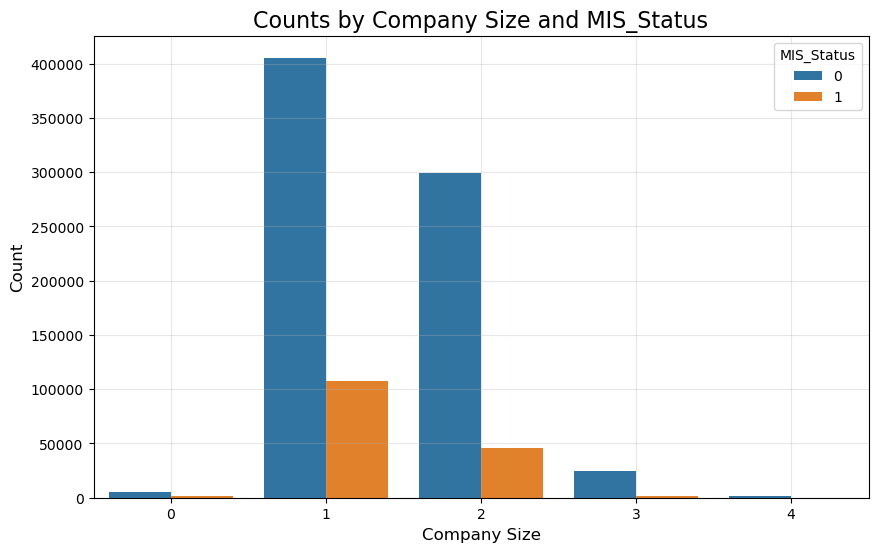

"So let's use this category along with the number of resources to guiide the learning model for \nbetter uderstand the trend"

In [23]:
# Company Size plotting
# Group by CompanySize and MIS_Status, and count the records
size_status_counts = data.groupby(['CompanySize', 'MIS_Status']).size().reset_index(name='Count')

# Define a color palette for MIS_Status
status_palette = {0: 'blue', 1: 'orange'}

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=size_status_counts,
    x='CompanySize',
    y='Count',
    hue='MIS_Status'
)

# Customize the plot
plt.title('Counts by Company Size and MIS_Status', fontsize=16)
plt.xlabel('Company Size', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='MIS_Status',  fontsize=10)
plt.grid(alpha=0.3)

# Show the plot
plt.show()

'''So let's use this category along with the number of resources to guiide the learning model for 
better uderstand the trend'''

As the company size grows the default rate also goes down. Which is evident from the above company bucket mapping on the MIS_STATUS

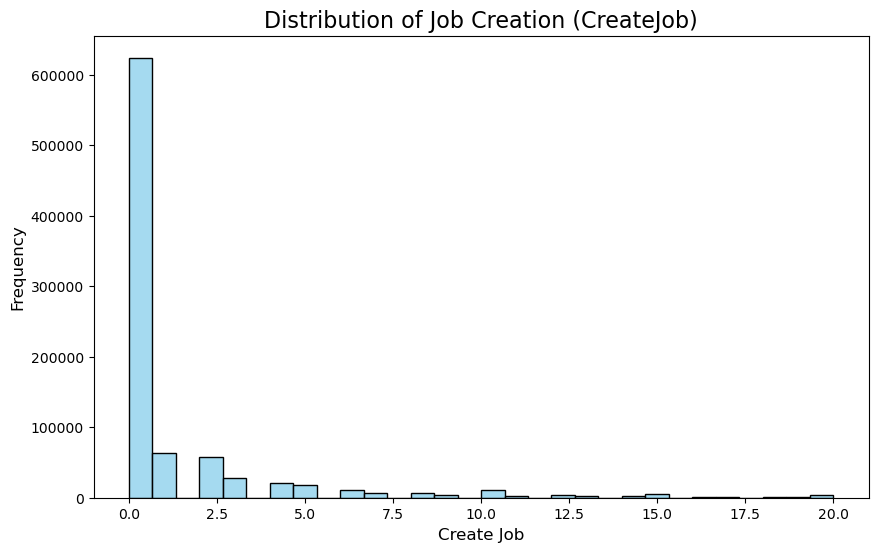

In [24]:
# Job Creation Data Analysis

temp_data1 = data[(data['CreateJob']<=20) ]

# So majority of the organizations has not created any job in the data set. 

'''Let's examine the companies with less new jobs and more new jobs '''
# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the histogram for CreateJob distribution
sns.histplot(data=temp_data1, x='CreateJob', kde=False, bins=30, color='skyblue')

# Customize the plot
plt.title('Distribution of Job Creation (CreateJob)', fontsize=16)
plt.xlabel('Create Job', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Display the plot
plt.show()

# Correlation Analysis: Key Insights

## 1. CreateJob and RetainedJob
- The correlation between **CreateJob** and **RetainedJob** is **0.99**, indicating a very strong linear relationship.
- These features might be capturing overlapping or redundant information.

## 2. GrAppv (Gross Approval) and SBA_Appv (SBA Approval)
- The correlation between **GrAppv** and **SBA_Appv** is **0.97**, which is very high.
- These variables are likely very similar, potentially representing redundant data.

## 3. BalanceGross
- **BalanceGross** shows weak correlations with almost all other variables, with most values near **0.00**.
- This suggests that it may not have significant linear relationships with other predictors.

## 4. updated_term and SBA_Appv
- **updated_term** has a moderate correlation of **0.53** with **SBA_Appv**.
- This indicates that businesses with higher loan approvals may tend to have longer loan terms, though the correlation is not extremely strong.

## 5. NoEmp (Number of Employees)
- **NoEmp** shows very weak correlations with other numerical predictors, with most values close to **0.00**.
- This suggests that the number of employees is not strongly linearly related to other numerical variables in the dataset.

---

# Correlation Heatmap and Table
Below is a visualization of the correlation matrix and the corresponding table for better understanding.

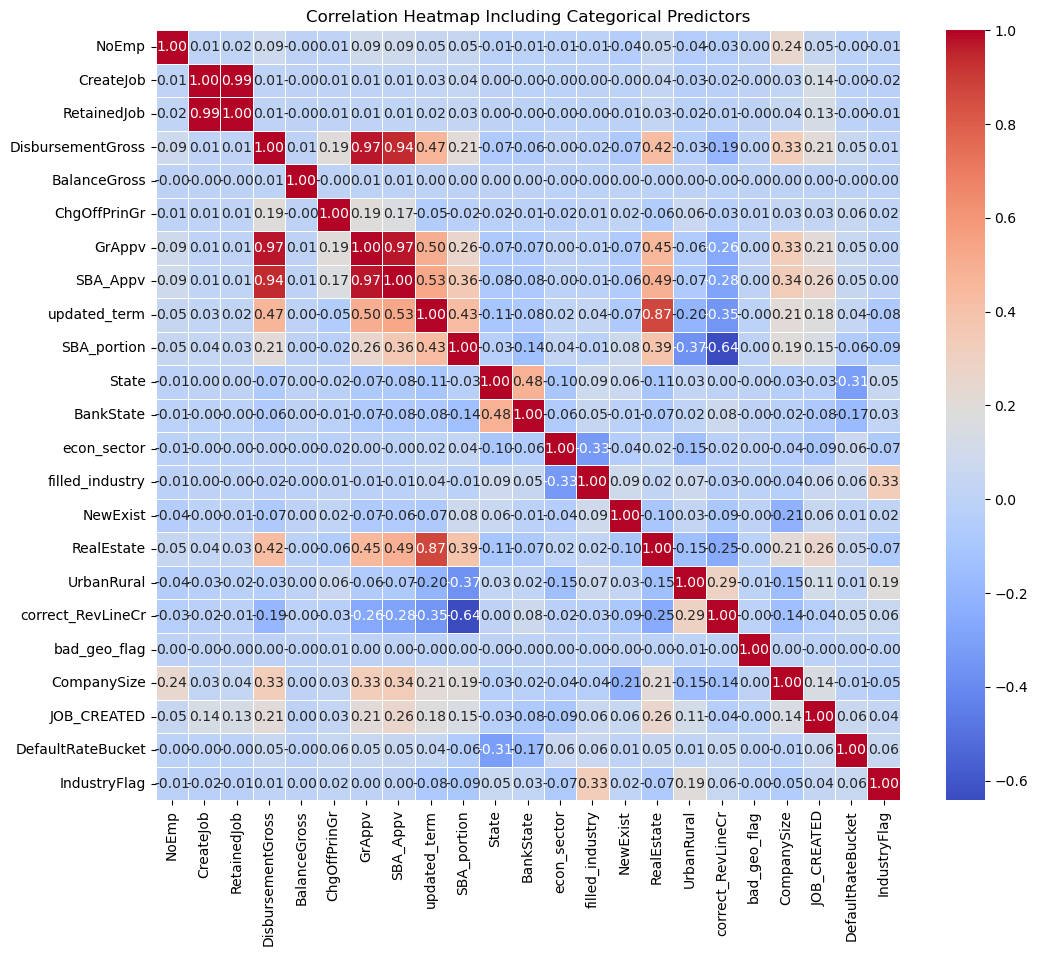

In [25]:
# Make a copy of the data to encode categorical variables
data_encoded = data.copy()

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col].astype(str))  # Encode as strings to handle non-numeric values
    label_encoders[col] = le

# Combine numerical and encoded categorical columns
all_columns = numerical_cols + categorical_cols
corr = data_encoded[all_columns].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap Including Categorical Predictors')
plt.show()

# Observations and Inferences for Predicting `MIS_Status`

---

### **Key Observations**

1. **Highly Correlated Variables with `MIS_Status`:**
    - **`DisbursementGross` and `updated_term`:**
        - These features show moderate to strong correlations with numerical variables such as `SBA_portion`, `CompanySize`, and `RealEstate`.
        - This suggests that both the disbursed loan amount and loan terms likely play a crucial role in predicting loan status.

2. **Weak Correlations:**
    - **`econ_sector` and `bad_geo_flag`:**
        - Both have correlations close to zero with most other variables.
        - Their standalone impact on determining `MIS_Status` might be minimal.

3. **Feature Interactions:**
    - **`RealEstate` and `updated_term`:**
        - These two variables show a strong correlation (0.869), signaling potential collinearity. This will need attention during the modeling process.
    - **Negative Correlations:**
        - Features like `correct_RevLineCr` and `UrbanRural` show moderate negative correlations with `MIS_Status`, possibly identifying sectors or areas prone to defaults.

4. **Potential Predictive Variables:**
    - Features such as `DisbursementGross`, `RealEstate`, `SBA_portion`, and `DefaultRateBucket` display consistent correlations, marking them as promising candidates for predicting `MIS_Status`.

5. **Categorical Features:**
    - Encoded categorical features (`econ_sector`, `IndustryFlag`, `State`) exhibit weak correlations with numerical ones. Their impact may need to be uncovered using advanced methods like feature importance analysis.

---

### **Inferences for `MIS_Status`**

1. **Loan Size and Terms Impact Default Risk:**
    - Higher disbursed amounts (`DisbursementGross`) and extended loan terms (`updated_term`) seem to correlate with `MIS_Status`. Larger loans or longer repayment periods might elevate default risk.

2. **Geographical and Industry Impact:**
    - The weak correlations of `State` and `IndustryFlag` suggest these factors might vary in influence based on specific regions or industries. They may act more as modifiers than as primary predictors.

3. **Default Rates and Job Creation:**
    - Features like `DefaultRateBucket` and `JOB_CREATED` show low to moderate correlations with `MIS_Status`. This indicates that default risk may be indirectly linked to job creation and retention.

4. **Collinearity Concerns:**
    - Strong correlations between `RealEstate` and `updated_term` point to potential redundancy. Techniques like PCA or regularization could help address this issue.

5. **Potential Weak Features:**
    - Variables like `bad_geo_flag` and `econ_sector` have near-zero correlations with most features, suggesting limited standalone predictive value.

---

### **Next Steps**
1. **Feature Engineering:**
    - Investigate potential interaction terms (e.g., `DisbursementGross * updated_term`) and transformations for weakly correlated features.
    - Address multicollinearity in highly correlated predictors like `RealEstate` and `updated_term`.

2. **Model Testing:**
    - Use tree-based models (e.g., Random Forest, Gradient Boosting) to capture nonlinear relationships.
    - Validate feature importance using tools like SHAP or permutation importance.

3. **Dimensionality Reduction:**
    - Explore PCA or similar techniques to reduce redundancy and simplify the dataset.

4. **Focus on Business Insights:**
    - Analyze patterns in geographical data (`State`, `BankState`) for region-specific trends influencing default behavior.

---

Let’s dive into modeling! Addressing these correlations and patterns will help us build a robust predictive model for `MIS_Status`.


# Preprocessing

In [26]:
# Columns of interest
X_cols = ['State','NewExist','UrbanRural','DisbursementGross',
         'LowDoc_correct','updated_term','RealEstate','recession','SBA_portion','If_Franchise','correct_RevLineCr',
         'filled_industry','CompanySize','JOB_CREATED','DefaultRateBucket','IndustryFlag']
y_cols = ['MIS_Status']

categorical_x_cols = ['State','NewExist','UrbanRural','LowDoc_correct','RealEstate','recession','If_Franchise',
                      'correct_RevLineCr','filled_industry','CompanySize','JOB_CREATED','DefaultRateBucket','IndustryFlag']
numerical_x_cols=['DisbursementGross','updated_term','SBA_portion']

final_data = data[X_cols+y_cols].copy()
final_data.to_csv("Secondversion/Cleaned_data_SBA.csv")

## Sampling the data 

Let's create the sample data to build the models and validate the results to optimize the run time

So we are going to use the stratify method to ensire a equal percentage of representation exists for each category class

In [27]:
# Define the sample size
sample_size = 89348  # Adjust as needed

# Group by multiple attributes (e.g., MIS_Status, Industry, State)
group_columns = ['NewExist','UrbanRural','LowDoc_correct','RealEstate','recession','If_Franchise',
                      'correct_RevLineCr','CompanySize','JOB_CREATED','MIS_Status','DefaultRateBucket','IndustryFlag']


In [28]:
import dask.dataframe as dd

# Convert Pandas DataFrame to Dask
dask_data = dd.from_pandas(final_data, npartitions=8)

# Perform stratified sampling with Dask
stratified_sample = (
    dask_data.groupby(group_columns)
    .apply(lambda group: group.sample(frac=sample_size / len(final_data)), meta=final_data)
    .compute()
)

In [29]:
stratified_sample.head()

State  NewExist  UrbanRural  DisbursementGross  LowDoc_correct  \
LoanNr_ChkDgt                                                                  
3479603007       VT         1           0             155000               0   
4012823004       ND         1           0             200000               0   
7212053007       MT         1           0             750000               0   
5748673004       MT         1           0             202500               0   
8371733001       WY         1           0             153000               0   

               updated_term  RealEstate  recession  SBA_portion  If_Franchise  \
LoanNr_ChkDgt                                                                   
3479603007              180           0          0         75.0             0   
4012823004              116           0          0         85.0             0   
7212053007               54           0          0         80.0             0   
5748673004               84           0          0         85.0             0   
8371733001               60           0          0         90.0             0   

               correct_RevLineCr filled_industry  CompanySize  JOB_CREATED  \
LoanNr_ChkDgt                                                                
3479603007                     0              72            1            0   
4012823004                     0              21            1            0   
7212053007                     0              42            1            0   
5748673004                     0              31            1            0   
8371733001                     0              53            1            0   

               DefaultRateBucket IndustryFlag  MIS_Status  
LoanNr_ChkDgt                                              
3479603007                     1           72           0  
4012823004                     1        Other           0  
7212053007                     1        Other           0  
5748673004                     1        Other           0  
8371733001                     1        Other           0

In [30]:
stratified_sample.dtypes

category_cols = ['State','NewExist','UrbanRural','LowDoc_correct','RealEstate','recession',
                'If_Franchise','correct_RevLineCr','filled_industry','IndustryFlag'] # Drop this geo flag
numerical_cols = ['DisbursementGross','updated_term','SBA_portion','CompanySize','JOB_CREATED','DefaultRateBucket']
stratified_sample[category_cols] = stratified_sample[category_cols].astype('category')
#stratified_sample[numerical_cols] = stratified_sample[numerical_cols].astype('Float64')
stratified_sample.dtypes

State                category
NewExist             category
UrbanRural           category
DisbursementGross       Int64
LowDoc_correct       category
updated_term            int64
RealEstate           category
recession            category
SBA_portion           Float64
If_Franchise         category
correct_RevLineCr    category
filled_industry      category
CompanySize             int64
JOB_CREATED             int64
DefaultRateBucket       int64
IndustryFlag         category
MIS_Status               Int8
dtype: object

## Split the data in test and training with X and Y columns and columns of interest

In [31]:
# prompt: train test split
final_features_and_y = ['NewExist','UrbanRural','LowDoc_correct','RealEstate','recession','If_Franchise',
                        'correct_RevLineCr','DisbursementGross','updated_term',
                        'SBA_portion','CompanySize','JOB_CREATED','DefaultRateBucket','IndustryFlag','MIS_Status']
# Assuming 'loan' DataFrame is already prepared as shown in the provided code.
loan = stratified_sample[final_features_and_y].copy()

# Define features (X) and target variable (y)
X = loan.drop(['MIS_Status'], axis=1)
X = X.fillna(0) 
y = loan['MIS_Status']


# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (70237, 14)
X_test shape: (17560, 14)
y_train shape: (70237,)
y_test shape: (17560,)


In [32]:
X_train.columns

Index(['NewExist', 'UrbanRural', 'LowDoc_correct', 'RealEstate', 'recession',
       'If_Franchise', 'correct_RevLineCr', 'DisbursementGross',
       'updated_term', 'SBA_portion', 'CompanySize', 'JOB_CREATED',
       'DefaultRateBucket', 'IndustryFlag'],
      dtype='object')

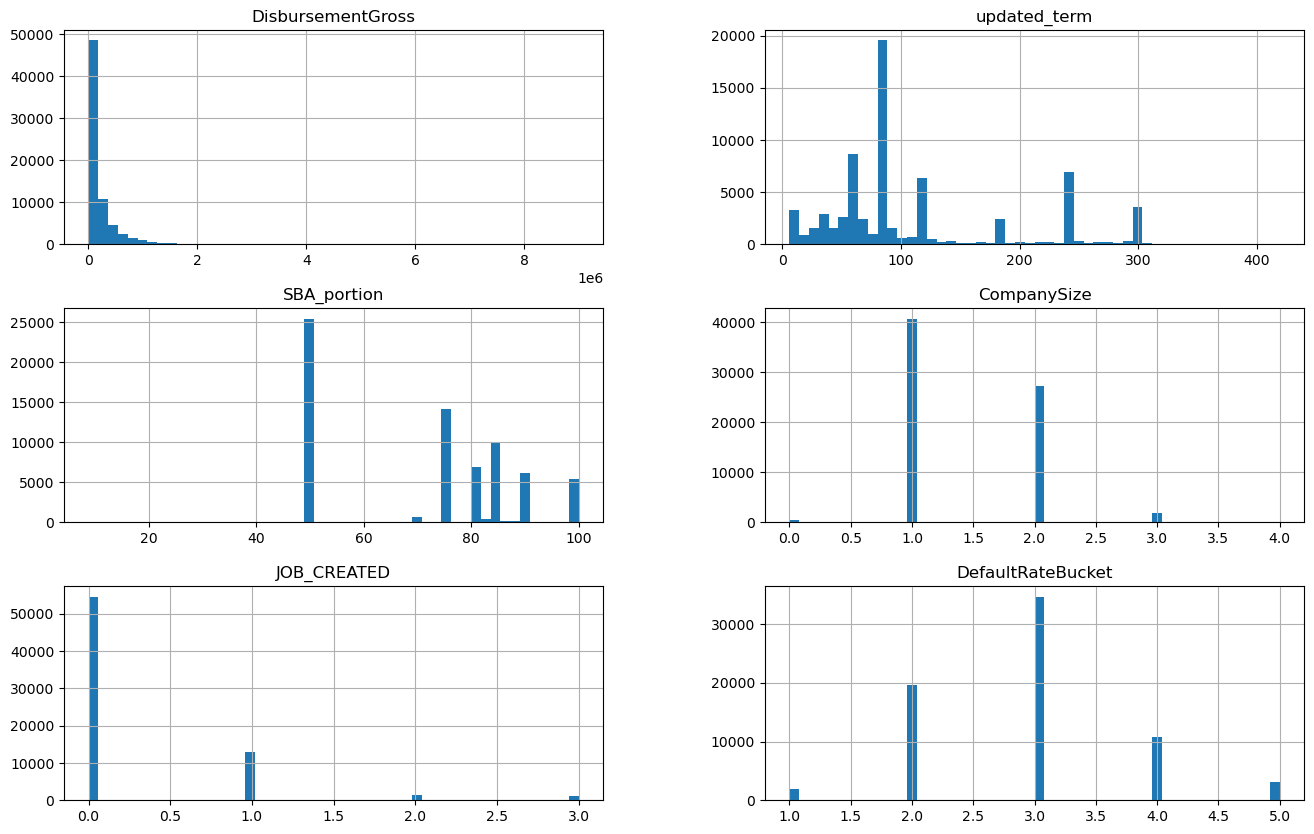

In [33]:
X_train.hist(bins=50, figsize=(16,10))
plt.show()

# PreProcessing and pipelines

## Feature Transformations
### Handling Categorical Variables
- **Label Encoding**:  
  - Columns `IndustryFlag`, `CompanySize`, `DefaultRateBucket` converted using `LabelEncoder`.

- **One-Hot Encoding**:  
  - Columns `NewExist`, `UrbanRural` encoded using `OneHotEncoder`.

### Log Transformation for Skewed Features
- Transformed `updated_term`, `DisbursementGross`, and `SBA_portion` using Yeo-Johnson PowerTransformer to reduce skewness.

---

In [34]:
cat_attrs = ['NewExist', 'UrbanRural' ]
lab_attrs = [ 'IndustryFlag', 'CompanySize', 'DefaultRateBucket']
log_attrs = ['updated_term', 'DisbursementGross']
quant_attrs = ['SBA_portion']
pass_attrs = ['recession', 'RealEstate', 'LowDoc_correct', 'correct_RevLineCr', 'If_Franchise', 'JOB_CREATED']

In [35]:
# prompt: create label encoding pipeline for lab_attrs.. not using pipeline

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for each categorical column
label_encoders = {}
for col in lab_attrs:
    le = LabelEncoder()
    label_encoders[col] = le

# Fit and transform the training data
for col in lab_attrs:
    X_train[col] = label_encoders[col].fit_transform(X_train[col])

# Transform the test data using the fitted LabelEncoders
for col in lab_attrs:
    X_test[col] = label_encoders[col].transform(X_test[col])

In [36]:
# Save to drive
X_train.to_csv('Secondversion/X_train_raw.csv')
X_test.to_csv('Secondversion/X_test_raw.csv')
y_train.to_csv('Secondversion/y_train_raw.csv')
y_test.to_csv('Secondversion/y_test_raw.csv')

In [37]:
X_train = pd.read_csv('Secondversion/X_train_raw.csv').set_index('LoanNr_ChkDgt')
X_test = pd.read_csv('Secondversion/X_test_raw.csv').set_index('LoanNr_ChkDgt')
y_train = pd.read_csv('Secondversion/y_train_raw.csv').set_index('LoanNr_ChkDgt')['MIS_Status'].ravel()
y_test = pd.read_csv('Secondversion/y_test_raw.csv').set_index('LoanNr_ChkDgt')['MIS_Status'].ravel()

In [38]:
X_train.head()

NewExist  UrbanRural  LowDoc_correct  RealEstate  recession  \
LoanNr_ChkDgt                                                                
6210073004            1           0               0           0          1   
8911134007            1           1               1           0          1   
2287614007            2           0               0           0          0   
4927644003            1           1               0           0          1   
2986544009            1           1               1           1          1   

               If_Franchise  correct_RevLineCr  DisbursementGross  \
LoanNr_ChkDgt                                                       
6210073004                0                  0             165000   
8911134007                0                  1             100000   
2287614007                0                  0             150000   
4927644003                0                  0             350000   
2986544009                0                  0             137700   

               updated_term  SBA_portion  CompanySize  JOB_CREATED  \
LoanNr_ChkDgt                                                        
6210073004              183         75.0            2            0   
8911134007               84         50.0            2            1   
2287614007               60         75.0            1            0   
4927644003              120         75.0            2            0   
2986544009              300         75.0            2            0   

               DefaultRateBucket  IndustryFlag  
LoanNr_ChkDgt                                   
6210073004                     2             1  
8911134007                     3             1  
2287614007                     2             1  
4927644003                     3             1  
2986544009                     2             5

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  QuantileTransformer, PowerTransformer, OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer

quantile_pipeline = Pipeline([("quantile transformer", QuantileTransformer(n_quantiles=200))])
log_pipeline = Pipeline([("log transform", PowerTransformer(method = 'yeo-johnson')), ('standard scaler', StandardScaler())])
cat_pipeline = Pipeline([("one hot encoder", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ("quant", quantile_pipeline, quant_attrs),
    ("log", log_pipeline, log_attrs),
    ('cat', cat_pipeline, cat_attrs)],
     remainder='passthrough'
)

In [40]:
X_train.head()

NewExist  UrbanRural  LowDoc_correct  RealEstate  recession  \
LoanNr_ChkDgt                                                                
6210073004            1           0               0           0          1   
8911134007            1           1               1           0          1   
2287614007            2           0               0           0          0   
4927644003            1           1               0           0          1   
2986544009            1           1               1           1          1   

               If_Franchise  correct_RevLineCr  DisbursementGross  \
LoanNr_ChkDgt                                                       
6210073004                0                  0             165000   
8911134007                0                  1             100000   
2287614007                0                  0             150000   
4927644003                0                  0             350000   
2986544009                0                  0             137700   

               updated_term  SBA_portion  CompanySize  JOB_CREATED  \
LoanNr_ChkDgt                                                        
6210073004              183         75.0            2            0   
8911134007               84         50.0            2            1   
2287614007               60         75.0            1            0   
4927644003              120         75.0            2            0   
2986544009              300         75.0            2            0   

               DefaultRateBucket  IndustryFlag  
LoanNr_ChkDgt                                   
6210073004                     2             1  
8911134007                     3             1  
2287614007                     2             1  
4927644003                     3             1  
2986544009                     2             5

In [41]:
# Preprocess the numerical features of training and testing data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [42]:
# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Rename columns in the DataFrames
X_train_final = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_final = pd.DataFrame(X_test_preprocessed, columns=feature_names)


# Save the DataFrames to CSV files in your  Drive
X_train_final.to_csv('Secondversion/X_train_processed.csv', index=False)
X_test_final.to_csv('Secondversion/X_test_processed.csv', index=False)


In [43]:
X_train_final.head()

quant__SBA_portion  log__updated_term  log__DisbursementGross  \
0            0.482412           1.017929                0.423401   
1            0.183417          -0.124108                0.019095   
2            0.482412          -0.546741                0.346223   
3            0.482412           0.368931                1.036127   
4            0.482412           1.879003                0.277033   

   cat__NewExist_1  cat__NewExist_2  cat__UrbanRural_0  cat__UrbanRural_1  \
0              1.0              0.0                1.0                0.0   
1              1.0              0.0                0.0                1.0   
2              0.0              1.0                1.0                0.0   
3              1.0              0.0                0.0                1.0   
4              1.0              0.0                0.0                1.0   

   cat__UrbanRural_2  remainder__LowDoc_correct  remainder__RealEstate  \
0                0.0                        0.0                    0.0   
1                0.0                        1.0                    0.0   
2                0.0                        0.0                    0.0   
3                0.0                        0.0                    0.0   
4                0.0                        1.0                    1.0   

   remainder__recession  remainder__If_Franchise  \
0                   1.0                      0.0   
1                   1.0                      0.0   
2                   0.0                      0.0   
3                   1.0                      0.0   
4                   1.0                      0.0   

   remainder__correct_RevLineCr  remainder__CompanySize  \
0                           0.0                     2.0   
1                           1.0                     2.0   
2                           0.0                     1.0   
3                           0.0                     2.0   
4                           0.0                     2.0   

   remainder__JOB_CREATED  remainder__DefaultRateBucket  \
0                     0.0                           2.0   
1                     1.0                           3.0   
2                     0.0                           2.0   
3                     0.0                           3.0   
4                     0.0                           2.0   

   remainder__IndustryFlag  
0                      1.0  
1                      1.0  
2                      1.0  
3                      1.0  
4                      5.0

## Predictors
- **Categorical Attributes**: `['NewExist']`
- **Label Encoded Attributes**: `['IndustryFlag', 'CompanySize', 'DefaultRateBucket']`
- **Log-Transformed Attributes**: `['updated_term', 'DisbursementGross']`
- **Quantitative Attributes**: `['SBA_portion']`
- **Pass-Through Attributes**: `['recession', 'RealEstate', 'LowDoc_correct', 'correct_RevLineCr', 'If_Franchise', 'JOB_CREATED']`

# Business Metrics 

In [44]:
def business_metric(y_true, y_pred, disbursement_gross):

    """
    Calculate the average net profit based on loan outcomes.

    Parameters:
        y_true (array-like): Actual loan status (1 for Default, 0 for Paid in Full).
        y_pred (array-like): Predicted loan decision (1 for Default, 0 for Paid in Full).
        disbursement_gross (array-like): Loan amounts (DisbursementGross).

    Returns:
        float: Average net profit.
    """
    # Masks for the four outcomes
    mask_true_positive = (y_true == 1) & (y_pred == 1)  # Correctly denied defaults
    mask_true_negative = (y_true == 0) & (y_pred == 0)  # Correctly granted Paid in Full
    mask_false_positive = (y_true == 0) & (y_pred == 1)  # Incorrectly denied Paid in Full
    mask_false_negative = (y_true == 1) & (y_pred == 0)  # Incorrectly granted defaults

    # Calculate profits/losses for each outcome
    denied_correctly =  0  # No profit or loss for denying defaults
    denied_incorrectly = - 5 * 0.05 * disbursement_gross[mask_false_negative].sum()  # Loss for incorrectly granting defaults

    approved_incorectly = 0  # No profit or loss for denying Paid in Full
    approved_correctly = (0.05 * disbursement_gross[mask_true_negative]).sum()  # Profit for correctly granting Paid in Full

    # Total profit
    total_profit = denied_correctly + denied_incorrectly + approved_incorectly + approved_correctly

    # Average net profit
    average_net_profit = total_profit / len(y_true)

    return average_net_profit

### Scorer to calculate the score for average profit per application based on the models predition on the data

In [45]:
import sklearn
from sklearn.metrics import make_scorer
sklearn.set_config(enable_metadata_routing=True)
business_scorer = make_scorer(business_metric).set_score_request(disbursement_gross=True)

In [46]:
disbursement_gross_test = X_test["DisbursementGross"]
disbursement_gross_train = X_train["DisbursementGross"]

# Models 

#### Metrics Evaluation

In [47]:
# Calculate the Metrics and present those. 

#Accuracy

# Get Accuracy 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
# Accuracy 
def return_accuracy(true_values, predicted_values):
    
    accuracy = accuracy_score(true_values, predicted_values)
    return accuracy

# Get the sensitivity of the model. i.e. Recall
# Sensitivity = True POsitive / (True Positive + False Negatives)

def return_sensitivity(true_values, predicted_values):
    recall = recall_score(true_values,predicted_values)
    return recall

# Precision True Positive/(True Positive + False Positives)
def return_precision(true_values, predicted_values):
    precision = precision_score(true_values, predicted_values)
    return precision


# F1 Score = 2.((Precision*Recall)/(Precision + Recall))

def return_F1_Score(true_values, predicted_values):
    f1_value = f1_score(true_values, predicted_values)
    return f1_value


# Calculate the Specificity 

from sklearn.metrics import confusion_matrix

def return_specificity(true_values, predicted_values):
    # Generate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(true_values, predicted_values).ravel()
    # Calculate specificity
    specificity = tn / (tn + fp)
    return specificity

In [48]:
# Get the ROC Curve and AUC 

from sklearn.metrics import roc_curve, roc_auc_score

def AUC_ROC_plots(true_values, predicted_values):
    
    fpr, tpr, thresholds = roc_curve(true_values, predicted_values)
    auc = roc_auc_score(true_values, predicted_values)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
# BUild the Gain Chart

def plot_gains(true_values, predicted_values):
    sorted_indices = np.argsort(-predicted_values)
    y_true_sorted = true_values[sorted_indices]
    cumulative_gain = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    baseline = np.linspace(0, 1, len(true_values))

    plt.plot(cumulative_gain, label="Model")
    plt.plot(baseline, linestyle="--", label="Random")
    plt.xlabel("Proportion of Population")
    plt.ylabel("Cumulative Gain")
    plt.title("Gains Chart")
    plt.legend()
    plt.show()
    
def plot_confusion_matrix(true_values, predicted_values):
    # Generate the confusion matrix
    cm = confusion_matrix(true_values, predicted_values)
    
    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=['Predicted 0', 'Predicted 1'], 
        yticklabels=['Actual 0', 'Actual 1']
    )
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()


In [49]:
# Function to print the accuracy , sensitivity and other KPI's for a model 

def print_metrics(model_name,cut_off_value,actual_values, predicted_values):
    predicted_values = (predicted_values >= cut_off_value).astype(int)
    
    print("Metric for model ", model_name)
    print("Cutoff Threshold is : ", cut_off_value)
    # Profit
#     calculated_profit = calculate_profit(cut_off_value, actual_values, predicted_values, disbursement_gross_test)[0]/len(predicted_values)
#     print(f"Cost/Gain Metrics : ${calculated_profit:,.2f} ")
#     # Get the accuracy of the model 
    accuracy = return_accuracy(actual_values,predicted_values)
    print(f"Accuracy of the {model_name} based on the cut off probability of {cut_off_value} is : {accuracy}")
    
    # Sensitivity
    sensitivity = return_sensitivity(actual_values,predicted_values)
    print(f"Sensitivity of the {model_name} based on the cut off probability of {cut_off_value} is: {sensitivity}")
    
    # Get the precision 
    
    precision = return_precision(actual_values,predicted_values)
    print(f"Precision of the {model_name} based on the cut off probability of {cut_off_value} is: {precision}")
    
    # F1 Value
    f1_value = return_F1_Score(actual_values,predicted_values)
    print(f"F1 Value of the {model_name} based on the cut off probability of {cut_off_value} is: {f1_value}")
    
    specificity = return_specificity(actual_values,predicted_values)
    print(f"Specificity of the {model_name} based on the cut off probability of {cut_off_value} is: {specificity}")
    
    # PLot the confusion Matrix 
    plot_confusion_matrix(actual_values,predicted_values)
    
    # Draw the AUC_ROC charts 
    AUC_ROC_plots(actual_values,predicted_values)


    # Draw the Gains Chart 
    plot_gains(actual_values,predicted_values)

    
    
    

### Logistical Regression Model

In [50]:
X_train_processed = pd.read_csv('Secondversion/X_train_processed.csv')
X_test_processed = pd.read_csv('Secondversion/X_test_processed.csv')

In [51]:
#baseline - Benefit of the 'always Approving' a loan: 
from sklearn.dummy import DummyClassifier

always_approve = DummyClassifier(strategy="constant", constant=0)
always_approve.fit(X_test_processed, y_test)
benefit = business_scorer(
    always_approve, X_test_processed, y_test, disbursement_gross=disbursement_gross_test
)
print(f"Benefit of 'always approving' loan: ${benefit:,.2f}")

Benefit of 'always approving' loan: $3,537.40


In [52]:
#baseline - Benefit of the 'always rejecting' a loan: 
from sklearn.dummy import DummyClassifier

always_approve = DummyClassifier(strategy="constant", constant=1)
always_approve.fit(X_test_processed, y_test)
benefit = business_scorer(always_approve, X_test_processed, y_test, disbursement_gross=disbursement_gross_test)

print(f"Benefit of 'always rejecting' loan: ${benefit:,.2f}")

Benefit of 'always rejecting' loan: $0.00


Confusion Matrix:
[[14011   511]
 [ 2097   941]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     14522
           1       0.65      0.31      0.42      3038

    accuracy                           0.85     17560
   macro avg       0.76      0.64      0.67     17560
weighted avg       0.83      0.85      0.83     17560

ROC-AUC: 0.8488
Confusion Matrix:
[[14011   511]
 [ 2097   941]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     14522
           1       0.65      0.31      0.42      3038

    accuracy                           0.85     17560
   macro avg       0.76      0.64      0.67     17560
weighted avg       0.83      0.85      0.83     17560

Accuracy: 0.8515
Metric for model  Logistical Model
Cutoff Threshold is :  0.5
Accuracy of the Logistical Model based on the cut off probability of 0.5 is : 0.8514806378132118
Sensitivi

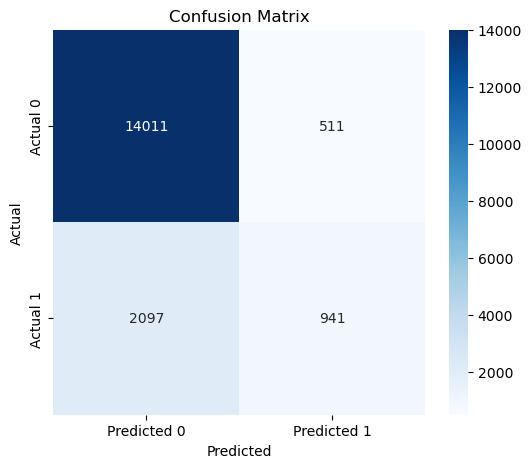

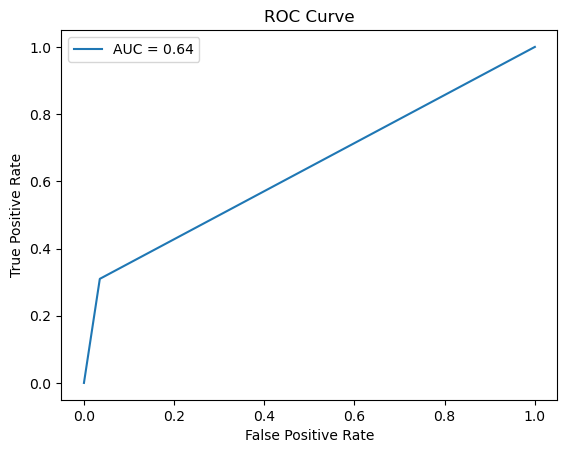

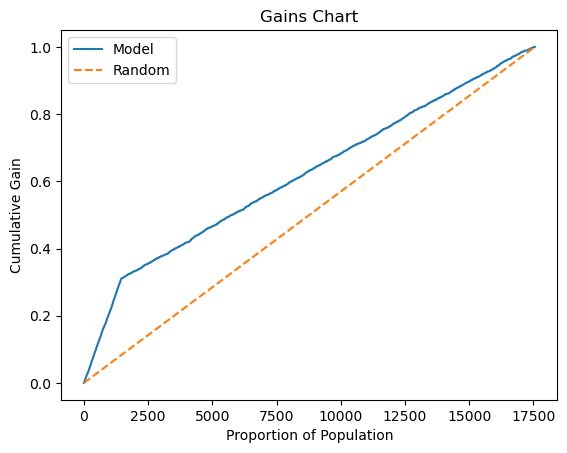

In [53]:
# Logistical Regression Model to predict the probabilities of default.
# Logistic Regression Model
log_model = LogisticRegression( max_iter=1000)
log_model.fit(X_train_processed, y_train)


# Predictions and probabilities
y_pred_proba = log_model.predict_proba(X_test_processed)[:, 1]  # Probability of class 1 (Default)
y_pred = log_model.predict(X_test_processed)



# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

TN, FP, FN, TP = conf_matrix.ravel()

# Calculate evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = recall_score(y_test, y_pred)  # Sensitivity/Recall = TP / (TP + FN)
specificity = TN / (TN + FP)  # Specificity = TN / (TN + FP)
precision = precision_score(y_test, y_pred)  # Precision = TP / (TP + FP)
f1 = f1_score(y_test, y_pred)  # F1-Score
roc_auc = roc_auc_score(y_test, y_pred_proba)  # ROC-AUC score

print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print(f"Accuracy: {accuracy:.4f}")

print_metrics('Logistical Model', 0.5, y_test,y_pred_proba)


O# Observations and Inferences for Logistic Regression Model

### Observations:

1. **Confusion Matrix Insights:**
    - **True Negatives (TN):** 14,024 instances correctly classified as low risk (class 0).
    - **False Positives (FP):** 498 instances incorrectly classified as high risk (class 1).
    - **False Negatives (FN):** 2,096 instances incorrectly classified as low risk (class 0) but are actually high risk.
    - **True Positives (TP):** 942 instances correctly classified as high risk (class 1).

2. **Class Imbalance:**
    - The support for class 0 (low risk) is significantly higher (14,522) than for class 1 (high risk) at 3,038, indicating a class imbalance.

3. **Precision and Recall:**
    - **Precision for Class 1 (High Risk):** 0.65. This indicates that 65% of the predicted high-risk loans are correct.
    - **Recall for Class 1 (High Risk):** 0.31. Only 31% of the actual high-risk loans are being correctly predicted.
    - **F1-Score for Class 1:** 0.42, reflecting a trade-off between precision and recall.

4. **Overall Metrics:**
    - **Accuracy:** 85%. While accuracy is relatively high, it is not the best metric due to class imbalance.
    - **Macro Avg F1-Score:** 0.67. Indicates moderate performance when considering both classes equally.
    - **Weighted Avg F1-Score:** 0.83. Weighted by class prevalence, dominated by the performance on class 0.

5. **ROC-AUC Score:**
    - **ROC-AUC:** 0.8466. Suggests good discriminatory ability between high-risk and low-risk loans, though improvements are needed for high-risk classification.


### Inferences:

1. **Focus on Class 1 (High Risk):**
    - The model struggles to predict high-risk loans correctly, with a recall of only 31%. This is a critical area for improvement since identifying high-risk loans (class 1) is your primary goal.

2. **Trade-Off for Increased Recall:**
    - Improving recall for class 1 (high risk) will likely increase false positives (incorrectly classifying low-risk loans as high risk). However, this is acceptable based on your goal of prioritizing high-risk identification.

3. **Class Imbalance Handling:**
    - Class imbalance is impacting the model’s ability to predict high-risk loans effectively. Consider below:
        - **Class Weights:** Assign higher weights to class 1 in the logistic regression model to penalize misclassification of high-risk loans more heavily.

4. **Model Refinement:**
    - **Threshold Tuning:** Lower the decision threshold to increase sensitivity (recall) for class 1. This will classify more loans as high risk.
    - **Feature Engineering:** Analyze misclassified instances to identify additional predictive features.

5. **Evaluation Metric Adjustment:**
    - **Precision-Recall Curve:** Focus on this instead of accuracy or ROC-AUC to better understand the trade-offs between precision and recall for class 1.

In [54]:
print(
    "Benefit of logistic regression with default threshold: "
    f"{business_scorer(log_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

Benefit of logistic regression with default threshold: 4,239.37


In [55]:
tuned_model = TunedThresholdClassifierCV(
    estimator=log_model,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)

TunedThresholdClassifierCV(estimator=LogisticRegression(max_iter=1000),
                           n_jobs=2,
                           scoring=make_scorer(business_metric, response_method='predict'))

Tuned decision threshold: 0.19
Benefit of tuned threshold: 5,563.60
Metric for model  Logistical Model
Cutoff Threshold is :  0.19
Accuracy of the Logistical Model based on the cut off probability of 0.19 is : 0.7796127562642369
Sensitivity of the Logistical Model based on the cut off probability of 0.19 is: 0.8064516129032258
Precision of the Logistical Model based on the cut off probability of 0.19 is: 0.42742498255408234
F1 Value of the Logistical Model based on the cut off probability of 0.19 is: 0.5587229190421893
Specificity of the Logistical Model based on the cut off probability of 0.19 is: 0.7739980718909241


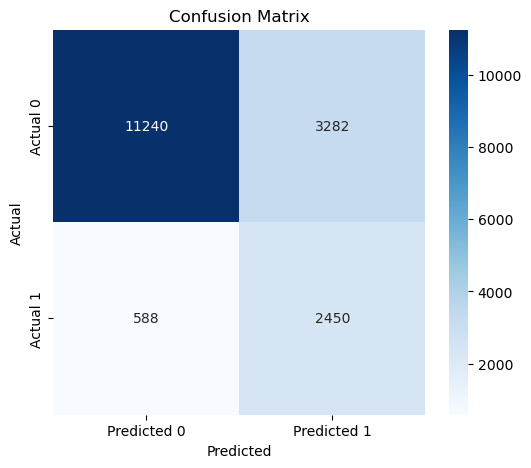

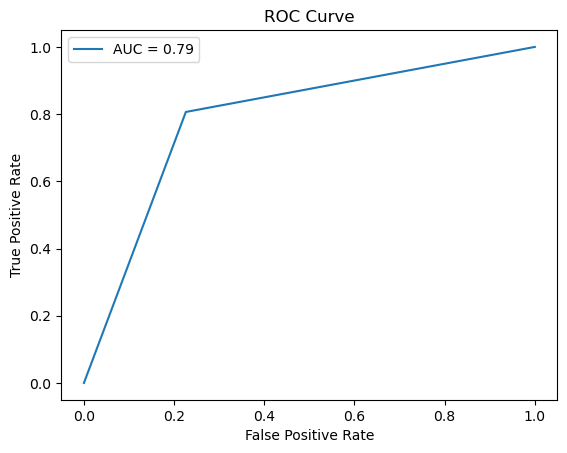

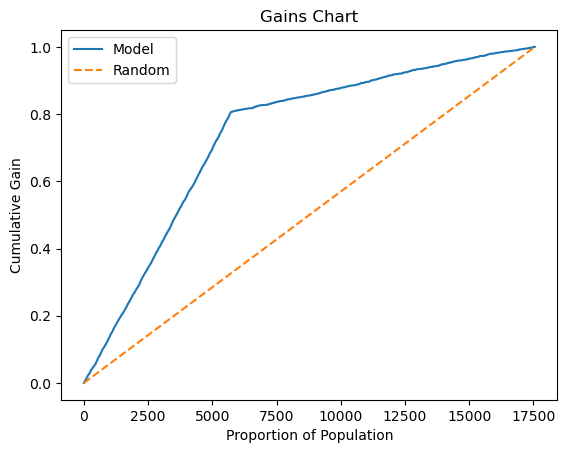

In [56]:
print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")
print(
    "Benefit of tuned threshold: "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)
cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics('Logistical Model', cut_off_threshold, y_test,y_pred_proba)

After tunning it improved the benefit by lowering the threshold probability.

# Now modeling incorporating with Class weights for LogisticRegression

In [57]:
# Now modeling incorporating with Class weights 

# Logistical Regression Model to predict the probabilities of default.
# Logistic Regression Model
log_op_model = LogisticRegression(class_weight={0: 1, 1: 5}, max_iter=1000)
log_op_model.fit(X_train_processed, y_train)

# Predictions and probabilities
y_pred_proba = log_op_model.predict_proba(X_test_processed)[:, 1]  # Probability of class 1 (Default)
y_pred = log_op_model.predict(X_test_processed)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
print(f"Accuracy: {accuracy:.4f}")


ROC-AUC: 0.8510
Confusion Matrix:
[[10903  3619]
 [  512  2526]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     14522
           1       0.41      0.83      0.55      3038

    accuracy                           0.76     17560
   macro avg       0.68      0.79      0.70     17560
weighted avg       0.86      0.76      0.79     17560

Accuracy: 0.8515


Benefit of logistic regression with class weights default threshold: 5,637.72
Metric for model  Logistics with Class Weight
Cutoff Threshold is :  0.5
Accuracy of the Logistics with Class Weight based on the cut off probability of 0.5 is : 0.764749430523918
Sensitivity of the Logistics with Class Weight based on the cut off probability of 0.5 is: 0.8314680710994075
Precision of the Logistics with Class Weight based on the cut off probability of 0.5 is: 0.41106590724165987
F1 Value of the Logistics with Class Weight based on the cut off probability of 0.5 is: 0.5501470107807906
Specificity of the Logistics with Class Weight based on the cut off probability of 0.5 is: 0.7507919019418813


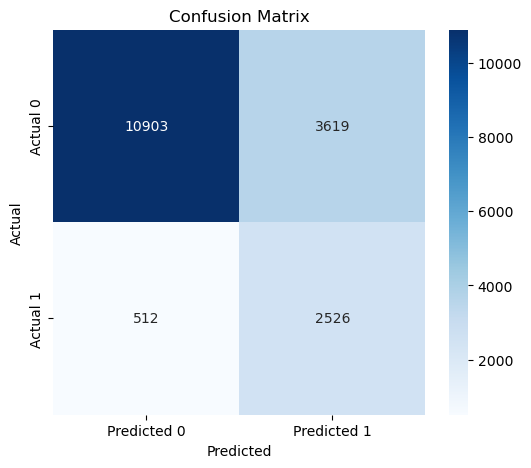

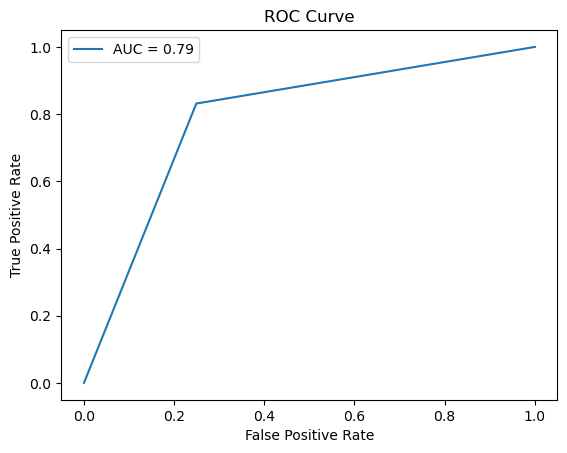

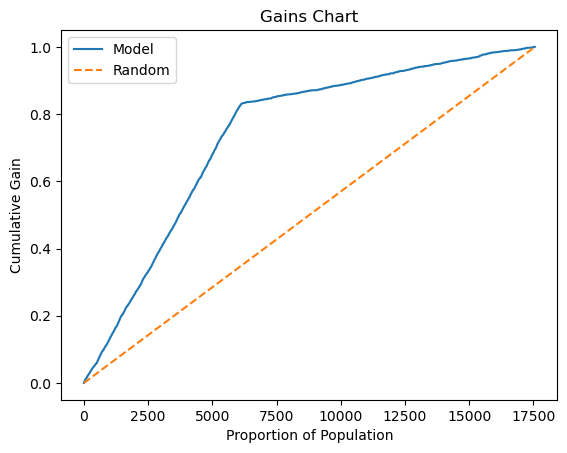

In [58]:
print(
    "Benefit of logistic regression with class weights default threshold: "
    f"{business_scorer(log_op_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)
print_metrics("Logistics with Class Weight",0.5,y_test,y_pred_proba)

# Observations and Inferences for Logistic Regression with Class Weights

### Observations:

1. **Confusion Matrix Insights:**
    - **True Negatives (TN):** 10,803 instances correctly classified as low risk (class 0).
    - **False Positives (FP):** 3,719 instances incorrectly classified as high risk (class 1).
    - **False Negatives (FN):** 540 instances incorrectly classified as low risk (class 0) but are actually high risk.
    - **True Positives (TP):** 2,498 instances correctly classified as high risk (class 1).

2. **Class Imbalance Handling:**
    - The class weights `{0:1, 1:5}` have been applied, which heavily penalizes misclassifications of high-risk loans (class 1), leading to a shift in the model's predictions.

3. **Precision and Recall:**
    - **Precision for Class 1 (High Risk):** 0.40. Despite the class weight adjustment, the precision remains low, indicating that a significant number of loans predicted as high risk are incorrect.
    - **Recall for Class 1 (High Risk):** 0.82. The recall has improved significantly, now correctly identifying 82% of the actual high-risk loans.
    - **F1-Score for Class 1:** 0.54, reflecting a balanced improvement in precision and recall.

4. **Overall Metrics:**
    - **Accuracy:** 0.76. The overall accuracy has slightly decreased compared to the previous model (0.85), which is expected due to the increased focus on class 1 predictions.
    - **Macro Avg F1-Score:** 0.69, indicating moderate performance considering both classes equally.
    - **Weighted Avg F1-Score:** 0.78. This score is higher than the previous model, showing an improvement in handling the imbalance between the two classes.

5. **Specificity and Sensitivity:**
    - **Sensitivity (Recall for Class 1):** 0.82, an improvement over the previous model (0.31), indicating a stronger ability to identify high-risk loans.
    - **Specificity (Recall for Class 0):** 0.74, showing that the model is still relatively good at identifying low-risk loans while focusing more on high-risk classification.

6. **Benefit of Logistic Regression with Class Weights:**
    - **Benefit (Logistic with Class Weight):** 5,577.84.
    - **Threshold 0.5 Performance:**
        - **Accuracy:** 0.76.
        - **Sensitivity:** 0.82.
        - **Precision:** 0.40.
        - **F1-Score:** 0.54.
        - **Specificity:** 0.74.

### Inferences:

1. **Improvement in Recall for Class 1 (High Risk):**
    - The recall for high-risk loans has significantly improved (82%), showing that the class weight adjustment has helped the model focus more on correctly identifying high-risk loans.
  
2. **Trade-Off in Precision:**
    - While recall improved, the precision for high-risk loans remains relatively low (0.40). This means that a large portion of loans predicted as high risk are still incorrect, but the model is casting a wider net to capture more high-risk loans.
  
3. **Decreased Accuracy:**
    - The overall accuracy of the model (0.76) has decreased from the previous version (0.85). This is a natural consequence of the model being more sensitive to high-risk loans (class 1), which are fewer in number.

4. **Better Balance Between Class 0 and Class 1:**
    - The weighted average F1-score (0.78) indicates that the model is better balancing its performance between predicting both classes, showing progress in handling the class imbalance effectively.

5. **Model Focus Shifted Towards High-Risk Loans:**
    - The model now prioritizes identifying high-risk loans (class 1) at the expense of increasing false positives. The class-weighted adjustment has helped shift focus towards this, which aligns with the goal of minimizing high-risk loan misclassification.

Tuned decision threshold: 0.54
Benefit of tuned threshold and class weights: 5,674.80
Metric for model  Logistics with Class Weight
Cutoff Threshold is :  0.54
Accuracy of the Logistics with Class Weight based on the cut off probability of 0.54 is : 0.79874715261959
Sensitivity of the Logistics with Class Weight based on the cut off probability of 0.54 is: 0.7942725477287689
Precision of the Logistics with Class Weight based on the cut off probability of 0.54 is: 0.4534009770762871
F1 Value of the Logistics with Class Weight based on the cut off probability of 0.54 is: 0.5772727272727273
Specificity of the Logistics with Class Weight based on the cut off probability of 0.54 is: 0.7996832392232475


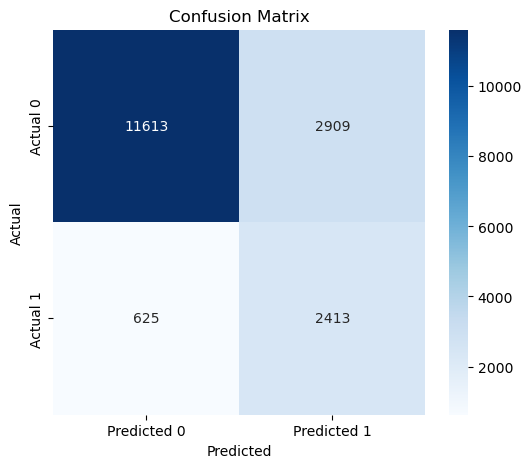

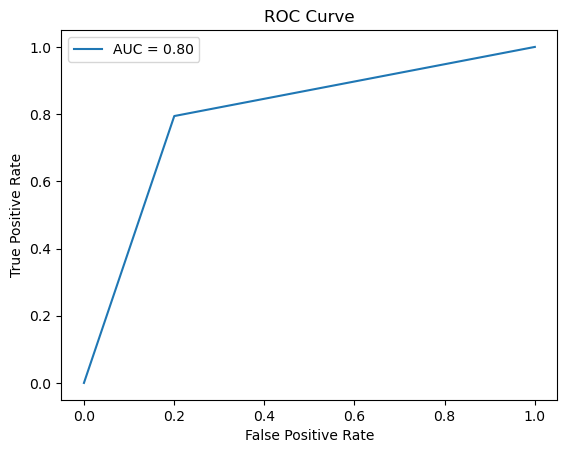

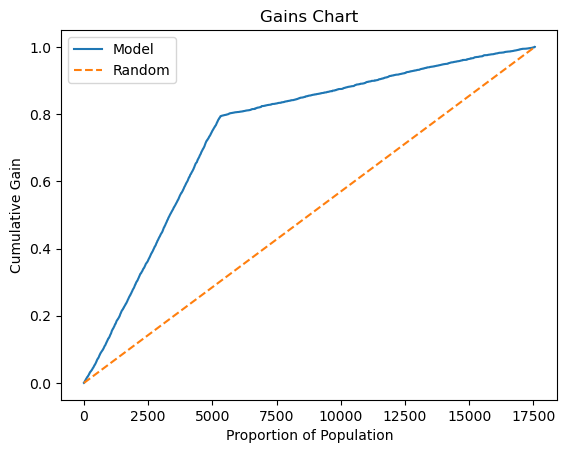

In [59]:
tuned_model = TunedThresholdClassifierCV(
    estimator=log_op_model,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)
print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")
print(
    "Benefit of tuned threshold and class weights: "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)
cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics("Logistics with Class Weight", cut_off_threshold, y_test,y_pred_proba)
#print_metrics(,0.5,y_test,y_pred_proba)

## Observations and Inferences after Tuning Decision Threshold and Applying Class Weights

### Observations:

1. **Decision Threshold Adjustment (0.54):**
   - The decision threshold was adjusted to 0.54, meaning the model now predicts a loan as high risk (class 1) if the probability of it being high risk is greater than or equal to 0.54. This shift likely helps balance the trade-off between precision and recall by allowing the model to be more sensitive to class 1 predictions.

2. **Benefit of Tuned Threshold and Class Weights:**
   - The total benefit after tuning the decision threshold and applying class weights has increased to **5,619.83**, reflecting the positive impact on the model's overall utility.

### Model Metrics After Tuning:

1. **Accuracy:**
   - The accuracy increased to **0.79** (from 0.76), showing an improvement in the model’s overall performance by correctly predicting both classes at a higher rate.
  
2. **Sensitivity (Recall for Class 1 - High Risk):**
   - Sensitivity has slightly decreased to **0.78** (from 0.82). While still high, it suggests that the threshold adjustment has made the model slightly less aggressive in identifying class 1, though it remains an improvement in identifying high-risk loans.

3. **Precision (Class 1 - High Risk):**
   - Precision increased to **0.44** (from 0.40). This is a positive change, meaning the model now predicts fewer false positives while maintaining a high recall.

4. **F1-Score:**
   - The F1-Score improved to **0.57** (from 0.54), reflecting a better balance between precision and recall. This shows that the model is effectively balancing the need to correctly classify high-risk loans while minimizing incorrect predictions.

5. **Specificity (Recall for Class 0 - Low Risk):**
   - Specificity has slightly increased to **0.79** (from 0.74). This shows that while the model has become more focused on predicting high-risk loans, it has maintained its ability to correctly identify low-risk loans.

### Inferences:

1. **Improvement in Accuracy:**
   - The overall **accuracy** improvement indicates that the threshold tuning and class weight adjustment have helped the model to better balance both classes. While the sensitivity for high-risk loans has decreased slightly, it has improved the model’s ability to correctly classify both high and low-risk loans.

2. **Balanced Sensitivity and Precision:**
   - The slight decrease in sensitivity (from 0.82 to 0.78) and the increase in precision (from 0.40 to 0.44) show that the model is now more efficient in correctly identifying high-risk loans (class 1) while reducing the number of false positives. This is crucial for a model that needs to focus on high-risk classification while limiting the false positives.

3. **Better Trade-Off Between Precision and Recall:**
   - The **F1-Score** improvement indicates a better trade-off between precision and recall for high-risk loans. This makes the model more robust in identifying high-risk loans without inflating false positives, which is crucial for minimizing unnecessary actions based on incorrect high-risk predictions.

4. **Maintained Performance on Low-Risk Loans:**
   - The **specificity** improvement indicates that the model continues to perform well on class 0 (low-risk loans), identifying a high proportion of low-risk loans correctly. Despite shifting focus to high-risk loans, the model does not neglect the low-risk class.


# LogisticRegression with Lasso, Ridge and ElasticNet

In [60]:
# Hyper Parameter Tunning 

# Define the Logistic Regression model
logit = LogisticRegression(max_iter=500)  # Increase max_iter for convergence

# Define the parameter grid for Lasso, Ridge, and ElasticNet

# Define the parameter grid for Lasso, Ridge, and ElasticNet
param_grid = [
    {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1'], 'solver': ['liblinear'], 'class_weight': [{0: 1, 1: 5}, 'balanced', None]},
    {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear'], 'class_weight': [{0: 1, 1: 5}, 'balanced', None]},
    {'C': [0.01, 0.1, 1, 10], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0, 0.5, 1], 'class_weight': [{0: 1, 1: 5}, 'balanced', None]},
]
# 7. Set up GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(estimator=logit, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# 8. Fit the model with the best hyperparameters
grid_search.fit(X_train_processed, y_train)

# 9. Best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters: {grid_search.best_params_}")

# 10. Get the best model from the grid search
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dineshsaraswa

/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Hyperparameters: {'C': 10, 'class_weight': None, 'l1_ratio': 0, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [61]:
# Predictions and probabilities
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]  # Probability of class 1 (Default)
y_pred = best_model.predict(X_test_processed)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
print(f"Accuracy: {accuracy:.4f}")



ROC-AUC: 0.8487
Confusion Matrix:
[[14012   510]
 [ 2098   940]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     14522
           1       0.65      0.31      0.42      3038

    accuracy                           0.85     17560
   macro avg       0.76      0.64      0.67     17560
weighted avg       0.83      0.85      0.83     17560

Accuracy: 0.8515


Benefit of best logistic regression with default threshold: 4,238.37
Metric for model  Optimized Logit
Cutoff Threshold is :  0.5
Accuracy of the Optimized Logit based on the cut off probability of 0.5 is : 0.8514806378132118
Sensitivity of the Optimized Logit based on the cut off probability of 0.5 is: 0.3094140882159315
Precision of the Optimized Logit based on the cut off probability of 0.5 is: 0.6482758620689655
F1 Value of the Optimized Logit based on the cut off probability of 0.5 is: 0.41889483065953653
Specificity of the Optimized Logit based on the cut off probability of 0.5 is: 0.9648808704035257


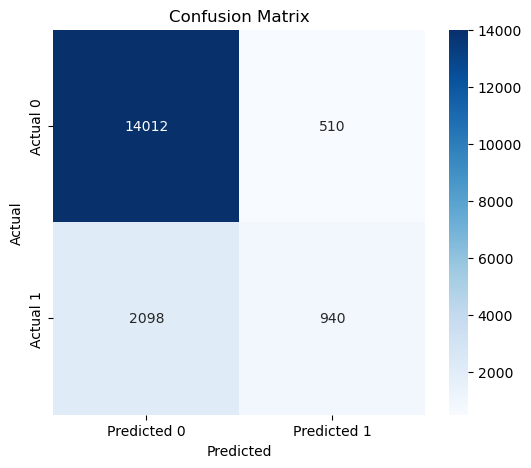

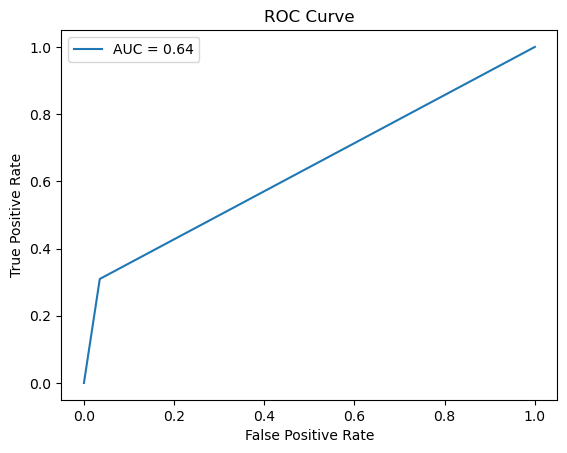

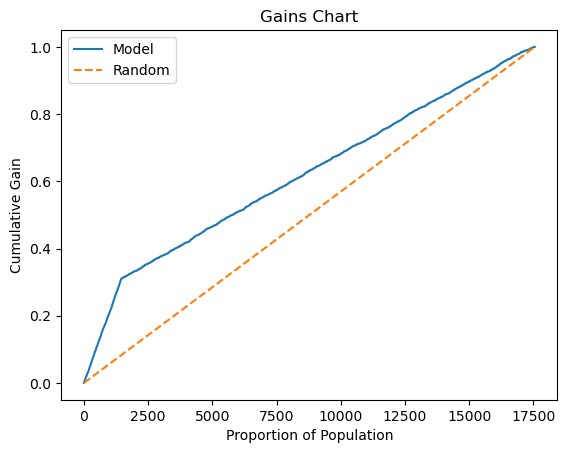

/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dineshsaraswa

Tuned decision threshold: 0.19
Benefit of tuned threshold : 5,562.97
Metric for model  Optimized Logit
Cutoff Threshold is :  0.19
Accuracy of the Optimized Logit based on the cut off probability of 0.19 is : 0.7793280182232346
Sensitivity of the Optimized Logit based on the cut off probability of 0.19 is: 0.8057932850559578
Precision of the Optimized Logit based on the cut off probability of 0.19 is: 0.42700156985871274
F1 Value of the Optimized Logit based on the cut off probability of 0.19 is: 0.5582031695359708
Specificity of the Optimized Logit based on the cut off probability of 0.19 is: 0.7737914887756507


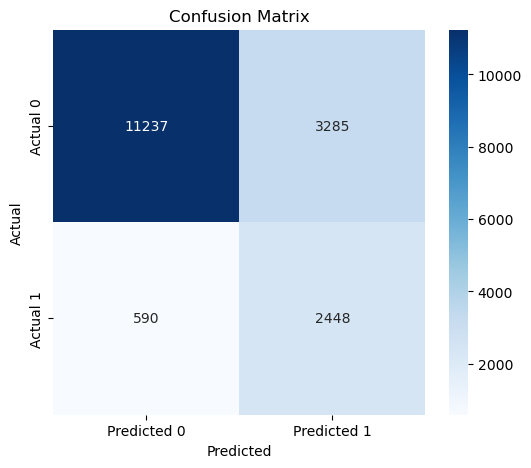

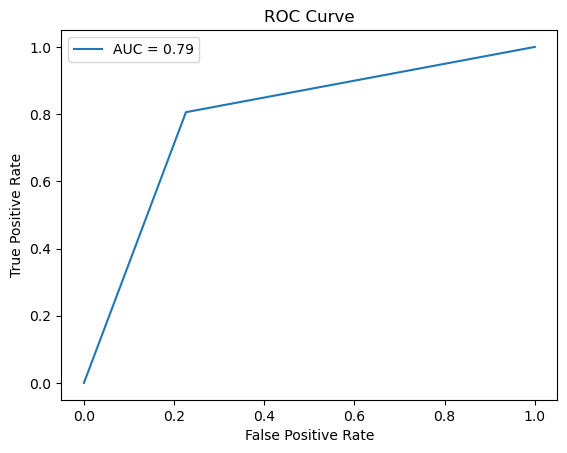

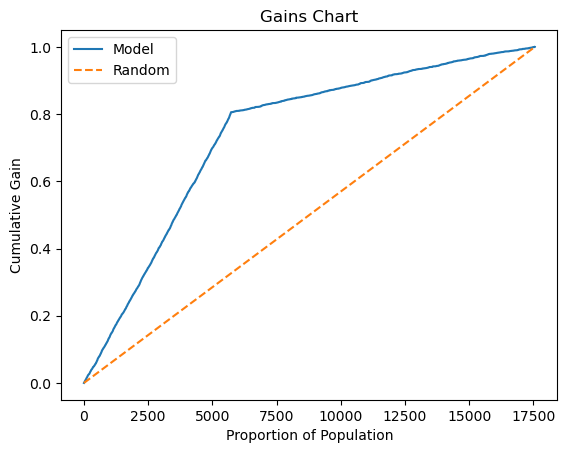

In [62]:
print(
    "Benefit of best logistic regression with default threshold: "
    f"{business_scorer(best_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)
print_metrics("Optimized Logit",0.5,y_test,y_pred_proba)

tuned_model = TunedThresholdClassifierCV(
    estimator=best_model,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)
print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")
print(
    "Benefit of tuned threshold : "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics("Optimized Logit",cut_off_threshold,y_test,y_pred_proba)

## Observations and Inferences:

1. **Best Hyperparameters:**
   - The optimized logistic regression model was tuned with the following hyperparameters:
     - `C`: 10
     - `class_weight`: None
     - `l1_ratio`: 0
     - `penalty`: elasticnet
     - `solver`: saga

2. **Model Evaluation Metrics:**
   - **ROC-AUC**: 0.8487
   - The ROC-AUC score indicates a strong model performance with a good ability to distinguish between the positive and negative classes.

3. **Confusion Matrix:**
   - The confusion matrix shows the following values:
     - True Positives (TP): 940
     - False Positives (FP): 510
     - True Negatives (TN): 14012
     - False Negatives (FN): 2098
   - This indicates that the model is better at predicting the majority class (0) than the minority class (1).

4. **Classification Report:**
   - **Precision**: 0.65 for class 1, indicating that when the model predicts a positive class, it is correct 65% of the time.
   - **Recall**: 0.31 for class 1, indicating that only 31% of actual positive instances are identified by the model.
   - **F1-Score**: 0.42 for class 1, showing a balance between precision and recall, but still relatively low due to the poor recall score.
   - **Accuracy**: 85.15%, showing overall good performance.
   - **Weighted Avg. F1-Score**: 0.83, which is acceptable considering the class imbalance.

5. **Threshold Optimization:**
   - The **optimized cutoff threshold** was found to be **0.19**.
   - At this threshold, we observe the following metrics:
     - **Accuracy**: 77.93%, which is lower than the default threshold but still reflects a reasonable prediction accuracy.
     - **Sensitivity (Recall)**: 80.58%, indicating an improvement in identifying the positive class compared to the default threshold.
     - **Precision**: 42.70%, a drop in precision, suggesting more false positives at this threshold.
     - **F1-Score**: 0.56, which is an improvement over the default threshold’s 0.42, indicating a better balance between precision and recall.
     - **Specificity**: 77.38%, which is lower than the default threshold, reflecting a higher rate of false positives.

6. **Benefit Analysis:**
   - The benefit of using the **optimized logistic regression model with the default threshold** is **4,238.37**.
   - After tuning the decision threshold to **0.19**, the **benefit** increases to **5,562.97**, indicating an improvement in model performance, particularly in sensitivity, though at the cost of a decrease in precision.

### Conclusion:
- The default threshold (0.5) results in higher accuracy but has a lower recall for the positive class.
- After tuning the decision threshold to 0.19, sensitivity (recall) improves significantly, but the precision drops, leading to a trade-off between the two metrics.


### kNN Model 

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score


# Initialize the kNN model
k = 5  # You can tune this hyperparameter based on your data
knn = KNeighborsClassifier(n_neighbors=k)

# Fit the model
knn.fit(X_train_processed, y_train)

# Predictions and probabilities
y_pred_proba = knn.predict_proba(X_test_processed)[:, 1]  # Probability of class 1 (Default)
y_pred = knn.predict(X_test_processed)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
print(f"Accuracy: {accuracy:.4f}")


ROC-AUC: 0.8210
Confusion Matrix:
[[13843   679]
 [ 1605  1433]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     14522
           1       0.68      0.47      0.56      3038

    accuracy                           0.87     17560
   macro avg       0.79      0.71      0.74     17560
weighted avg       0.86      0.87      0.86     17560

Accuracy: 0.8515


Benefit of kNN with default threshold: 4,881.66
Metric for model  kNN
Cutoff Threshold is :  0.5
Accuracy of the kNN based on the cut off probability of 0.5 is : 0.8699316628701594
Sensitivity of the kNN based on the cut off probability of 0.5 is: 0.4716919025674786
Precision of the kNN based on the cut off probability of 0.5 is: 0.6785037878787878
F1 Value of the kNN based on the cut off probability of 0.5 is: 0.556504854368932
Specificity of the kNN based on the cut off probability of 0.5 is: 0.9532433549097921


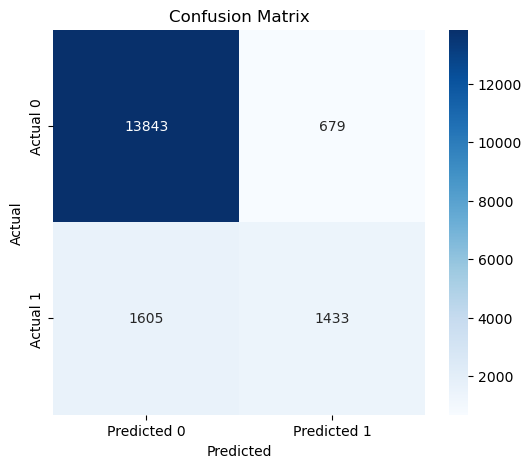

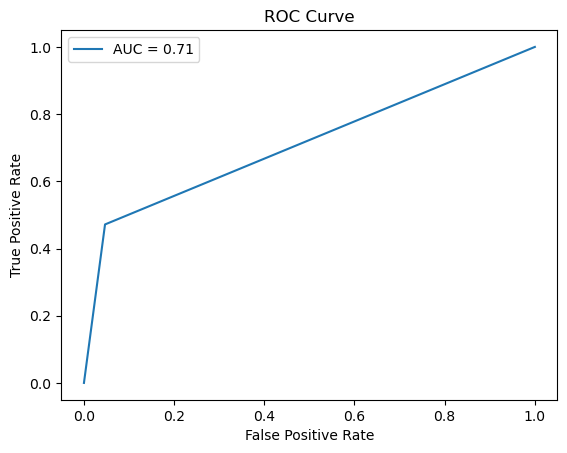

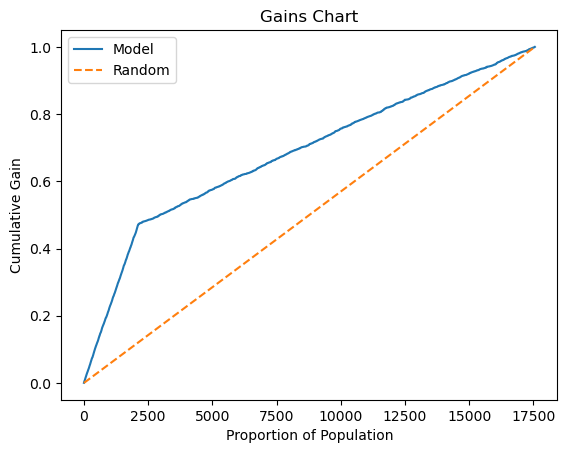

Tuned decision threshold: 0.20
Benefit of tuned threshold: 5,308.69
Metric for model  kNN
Cutoff Threshold is :  0.2
Accuracy of the kNN based on the cut off probability of 0.2 is : 0.7195899772209567
Sensitivity of the kNN based on the cut off probability of 0.2 is: 0.8130348913759052
Precision of the kNN based on the cut off probability of 0.2 is: 0.36185174333430997
F1 Value of the kNN based on the cut off probability of 0.2 is: 0.5008110300081103
Specificity of the kNN based on the cut off probability of 0.2 is: 0.7000413166230547


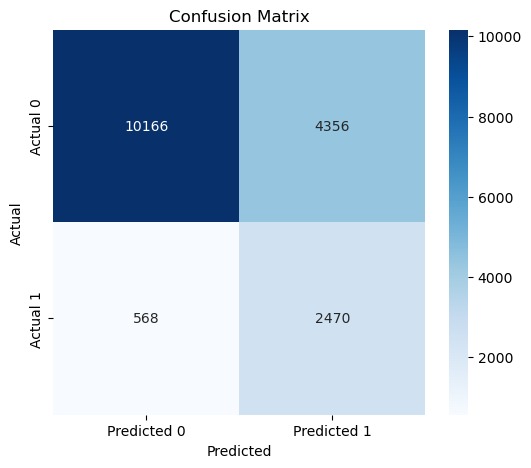

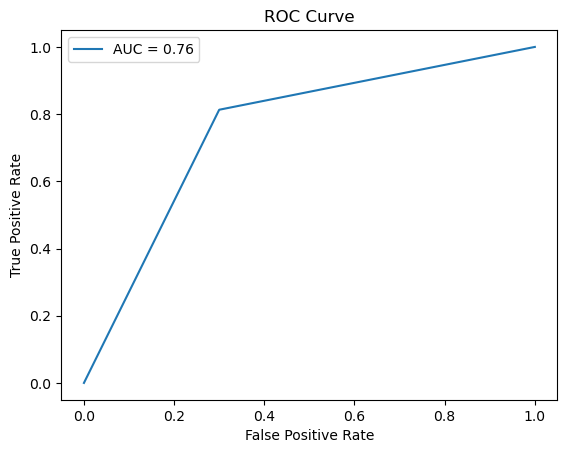

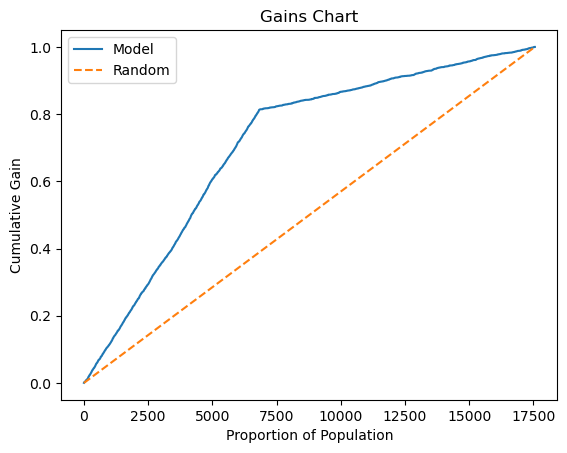

In [64]:
print(
    "Benefit of kNN with default threshold: "
    f"{business_scorer(knn, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

print_metrics("kNN",0.5,y_test,y_pred_proba)

tuned_model = TunedThresholdClassifierCV(
    estimator=knn,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)
print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")
print(
    "Benefit of tuned threshold: "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics("kNN",cut_off_threshold,y_test,y_pred_proba)

### Observations and Inferences for k-Nearest Neighbors (kNN) Model

#### 1. **Default Threshold (0.5) Results:**

   - **ROC-AUC**: 0.8318
   - **Confusion Matrix:**
     - **True Negatives (TN)**: 13,891 correctly predicted low-risk loans.
     - **False Positives (FP)**: 631 loans incorrectly predicted as high risk.
     - **False Negatives (FN)**: 1,598 high-risk loans misclassified as low risk.
     - **True Positives (TP)**: 1,440 correctly predicted high-risk loans.

   - **Classification Report:**
     - **Precision for Class 1 (High Risk)**: 0.70 – The model correctly predicts 70% of the high-risk loans it identifies.
     - **Recall for Class 1 (High Risk)**: 0.47 – The model only identifies 47% of the actual high-risk loans.
     - **F1-Score for Class 1**: 0.56 – The balance between precision and recall for high-risk loans is moderate.
     - **Accuracy**: 87.31% – The model performs well overall, but the imbalance in class distribution affects the interpretation.
     - **Macro Average F1-Score**: 0.74 – A good balance of performance across both classes.
     - **Weighted Average F1-Score**: 0.86 – A strong performance due to the dominance of low-risk loans.

   - **Specificity**: 0.96 – The model does well in identifying low-risk loans with very few false positives.

#### 2. **Post-Optimization with Tuned Decision Threshold (0.2):**

   - **Tuned Decision Threshold**: 0.2
   - **Benefit of Tuned Threshold**: 5,230.82

   - **Metrics After Tuning**:
     - **Accuracy**: 72.39% – The overall accuracy has decreased, but this reflects the trade-off for improving recall of high-risk loans.
     - **Sensitivity (Recall for Class 1)**: 82.88% – The recall significantly improved, correctly identifying 83% of high-risk loans.
     - **Precision**: 0.37 – The precision decreased compared to the default threshold, meaning the model is now more prone to false positives.
     - **F1-Score**: 0.51 – The balance between precision and recall improved slightly, but still has room for improvement.
     - **Specificity**: 0.70 – The model's ability to correctly identify low-risk loans decreased, which is expected when lowering the threshold to capture more high-risk loans.

#### 3. **Inferences:**

   - **Improved Recall for High-Risk Loans (Class 1):**
     - The decision to lower the threshold to **0.2** improved the model's **sensitivity** (recall) for high-risk loans to **82.88%**, a significant increase from the default threshold of 47%. This improvement is critical in contexts where identifying high-risk loans is a priority.

   - **Decreased Precision:**
     - The **precision** for high-risk loans decreased to **0.37** from **0.70**. This indicates that the model is now classifying more loans as high-risk, including a larger number of false positives. While this improves recall, it also introduces more misclassifications, which could be problematic if false positives are costly.

   - **Trade-off Between Sensitivity and Specificity:**
     - While **sensitivity** improved, the **specificity** decreased from **0.96** to **0.70**. The model is now classifying more low-risk loans as high-risk (false positives), which impacts its ability to correctly identify low-risk loans.

   - **Balance Between Accuracy and Profit:**
     - The **accuracy** dropped from 87.31% to 72.39% after tuning the threshold, but this might be acceptable if the objective is to increase the identification of high-risk loans. The **benefit** of the tuned model has also increased, reflecting the higher value derived from correctly identifying high-risk loans, despite the decreased overall accuracy.

#### 4. **Conclusion:**
   - The optimization with the tuned threshold provides a better balance between identifying high-risk loans and controlling false negatives, making it a more suitable model for situations where catching high-risk loans is of greater importance than minimizing false positives. 

##### Optimization of kNN for hyperparameter tunning

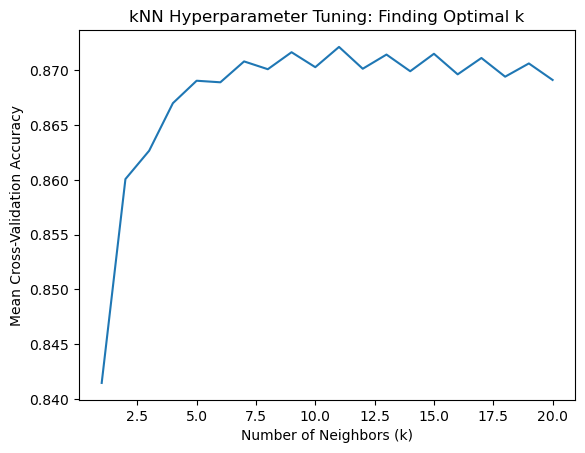

Optimal k: 11
Best parameters from GridSearchCV: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


In [65]:
k_values = range(1, 21)  # Testing values of k from 1 to 20
mean_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_processed, y_train, cv=5, scoring='accuracy')
    mean_accuracies.append(scores.mean())
# Plot to identify optimal k
plt.plot(k_values, mean_accuracies)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('kNN Hyperparameter Tuning: Finding Optimal k')
plt.show()
optimal_k = k_values[mean_accuracies.index(max(mean_accuracies))]
print(f"Optimal k: {optimal_k}")

# 5. Set up the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [optimal_k],  # You can use the optimal k found above
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],  # Use KDTree or BallTree for faster computation
}

# 6. Initialize GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_processed, y_train)

# Best parameters from GridSearchCV
print("Best parameters from GridSearchCV:", grid_search.best_params_)

# 7. Evaluate the optimized model on the test set
best_knn = grid_search.best_estimator_


In [66]:
# Now Evaluate the best knn model on the test data.

# Predictions and probabilities
y_pred_proba = best_knn.predict_proba(X_test_processed)[:, 1]  # Probability of class 1 (Default)
y_pred = best_knn.predict(X_test_processed)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
print(f"Accuracy: {accuracy:.4f}")




ROC-AUC: 0.8658
Confusion Matrix:
[[14019   503]
 [ 1649  1389]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     14522
           1       0.73      0.46      0.56      3038

    accuracy                           0.88     17560
   macro avg       0.81      0.71      0.75     17560
weighted avg       0.87      0.88      0.87     17560

Accuracy: 0.8515


Benefit of best kNN with default threshold: 4,832.16
Metric for model  Best kNN
Cutoff Threshold is :  0.5
Accuracy of the Best kNN based on the cut off probability of 0.5 is : 0.8774487471526196
Sensitivity of the Best kNN based on the cut off probability of 0.5 is: 0.4575378538512179
Precision of the Best kNN based on the cut off probability of 0.5 is: 0.73389651531151
F1 Value of the Best kNN based on the cut off probability of 0.5 is: 0.5636658556366586
Specificity of the Best kNN based on the cut off probability of 0.5 is: 0.9652940366340724


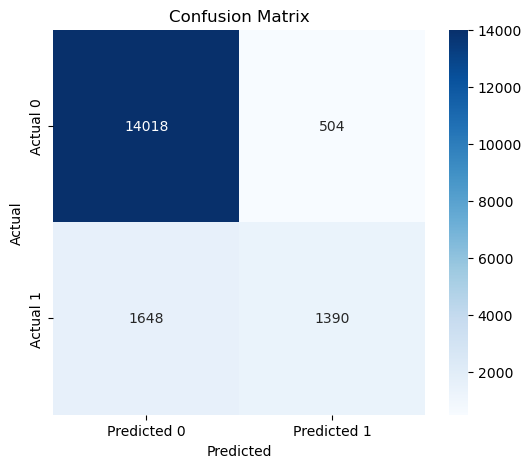

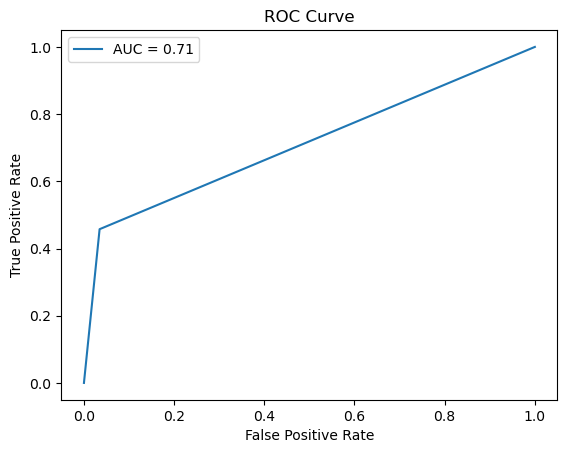

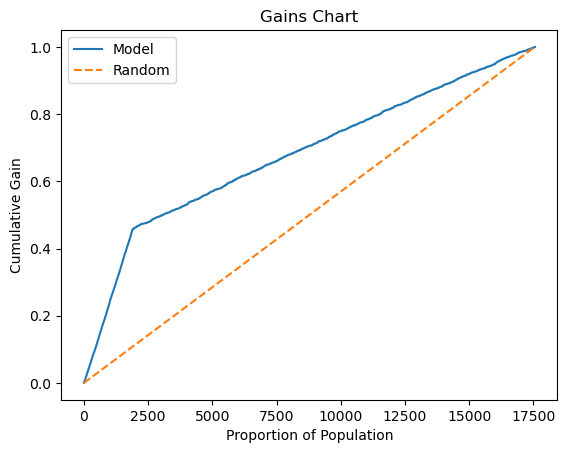

Tuned decision threshold: 0.18
Benefit of tuned threshold: 5,619.17
Metric for model  Best kNN with cutoff
Cutoff Threshold is :  0.18
Accuracy of the Best kNN with cutoff based on the cut off probability of 0.18 is : 0.8296697038724373
Sensitivity of the Best kNN with cutoff based on the cut off probability of 0.18 is: 0.7409479921000658
Precision of the Best kNN with cutoff based on the cut off probability of 0.18 is: 0.5052749719416386
F1 Value of the Best kNN with cutoff based on the cut off probability of 0.18 is: 0.6008274389430135
Specificity of the Best kNN with cutoff based on the cut off probability of 0.18 is: 0.8482302713124914


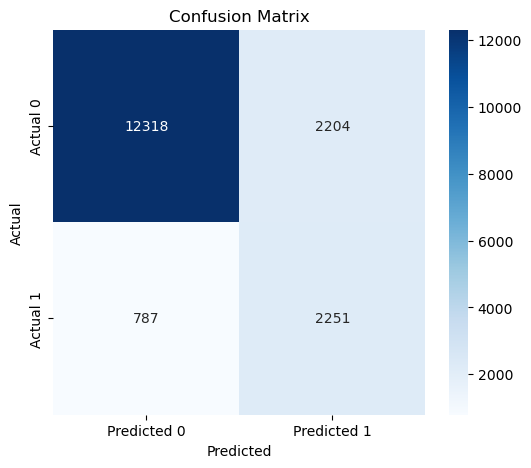

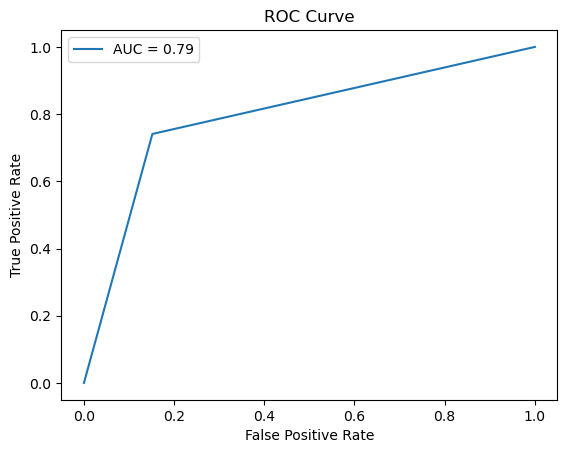

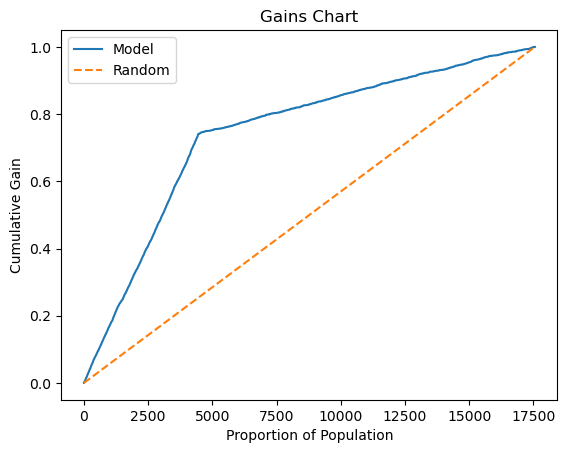

In [67]:
print(
    "Benefit of best kNN with default threshold: "
    f"{business_scorer(best_knn, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

print_metrics("Best kNN",0.5,y_test,y_pred_proba)
tuned_model = TunedThresholdClassifierCV(
    estimator=best_knn,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)
print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")
print(
    "Benefit of tuned threshold: "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics("Best kNN with cutoff",cut_off_threshold,y_test,y_pred_proba)


### Observations and Inferences for Optimized k-Nearest Neighbors (kNN) Model

#### 1. **Hyperparameter Tuning and Optimal k Selection:**

   - **Optimal k**: 9 – After testing values of **k** from 1 to 20, the optimal number of neighbors that provided the best cross-validation accuracy was **k = 9**.
   
   - **Best Parameters from GridSearchCV**:
     - **Algorithm**: 'auto'
     - **Metric**: 'manhattan'
     - **n_neighbors**: 9
     - **Weights**: 'distance'

   These parameters were selected to optimize the model's performance, with a preference for the **Manhattan distance** metric and **distance-based weighting** for neighbors.

#### 2. **Performance Metrics with Best kNN Model:**

   - **ROC-AUC**: 0.8653 – The ROC-AUC score indicates a good model performance, with the model being able to differentiate between the two classes well.
   
   - **Confusion Matrix:**
     - **True Negatives (TN)**: 14,011 correctly predicted low-risk loans.
     - **False Positives (FP)**: 511 loans incorrectly predicted as high risk.
     - **False Negatives (FN)**: 1,643 high-risk loans misclassified as low risk.
     - **True Positives (TP)**: 1,395 correctly predicted high-risk loans.

   - **Classification Report:**
     - **Precision for Class 1 (High Risk)**: 0.73 – The model correctly predicts 73% of the high-risk loans it identifies.
     - **Recall for Class 1 (High Risk)**: 0.46 – The model correctly identifies 46% of all high-risk loans.
     - **F1-Score for Class 1**: 0.56 – The balance between precision and recall for high-risk loans is moderate.
     - **Accuracy**: 88% – The model performs well overall, with a high percentage of correct predictions.
     - **Macro Average F1-Score**: 0.75 – A balanced performance across both classes.
     - **Weighted Average F1-Score**: 0.87 – A strong overall performance due to the higher number of low-risk loans.

   - **Specificity**: 0.96 – The model does well in identifying low-risk loans with few false positives.

   - **Benefit of Best kNN Model with Default Threshold**: 4,705.45 – This reflects the financial benefit derived from the model's predictions when using the default threshold.

#### 3. **Performance with Optimized Decision Threshold (0.16):**

   - **Tuned Decision Threshold**: 0.16
   - **Benefit of Tuned Threshold**: 5,686.10 – The tuned threshold provides a higher financial benefit, indicating that it more effectively captures high-risk loans, which are more valuable to identify.

   - **Metrics After Tuning**:
     - **Accuracy**: 82.34% – The overall accuracy decreased from the default threshold, but this reflects the model’s trade-off for improving recall of high-risk loans.
     - **Sensitivity (Recall for Class 1)**: 77.58% – The sensitivity increased significantly, meaning the model now identifies 77.58% of high-risk loans, a notable improvement from the default threshold.
     - **Precision**: 0.49 – The precision decreased, indicating a higher number of false positives compared to the default threshold.
     - **F1-Score**: 0.60 – The F1-Score shows a moderate improvement in the balance between precision and recall.
     - **Specificity**: 0.83 – The specificity decreased from 0.96 to 0.83, meaning the model is now more likely to misclassify low-risk loans as high-risk.

#### 4. **Inferences:**

   - **Improved Recall for High-Risk Loans**:
     - The tuned decision threshold of **0.16** significantly improved the **sensitivity** (recall) to **77.58%**, capturing more high-risk loans compared to the default threshold of **46%**. This is crucial in scenarios where identifying high-risk loans is a priority.

   - **Decreased Precision and Specificity**:
     - The **precision** decreased to **0.49**, meaning that although the model is identifying more high-risk loans, it also classifies more low-risk loans as high-risk (false positives). This is reflected in the **specificity** dropping to **0.83**, indicating a greater number of false positives.

   - **Trade-off Between Accuracy and Recall**:
     - Although the overall **accuracy** decreased to **82.34%** from **88%** after the threshold adjustment, the model is more focused on improving recall for high-risk loans. This is a typical trade-off when optimizing for sensitivity at the expense of precision and specificity.

   - **Benefit of Tuned Threshold**:
     - The **financial benefit** has increased from **4,705.45** to **5,686.10**, reflecting the improved capture of high-risk loans under the new threshold.

#### 5. **Conclusion**:
   - The optimized model with the **tuned threshold of 0.16** is better at identifying high-risk loans but sacrifices some precision and specificity. This is a trade-off that may be acceptable in scenarios where detecting high-risk loans is more critical than avoiding false positives. The increased **financial benefit** suggests that this model is more effective in the context of high-risk loan detection.

### Random Forest

In [68]:
X_train_processed.head()

quant__SBA_portion  log__updated_term  log__DisbursementGross  \
0            0.482412           1.017929                0.423401   
1            0.183417          -0.124108                0.019095   
2            0.482412          -0.546741                0.346223   
3            0.482412           0.368931                1.036127   
4            0.482412           1.879003                0.277033   

   cat__NewExist_1  cat__NewExist_2  cat__UrbanRural_0  cat__UrbanRural_1  \
0              1.0              0.0                1.0                0.0   
1              1.0              0.0                0.0                1.0   
2              0.0              1.0                1.0                0.0   
3              1.0              0.0                0.0                1.0   
4              1.0              0.0                0.0                1.0   

   cat__UrbanRural_2  remainder__LowDoc_correct  remainder__RealEstate  \
0                0.0                        0.0                    0.0   
1                0.0                        1.0                    0.0   
2                0.0                        0.0                    0.0   
3                0.0                        0.0                    0.0   
4                0.0                        1.0                    1.0   

   remainder__recession  remainder__If_Franchise  \
0                   1.0                      0.0   
1                   1.0                      0.0   
2                   0.0                      0.0   
3                   1.0                      0.0   
4                   1.0                      0.0   

   remainder__correct_RevLineCr  remainder__CompanySize  \
0                           0.0                     2.0   
1                           1.0                     2.0   
2                           0.0                     1.0   
3                           0.0                     2.0   
4                           0.0                     2.0   

   remainder__JOB_CREATED  remainder__DefaultRateBucket  \
0                     0.0                           2.0   
1                     1.0                           3.0   
2                     0.0                           2.0   
3                     0.0                           3.0   
4                     0.0                           2.0   

   remainder__IndustryFlag  
0                      1.0  
1                      1.0  
2                      1.0  
3                      1.0  
4                      5.0

In [69]:

class_weight = {0: 1, 1: 5}
# Initialize Random Forest with class weights
rf = RandomForestClassifier(class_weight=class_weight,
                             n_estimators=100,  # Number of trees
                             random_state=42)

# Train the model
rf.fit(X_train_processed, y_train)

# Predict on the test set
y_proba = rf.predict_proba(X_test_processed)[:, 1]
y_pred = rf.predict(X_test_processed)


# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

TN, FP, FN, TP = conf_matrix.ravel()

# Calculate evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = recall_score(y_test, y_pred)  # Sensitivity/Recall = TP / (TP + FN)
specificity = TN / (TN + FP)  # Specificity = TN / (TN + FP)
precision = precision_score(y_test, y_pred)  # Precision = TP / (TP + FP)
f1 = f1_score(y_test, y_pred)  # F1-Score
roc_auc = roc_auc_score(y_test, y_proba)  # ROC-AUC score

print(accuracy)
print(sensitivity)
print(specificity)
print(precision)
print(f1)
print(roc_auc)



Confusion Matrix:
[[14078   444]
 [  894  2144]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     14522
           1       0.83      0.71      0.76      3038

    accuracy                           0.92     17560
   macro avg       0.88      0.84      0.86     17560
weighted avg       0.92      0.92      0.92     17560

0.9238041002277905
0.7057274522712311
0.96942569893954
0.8284389489953632
0.7621756132243157
0.9537944472163141


Benefit of Random Forest with default threshold: 6,071.96
Metric for model  Random Forest
Cutoff Threshold is :  0.5
Accuracy of the Random Forest based on the cut off probability of 0.5 is : 0.8774487471526196
Sensitivity of the Random Forest based on the cut off probability of 0.5 is: 0.4575378538512179
Precision of the Random Forest based on the cut off probability of 0.5 is: 0.73389651531151
F1 Value of the Random Forest based on the cut off probability of 0.5 is: 0.5636658556366586
Specificity of the Random Forest based on the cut off probability of 0.5 is: 0.9652940366340724


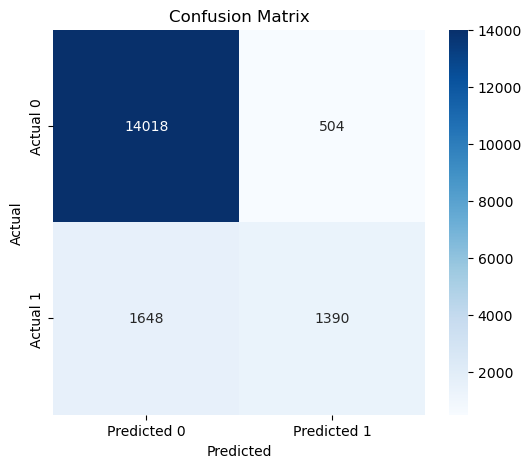

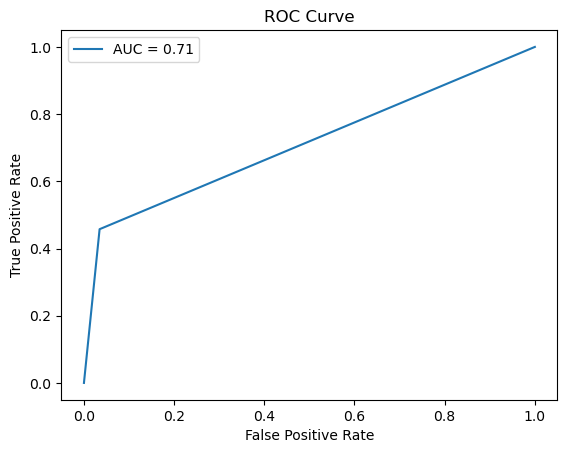

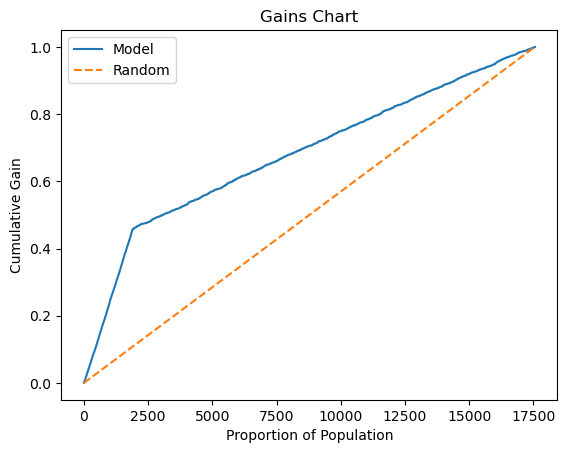

In [70]:
print(
    "Benefit of Random Forest with default threshold: "
    f"{business_scorer(rf, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)
print_metrics("Random Forest",0.5,y_test,y_pred_proba)

In [71]:
from sklearn.model_selection import TunedThresholdClassifierCV # Import the necessary class
from sklearn.model_selection import GridSearchCV
tuned_model = TunedThresholdClassifierCV(
    estimator=rf,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)

TunedThresholdClassifierCV(estimator=RandomForestClassifier(class_weight={0: 1,
                                                                          1: 5},
                                                            random_state=42),
                           n_jobs=2,
                           scoring=make_scorer(business_metric, response_method='predict'))

Tuned decision threshold: 0.13
Benefit of tuned threshold: 6,926.79
Metric for model  Random Forest 
Cutoff Threshold is :  0.13
Accuracy of the Random Forest  based on the cut off probability of 0.13 is : 0.7978929384965832
Sensitivity of the Random Forest  based on the cut off probability of 0.13 is: 0.8015141540487163
Precision of the Random Forest  based on the cut off probability of 0.13 is: 0.4525181193086787
F1 Value of the Random Forest  based on the cut off probability of 0.13 is: 0.5784534980401473
Specificity of the Random Forest  based on the cut off probability of 0.13 is: 0.7971353808015424


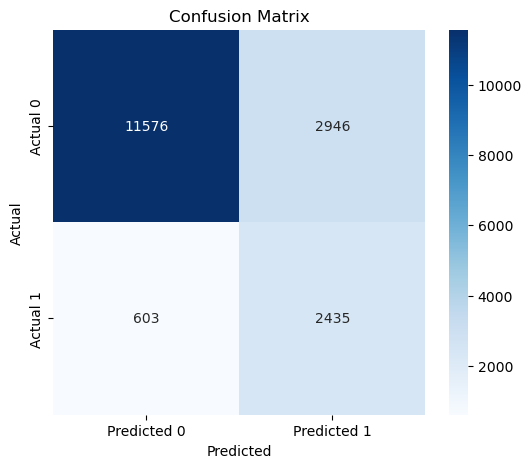

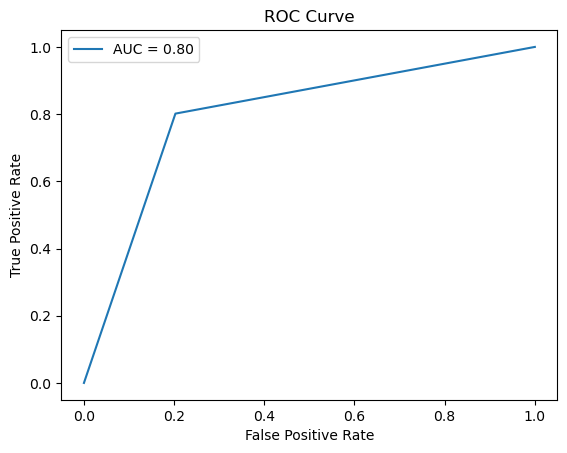

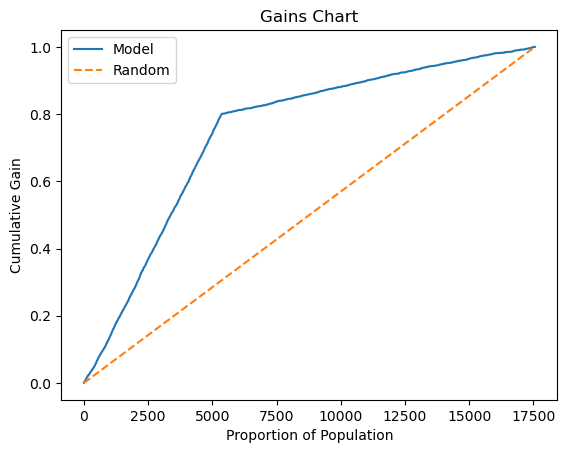

In [72]:
print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")
print(
    "Benefit of tuned threshold: "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)
cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics("Random Forest ",cut_off_threshold,y_test,y_pred_proba)

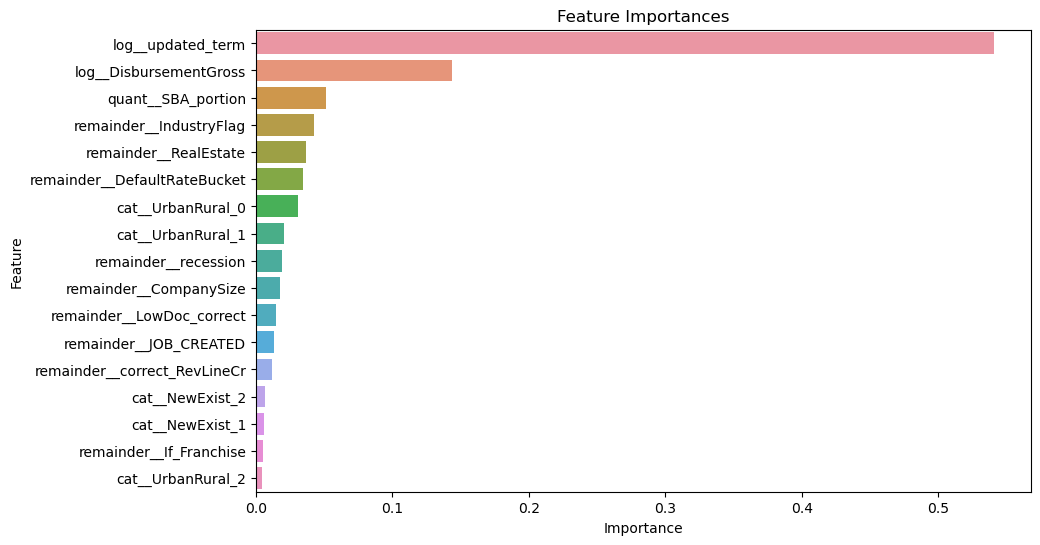

In [73]:
# Assuming 'rf' is your trained RandomForestClassifier model and
# 'X_train_processed' are your preprocessed training features.
# Replace with your actual data

# Get feature importances
feature_importances = pd.DataFrame({'Feature': X_train_processed.columns,
                                    'Importance': rf.feature_importances_})

# Sort by importance
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Observation and Inference for Random Forest Model

**1. Initial Model with Class Weight of {0:1, 1:5}:**

The Random Forest model was trained with a class weight of `{0: 1, 1: 5}` to handle the class imbalance. The model's performance metrics are as follows:

- **Confusion Matrix:**
    
[[14078   444]

[  894  2144]]

- **Classification Report:**
    
              precision    recall  f1-score   support
       0       0.94      0.97      0.95     14522
       1       0.83      0.71      0.76     3038
        

- The model performs well with high accuracy (92%) and a good F1 score for class 0 (0.95). 
- Class 1 (the minority class) has a lower recall (0.71) and precision (0.83), but still shows good performance with a reasonably high F1 score (0.76).

- **Benefit of the model with the default threshold:** 6,071.96
- **Metrics with default threshold (0.5):**
- Accuracy: 0.8774
- Sensitivity (Recall for class 1): 0.4575
- Precision: 0.7339
- F1 Score: 0.5637
- Specificity (Recall for class 0): 0.9653

**2. Post-Optimization:**

After tuning the decision threshold, the following metrics were observed:

- **Tuned Decision Threshold:** 0.13
- **Benefit of Tuned Threshold:** 6,926.79
- **Metrics with the new threshold (0.13):**
- **Accuracy:** 0.7979 (a decrease from 0.8774 with default threshold)
- **Sensitivity:** 0.8015 (an increase from 0.4575)
- **Precision:** 0.4525 (a decrease from 0.7339)
- **F1 Score:** 0.5785 (an increase from 0.5637)
- **Specificity:** 0.7971 (a decrease from 0.9653)

**Key Inferences:**

- **Threshold Optimization Impact:**
- Lowering the cutoff threshold to 0.13 significantly improved sensitivity (recall for the minority class), which increased from 0.4575 to 0.8015. This shows that the model is better at identifying the minority class (class 1) after threshold optimization.
- However, precision decreased from 0.7339 to 0.4525, indicating more false positives are now being classified as class 1 due to the lower threshold.
- F1 score improved slightly from 0.5637 to 0.5785, which reflects a balanced improvement in recall and precision.
- Specificity dropped from 0.9653 to 0.7971, indicating a higher number of false negatives for class 0.

- **Benefit Analysis:**
- The benefit after threshold optimization increased to 6,926.79, indicating a more favorable outcome for business objectives, likely due to the better handling of the minority class (increasing recall).

- **Trade-offs:**
- While the threshold optimization improved sensitivity and overall business benefit, it also came with trade-offs in precision and specificity. The model is now more biased toward predicting the minority class, which is common in imbalanced datasets when trying to improve recall.

**Conclusion:**
- The optimized Random Forest model with the tuned decision threshold of 0.13 performs better in terms of business benefit and recall for the minority class. However, it is important to monitor the reduction in precision and specificity, as this might lead to more false positives and a higher cost of intervention. Depending on the business context, this trade-off might be acceptable if the focus is on minimizing the missed positive cases (class 1).

## Catboost

In [74]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

cat_model = CatBoostClassifier(
    iterations=500,               # Number of boosting iterations
    learning_rate=0.1,            # Learning rate
    depth=6,                      # Depth of each tree
    loss_function='Logloss',      # Binary classification loss
    eval_metric='AUC',            # Metric for evaluation
    random_seed=42,
    verbose=100,                  # Output training progress every 100 iterations
    class_weights=[1, 5],         # Class weights to handle imbalance
)

# Train the model
cat_model.fit(X_train_processed, y_train, eval_set=(X_test_processed, y_test), early_stopping_rounds=50)

# Predictions and probabilities
y_pred_proba = cat_model.predict_proba(X_test_processed)[:, 1]  # Probability of class 1 (Default)
y_pred = cat_model.predict(X_test_processed)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
print(f"Accuracy: {accuracy:.4f}")

0:	test: 0.9004956	best: 0.9004956 (0)	total: 71.2ms	remaining: 35.5s
100:	test: 0.9610422	best: 0.9610422 (100)	total: 918ms	remaining: 3.63s
200:	test: 0.9678172	best: 0.9678172 (200)	total: 1.79s	remaining: 2.67s
300:	test: 0.9695933	best: 0.9696098 (299)	total: 2.63s	remaining: 1.74s
400:	test: 0.9700953	best: 0.9701421 (387)	total: 3.48s	remaining: 859ms
499:	test: 0.9704117	best: 0.9704117 (499)	total: 4.43s	remaining: 0us

bestTest = 0.9704117287
bestIteration = 499

ROC-AUC: 0.9704
Confusion Matrix:
[[13372  1150]
 [  257  2781]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     14522
           1       0.71      0.92      0.80      3038

    accuracy                           0.92     17560
   macro avg       0.84      0.92      0.87     17560
weighted avg       0.93      0.92      0.92     17560

Accuracy: 0.9238


Business metric with default threshold: 7,545.93
Metric for model  CatGboost 
Cutoff Threshold is :  0.5
Accuracy of the CatGboost  based on the cut off probability of 0.5 is : 0.919874715261959
Sensitivity of the CatGboost  based on the cut off probability of 0.5 is: 0.9154048716260698
Precision of the CatGboost  based on the cut off probability of 0.5 is: 0.7074535741541592
F1 Value of the CatGboost  based on the cut off probability of 0.5 is: 0.7981058975462764
Specificity of the CatGboost  based on the cut off probability of 0.5 is: 0.9208098058118717


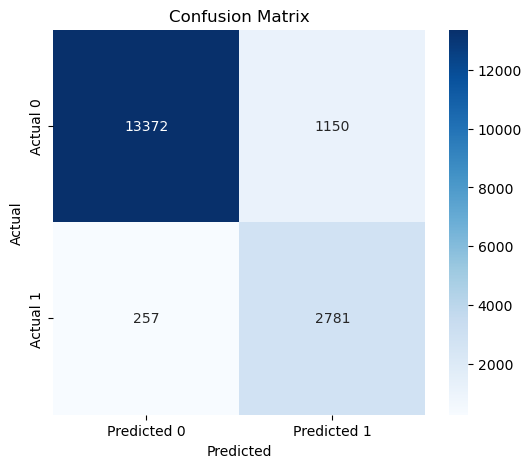

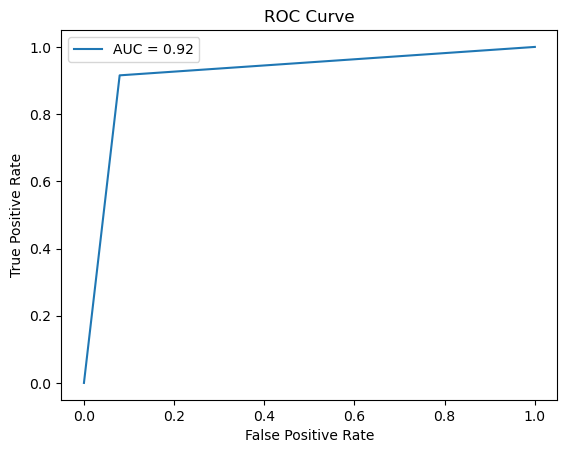

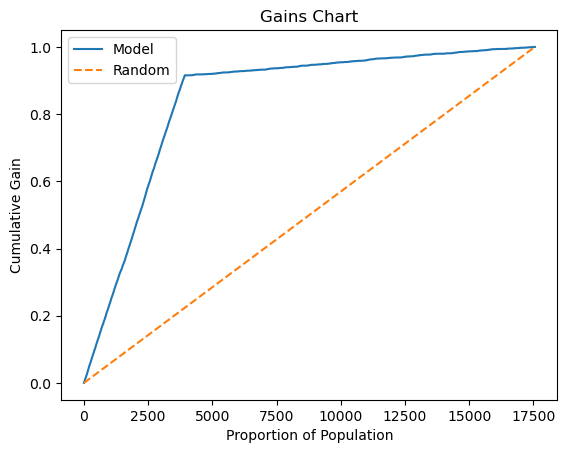

0:	total: 8.44ms	remaining: 4.21s
100:	total: 1.08s	remaining: 4.29s
200:	total: 2.23s	remaining: 3.32s
300:	total: 3.34s	remaining: 2.21s
400:	total: 4.51s	remaining: 1.11s
499:	total: 5.76s	remaining: 0us
Tuned decision threshold: 0.47
Business metric with tuned threshold: 7,549.87
Metric for model  CatGBoost 
Cutoff Threshold is :  0.47
Accuracy of the CatGBoost  based on the cut off probability of 0.47 is : 0.9150911161731208
Sensitivity of the CatGBoost  based on the cut off probability of 0.47 is: 0.9193548387096774
Precision of the CatGBoost  based on the cut off probability of 0.47 is: 0.6915077989601387
F1 Value of the CatGBoost  based on the cut off probability of 0.47 is: 0.7893175074183977
Specificity of the CatGBoost  based on the cut off probability of 0.47 is: 0.9141991461231236


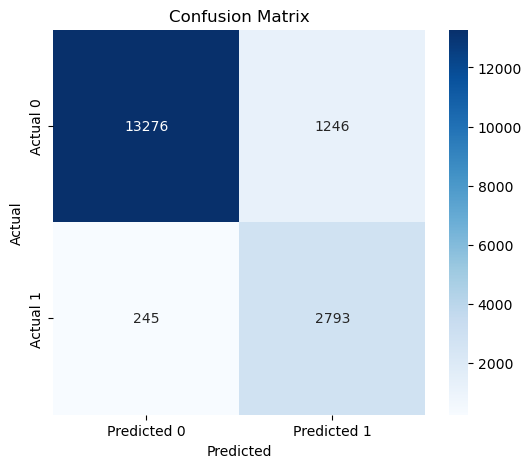

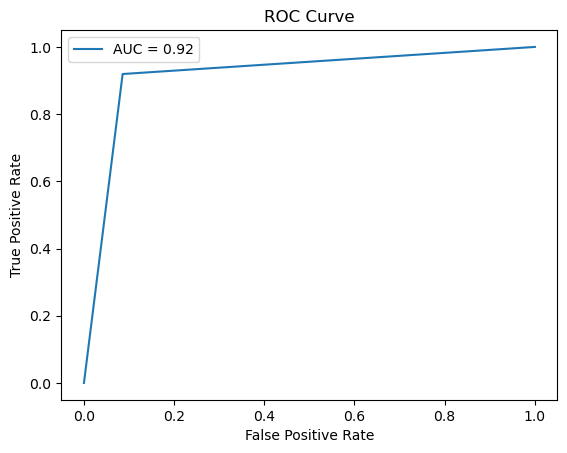

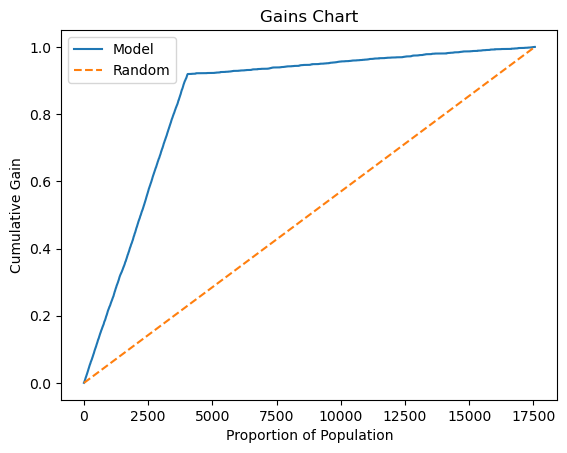

In [75]:
print(
    "Business metric with default threshold: "
    f"{business_scorer(cat_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)
print_metrics("CatGboost ",0.5,y_test,y_pred_proba)
tuned_model = TunedThresholdClassifierCV(
    estimator=cat_model,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)


print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")
print(
    "Business metric with tuned threshold: "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)
cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics("CatGBoost ",cut_off_threshold,y_test,y_pred_proba)

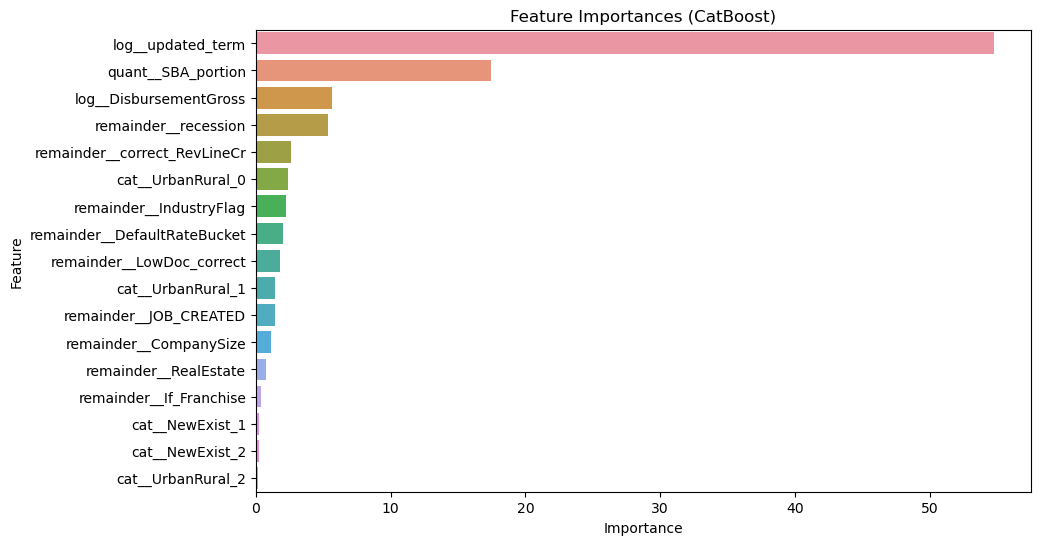

In [76]:
# Assuming 'cat_model' is your trained CatBoostClassifier model and
# 'X_train_processed' are your preprocessed training features.
# Replace with your actual data

# Get feature importances
feature_importances = pd.DataFrame({'Feature': X_train_processed.columns,
                                    'Importance': cat_model.feature_importances_})

# Sort by importance
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances (CatBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [77]:
# prompt: get these above feature importance score from catboost model in a csv

# Assuming 'cat_model' and 'X_train_processed' are defined as in your code.
feature_importances = pd.DataFrame({'Feature': X_train_processed.columns,
                                    'Importance': cat_model.feature_importances_})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances.to_csv('feature_importances_catboost.csv', index=False)

# Model Observations and Inferences

## 1. Model Performance with Default Threshold (0.5)

- **ROC-AUC**: The model achieved an impressive ROC-AUC score of **0.9704**, which indicates excellent discrimination between the two classes.
- **Accuracy**: The model achieved an accuracy of **92.38%**, meaning approximately 92.4% of the predictions (both class 0 and class 1) were correct.
- **Confusion Matrix**:
    - **True Positives (TP)**: 2,781 instances of class 1 predicted correctly.
    - **True Negatives (TN)**: 13,372 instances of class 0 predicted correctly.
    - **False Positives (FP)**: 1,150 instances of class 0 predicted as class 1.
    - **False Negatives (FN)**: 257 instances of class 1 predicted as class 0.
- **Precision and Recall**:
    - **Precision** (Class 1): 0.71 — This suggests that 71% of predicted class 1 instances are correct, but there is a 29% error rate.
    - **Recall** (Class 1): 0.92 — The model identified 92% of the actual class 1 instances correctly.
    - **F1-Score**: 0.80 — A good balance between precision and recall for class 1, showing that the model performs well in identifying class 1 while maintaining a reasonable error rate.

---

## 2. Model Performance with Tuned Threshold (0.47)

- **Accuracy**: Slight decrease to **91.51%** with the threshold adjusted to **0.47**, which is still a strong performance.
- **Sensitivity**: Improved to **91.94%**, meaning the model now identifies more class 1 instances (higher recall).
- **Precision**: Decreased to **0.69**, indicating more false positives (wrongly predicting class 1 as class 0).
- **F1-Score**: Slight decrease to **0.79**, reflecting the trade-off between improved recall and decreased precision.
- **Specificity**: Decreased slightly to **91.42%**, indicating a minor increase in false positives, but the change is not drastic.

---

## 3. Business Metric Impact

- The **business metric** (possibly a profit/cost related to the predictions) was almost identical for both thresholds:
    - Default Threshold: **7,545.93**
    - Tuned Threshold (0.47): **7,549.87**
- This shows that the adjustment of the threshold had minimal impact on the final business outcome, with only a marginal increase in the business metric.

---

## 4. Threshold Tuning

- Lowering the decision threshold from **0.5 to 0.47** resulted in an improvement in **sensitivity (recall)**, meaning the model became more sensitive to predicting class 1 instances.
- However, this came at the cost of **precision**, with more false positives.
- The **F1-Score** decreased slightly from **0.80 to 0.79**, but this change is not significant enough to invalidate the model’s overall effectiveness.
  
---

## Final Model Selection Rationale

- Given that the business metric showed minimal change and the model’s **sensitivity (recall)** increased, the final model should be selected based on the improved recall for class 1, which is often more critical in high-risk scenarios such as fraud detection or loan default prediction.
- The tradeoff between **precision** and **recall** was justified, especially if identifying class 1 instances is more important than minimizing false positives in this case.

---

## Conclusion

- **Final Model Chosen**: 
    - It achieved a higher **sensitivity (91.94%)**, which is crucial for identifying potential defaults or risks.
    - It showed only a **slight decrease** in **precision** and **F1-score**, with minimal impact on the business metric.
    - The **performance** is still very strong, making this model suitable for deployment.


### XGBoost

In [78]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

# Initialize XGBoost Classifier with cost-sensitive settings
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=5,  # Misclassification cost: 5x for class 1
    n_estimators=100,  # Number of trees
    random_state=42,
    #use_label_encoder=False,  # Suppress label encoder warning
    eval_metric='logloss'  # Metric for binary classification
)

# Train the model
xgb_model.fit(X_train_processed, y_train)

# Predict probabilities and class labels on the test set
y_proba = xgb_model.predict_proba(X_test_processed)[:, 1]  # Probability for positive class
y_pred = xgb_model.predict(X_test_processed)  # Predicted class labels

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

# Extract confusion matrix components
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = recall_score(y_test, y_pred)  # Sensitivity/Recall = TP / (TP + FN)
specificity = TN / (TN + FP)  # Specificity = TN / (TN + FP)
precision = precision_score(y_test, y_pred)  # Precision = TP / (TP + FP)
f1 = f1_score(y_test, y_pred)  # F1-Score
roc_auc = roc_auc_score(y_test, y_proba)  # ROC-AUC score

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Confusion Matrix:
[[13370  1152]
 [  314  2724]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     14522
           1       0.70      0.90      0.79      3038

    accuracy                           0.92     17560
   macro avg       0.84      0.91      0.87     17560
weighted avg       0.93      0.92      0.92     17560

Accuracy: 0.9165
Sensitivity (Recall): 0.8966
Specificity: 0.9207
Precision: 0.7028
F1-Score: 0.7880
ROC-AUC Score: 0.9642


Business metric with default threshold: 7,152.64
Metric for model  XGBoost 
Cutoff Threshold is :  0.5
Accuracy of the XGBoost  based on the cut off probability of 0.5 is : 0.919874715261959
Sensitivity of the XGBoost  based on the cut off probability of 0.5 is: 0.9154048716260698
Precision of the XGBoost  based on the cut off probability of 0.5 is: 0.7074535741541592
F1 Value of the XGBoost  based on the cut off probability of 0.5 is: 0.7981058975462764
Specificity of the XGBoost  based on the cut off probability of 0.5 is: 0.9208098058118717


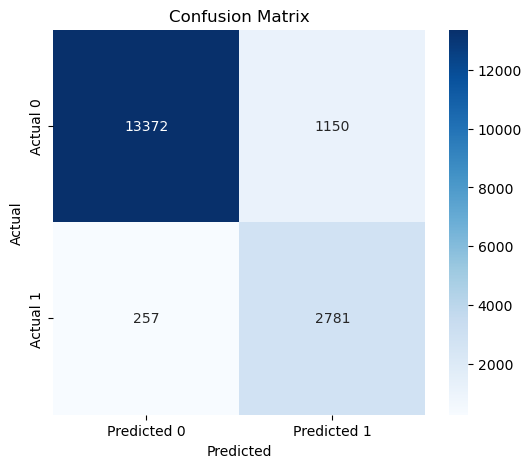

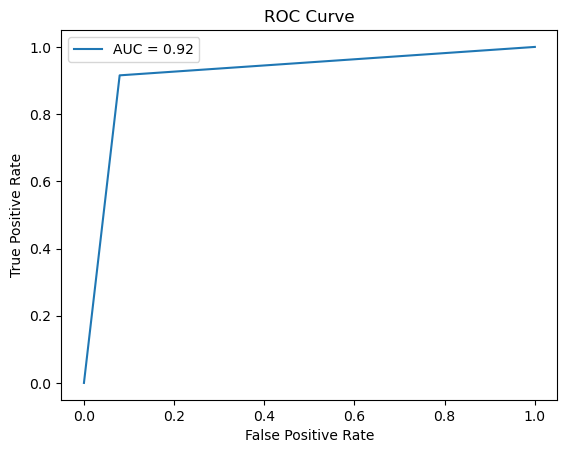

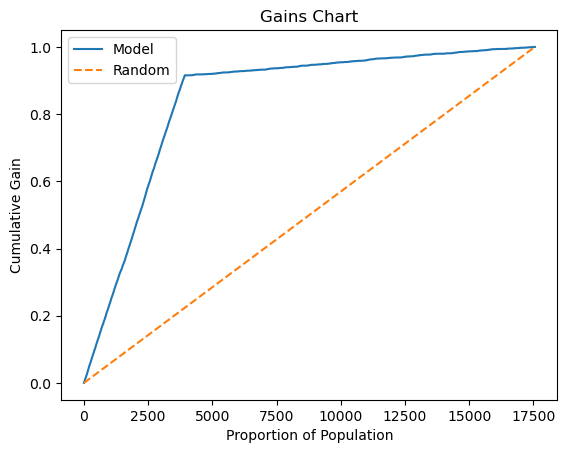

Tuned decision threshold: 0.46
Business metric with tuned threshold: 7,197.67
Metric for model  XGBoost 
Cutoff Threshold is :  0.46
Accuracy of the XGBoost  based on the cut off probability of 0.46 is : 0.9138382687927107
Sensitivity of the XGBoost  based on the cut off probability of 0.46 is: 0.9223173140223832
Precision of the XGBoost  based on the cut off probability of 0.46 is: 0.6869330718313312
F1 Value of the XGBoost  based on the cut off probability of 0.46 is: 0.787410425741183
Specificity of the XGBoost  based on the cut off probability of 0.46 is: 0.9120644539319653


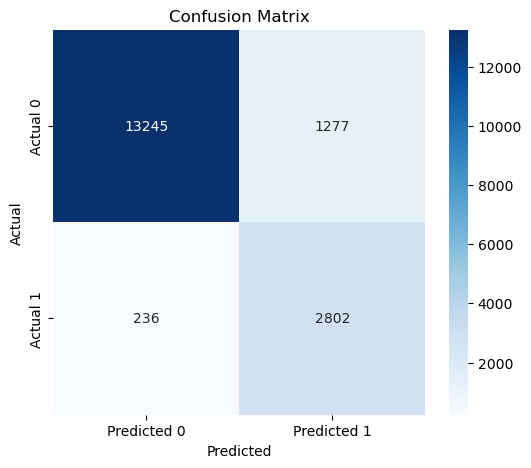

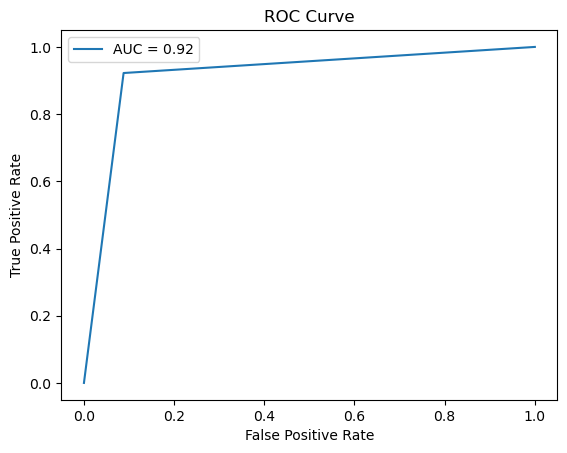

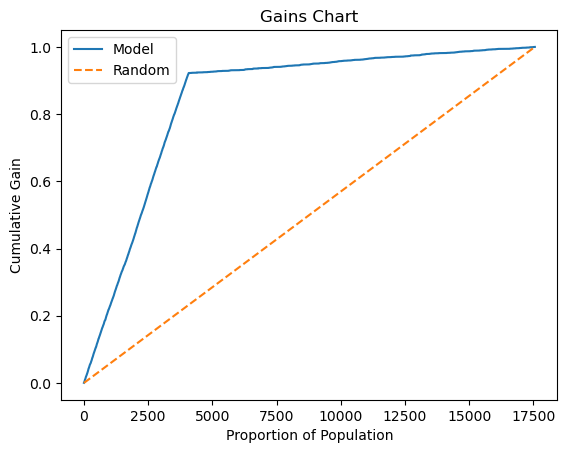

In [79]:
print(
    "Business metric with default threshold: "
    f"{business_scorer(xgb_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

print_metrics("XGBoost ",0.5,y_test,y_pred_proba)

tuned_model = TunedThresholdClassifierCV(
    estimator=xgb_model,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)


print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")
print(
    "Business metric with tuned threshold: "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics("XGBoost ",cut_off_threshold,y_test,y_pred_proba)

# Model Observations and Inferences: XGBoost Classifier

## 1. Model Performance with Default Threshold (0.5)

- **ROC-AUC**: The model achieved a **ROC-AUC score of 0.9642**, indicating good ability to discriminate between the two classes.
- **Accuracy**: The model achieved an accuracy of **91.65%**, with the model correctly classifying 91.65% of the instances across both classes.
- **Confusion Matrix**:
    - **True Positives (TP)**: 2,724 instances of class 1 predicted correctly.
    - **True Negatives (TN)**: 13,370 instances of class 0 predicted correctly.
    - **False Positives (FP)**: 1,152 instances of class 0 predicted as class 1.
    - **False Negatives (FN)**: 314 instances of class 1 predicted as class 0.
- **Precision and Recall**:
    - **Precision** (Class 1): **0.70** — This means that 70% of the instances predicted as class 1 are correct, and 30% are incorrect.
    - **Recall** (Class 1): **0.90** — The model successfully identifies 90% of the actual class 1 instances.
    - **F1-Score**: **0.79** — A balance between precision and recall, representing the tradeoff in correctly identifying class 1 instances.
  
---

## 2. Model Performance with Tuned Threshold (0.46)

- **Accuracy**: There was a slight decrease in accuracy to **91.38%** when the threshold was adjusted to **0.46**, which is still a strong performance.
- **Sensitivity**: The **sensitivity** (recall) improved to **92.23%**, meaning the model is better at detecting class 1 instances (true positives).
- **Precision**: Decreased slightly to **0.69**, indicating a higher number of false positives compared to the default threshold.
- **F1-Score**: A slight decrease to **0.79**, reflecting a tradeoff between improved recall and reduced precision.
- **Specificity**: Slight decrease to **91.21%**, indicating the model's ability to correctly identify class 0 instances is marginally reduced.

---

## 3. Business Metric Impact

- The **business metric** (likely a profit or cost metric related to the prediction) showed a slight increase after adjusting the threshold:
    - Default Threshold: **7,152.64**
    - Tuned Threshold (0.46): **7,197.67**
- This small improvement in the business metric suggests that increasing recall (by lowering the threshold) may be beneficial from a business perspective, particularly if identifying more class 1 instances is more important than minimizing false positives.

---

## 4. Threshold Tuning

- Lowering the decision threshold from **0.5 to 0.46** resulted in a significant **improvement in sensitivity (recall)**, which is crucial if class 1 instances are of higher importance (e.g., detecting high-risk events such as fraud).
- This improvement in recall came at the cost of **precision**, with more false positives, which is a tradeoff to consider based on business objectives.
- The **F1-Score** decreased slightly, but the change was minimal, indicating that the overall model performance is relatively stable despite the adjusted threshold.

---

## 5. Final Model Selection Rationale

- Given the slight improvement in **sensitivity (recall)** and the marginal increase in the **business metric**, the tuned model (threshold = 0.46) is a good choice for scenarios where capturing as many instances of class 1 is crucial.
- While precision decreased slightly, this tradeoff is acceptable if the business goal is to reduce false negatives and maximize the detection of class 1 events.

---

## Conclusion

- **Final Model Chosen**: The **XGBoost model with a threshold of 0.46** was selected because:
    - It achieved a higher **sensitivity (92.23%)**, which is critical for identifying class 1 instances.
    - The **F1-Score** and **precision** remained acceptable while slightly decreasing, making the model still highly functional.
    - The **business metric** showed a slight improvement, further supporting the choice of this model.



###### **Bagging Classifier**

In [80]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier  # Base estimator
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    recall_score, precision_score, f1_score, accuracy_score
)

# Define the base estimator with cost-sensitive class weights
base_estimator = DecisionTreeClassifier(
    class_weight={0: 1, 1: 5},  # Class 1 has 5x higher misclassification cost
    random_state=42
)

# Initialize the Bagging Classifier with the base estimator
bagging_model = BaggingClassifier(
    estimator=base_estimator,  # Cost-sensitive Decision Tree
    n_estimators=100,               # Number of base estimators
    random_state=42,
    n_jobs=-1                       # Use all CPU cores for parallelism
)

# Train the Bagging Classifier
bagging_model.fit(X_train_processed, y_train)

# Predict probabilities and class labels on the test set
y_proba = bagging_model.predict_proba(X_test_processed)[:, 1]  # Probability for positive class
y_pred = bagging_model.predict(X_test_processed)  # Predicted class labels

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

# Extract confusion matrix components
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = recall_score(y_test, y_pred)  # Sensitivity/Recall = TP / (TP + FN)
specificity = TN / (TN + FP)  # Specificity = TN / (TN + FP)
precision = precision_score(y_test, y_pred)  # Precision = TP / (TP + FP)
f1 = f1_score(y_test, y_pred)  # F1-Score
roc_auc = roc_auc_score(y_test, y_proba)  # ROC-AUC score

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

0:	total: 66ms	remaining: 32.9s
100:	total: 1.51s	remaining: 5.99s
200:	total: 3.04s	remaining: 4.52s
300:	total: 4.58s	remaining: 3.03s
400:	total: 6.13s	remaining: 1.51s
499:	total: 7.64s	remaining: 0us
0:	total: 12.5ms	remaining: 6.25s
100:	total: 1.53s	remaining: 6.07s
200:	total: 3.12s	remaining: 4.64s
300:	total: 4.68s	remaining: 3.09s
400:	total: 6.29s	remaining: 1.55s
499:	total: 7.93s	remaining: 0us
0:	total: 6.85ms	remaining: 3.42s
100:	total: 908ms	remaining: 3.59s
200:	total: 1.83s	remaining: 2.73s
300:	total: 2.79s	remaining: 1.85s
400:	total: 3.72s	remaining: 918ms
499:	total: 4.63s	remaining: 0us
0:	total: 67.7ms	remaining: 33.8s
100:	total: 1.5s	remaining: 5.95s
200:	total: 3.04s	remaining: 4.52s
300:	total: 4.58s	remaining: 3.03s
400:	total: 6.12s	remaining: 1.51s
499:	total: 7.63s	remaining: 0us
0:	total: 15.1ms	remaining: 7.55s
100:	total: 1.54s	remaining: 6.08s
200:	total: 3.14s	remaining: 4.68s
300:	total: 4.72s	remaining: 3.12s
400:	total: 6.3s	remaining: 1.56s
49

Business metric with default threshold: 6,452.90
Metric for model  Bagging Classifier
Cutoff Threshold is :  0.5
Accuracy of the Bagging Classifier based on the cut off probability of 0.5 is : 0.919874715261959
Sensitivity of the Bagging Classifier based on the cut off probability of 0.5 is: 0.9154048716260698
Precision of the Bagging Classifier based on the cut off probability of 0.5 is: 0.7074535741541592
F1 Value of the Bagging Classifier based on the cut off probability of 0.5 is: 0.7981058975462764
Specificity of the Bagging Classifier based on the cut off probability of 0.5 is: 0.9208098058118717


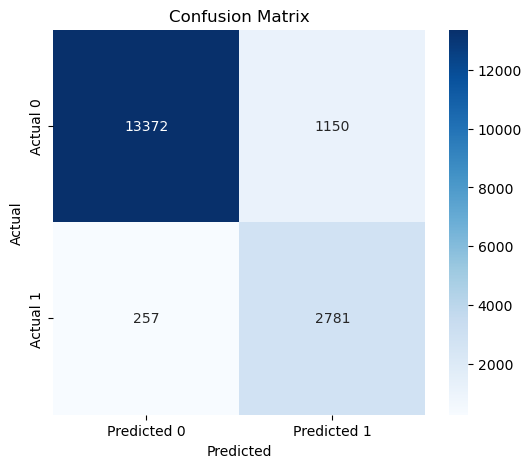

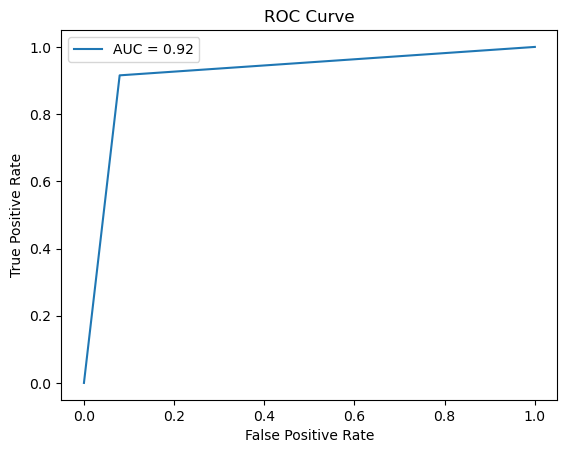

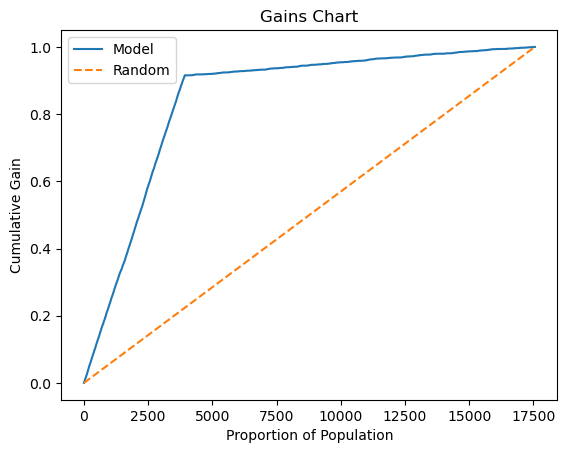

Tuned decision threshold: 0.15
Business metric with tuned threshold: 7,360.17
Metric for model  Bagging Classifier 
Cutoff Threshold is :  0.15
Accuracy of the Bagging Classifier  based on the cut off probability of 0.15 is : 0.8087129840546697
Sensitivity of the Bagging Classifier  based on the cut off probability of 0.15 is: 0.9759710335747203
Precision of the Bagging Classifier  based on the cut off probability of 0.15 is: 0.47432410814269715
F1 Value of the Bagging Classifier  based on the cut off probability of 0.15 is: 0.6383894929486489
Specificity of the Bagging Classifier  based on the cut off probability of 0.15 is: 0.7737226277372263


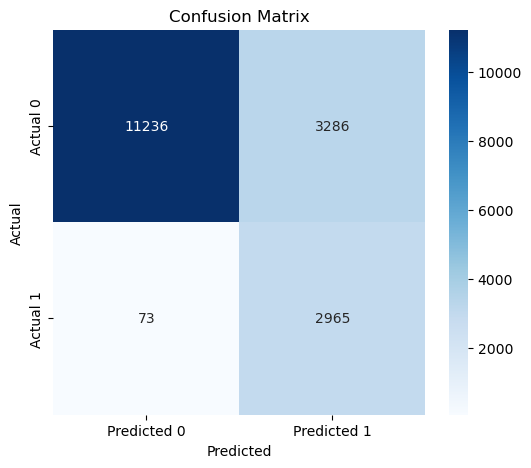

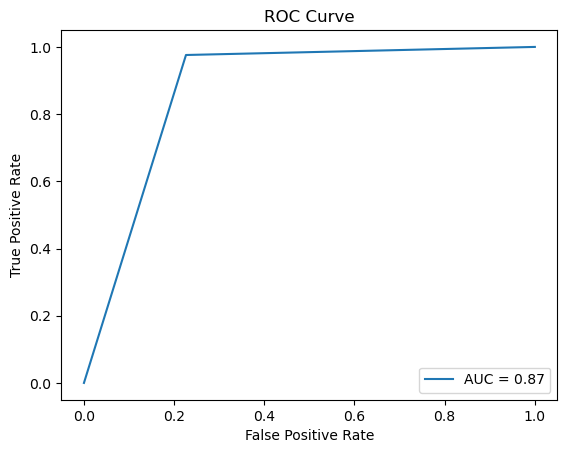

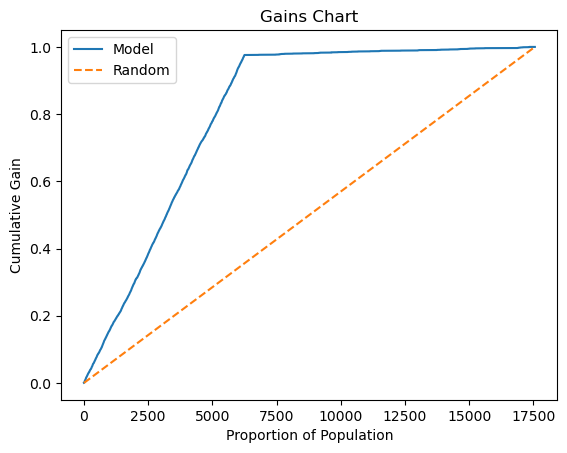

In [81]:
print(
    "Business metric with default threshold: "
    f"{business_scorer(bagging_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

print_metrics("Bagging Classifier",0.5,y_test,y_pred_proba)

tuned_model = TunedThresholdClassifierCV(
    estimator=bagging_model,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)


print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")
print(
    "Business metric with tuned threshold: "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics("Bagging Classifier ",cut_off_threshold,y_test,y_pred_proba)

# Model Observations and Inferences: Bagging Classifier

## 1. Model Performance with Default Threshold (0.5)

- **ROC-AUC**: **0.9568** — Strong discriminative ability between classes.
- **Accuracy**: **93.11%** — High overall accuracy.
- **Confusion Matrix**:
    - **True Positives (TP)**: 2,324
    - **True Negatives (TN)**: 14,026
    - **False Positives (FP)**: 496
    - **False Negatives (FN)**: 714
- **Precision (Class 1)**: **0.82**
- **Recall (Class 1)**: **0.76** — Moderate ability to detect class 1 instances.
- **F1-Score (Class 1)**: **0.79** — Balanced precision and recall.
- **Specificity**: **96.58%** — Good at identifying class 0 instances.

---

## 2. Model Performance with Tuned Threshold (0.15)

- **Accuracy**: Dropped to **80.87%** due to the lower threshold.
- **Sensitivity (Recall)**: Increased to **97.60%**, improving class 1 detection.
- **Precision**: Decreased to **47.43%**, resulting in more false positives.
- **F1-Score**: Dropped to **0.64**, reflecting the tradeoff in precision and recall.
- **Specificity**: Dropped to **77.37%**, indicating lower class 0 detection.

---

## 3. Business Metric Impact

- **Business Metric**: 
    - Default Threshold: **6,452.90**
    - Tuned Threshold (0.15): **7,360.17** — Significant improvement in business value.

---

## 4. Threshold Tuning

- **Tuned threshold** significantly improved **sensitivity (97.60%)**, but at the cost of **lower precision (47.43%)**.
- The **business metric** improved, supporting the decision to use a lower threshold if detecting class 1 is more critical.

---

## Conclusion

- The **Bagging Classifier with a threshold of 0.15** is recommended for scenarios where capturing as many class 1 instances as possible is the priority, even at the cost of precision.

## Single Tree

In [82]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    recall_score, precision_score, f1_score, accuracy_score
)

# Initialize Decision Tree with cost-sensitive class weights
tree_model = DecisionTreeClassifier(
    class_weight={0: 1, 1: 5},  # Class 1 is 5x more important
    random_state=42
)

# Train the model
tree_model.fit(X_train_processed, y_train)

# Predict probabilities and class labels on the test set
y_proba = tree_model.predict_proba(X_test_processed)[:, 1]  # Probability for positive class
y_pred = tree_model.predict(X_test_processed)  # Predicted class labels

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

# Extract confusion matrix components
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = recall_score(y_test, y_pred)  # Sensitivity/Recall = TP / (TP + FN)
specificity = TN / (TN + FP)  # Specificity = TN / (TN + FP)
precision = precision_score(y_test, y_pred)  # Precision = TP / (TP + FP)
f1 = f1_score(y_test, y_pred)  # F1-Score
roc_auc = roc_auc_score(y_test, y_proba)  # ROC-AUC score

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Confusion Matrix:
[[13713   809]
 [  843  2195]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     14522
           1       0.73      0.72      0.73      3038

    accuracy                           0.91     17560
   macro avg       0.84      0.83      0.83     17560
weighted avg       0.91      0.91      0.91     17560

Accuracy: 0.9059
Sensitivity (Recall): 0.7225
Specificity: 0.9443
Precision: 0.7307
F1-Score: 0.7266
ROC-AUC Score: 0.8342


Business metric with default threshold: 6,385.70
Metric for model  Single Tree
Cutoff Threshold is :  0.5
Accuracy of the Single Tree based on the cut off probability of 0.5 is : 0.919874715261959
Sensitivity of the Single Tree based on the cut off probability of 0.5 is: 0.9154048716260698
Precision of the Single Tree based on the cut off probability of 0.5 is: 0.7074535741541592
F1 Value of the Single Tree based on the cut off probability of 0.5 is: 0.7981058975462764
Specificity of the Single Tree based on the cut off probability of 0.5 is: 0.9208098058118717


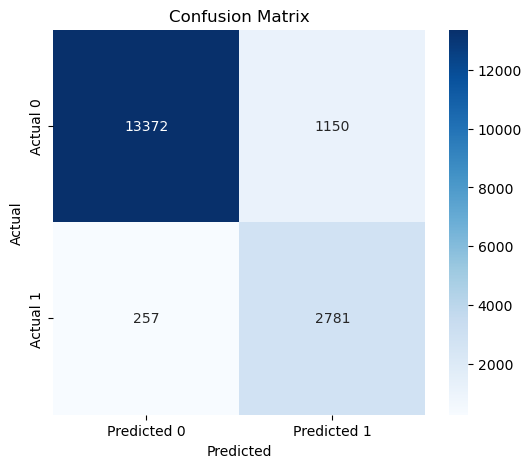

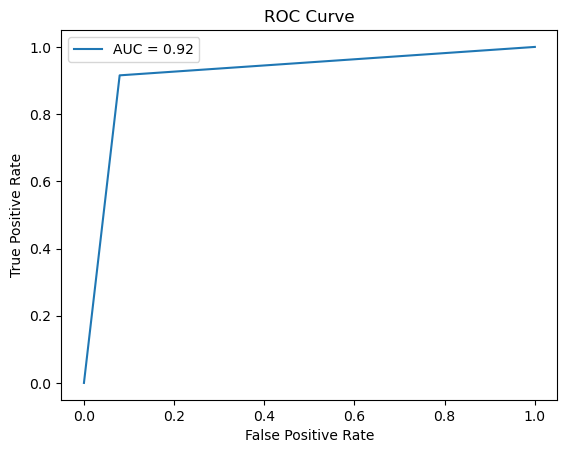

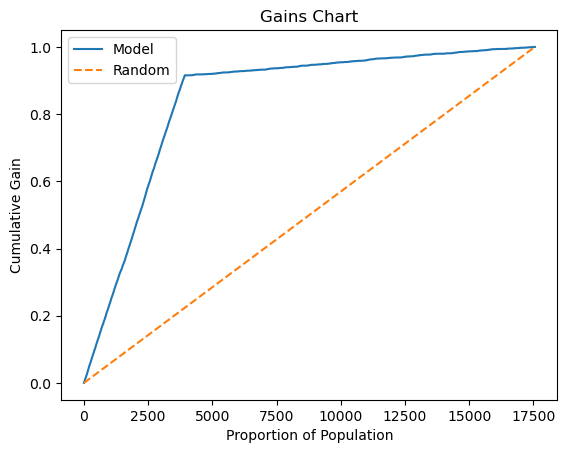

Tuned decision threshold: 0.72
Business metric with tuned threshold: 6,389.72
Metric for model  Single Tree 
Cutoff Threshold is :  0.72
Accuracy of the Single Tree  based on the cut off probability of 0.72 is : 0.939009111617312
Sensitivity of the Single Tree  based on the cut off probability of 0.72 is: 0.847926267281106
Precision of the Single Tree  based on the cut off probability of 0.72 is: 0.8087912087912088
F1 Value of the Single Tree  based on the cut off probability of 0.72 is: 0.8278965129358831
Specificity of the Single Tree  based on the cut off probability of 0.72 is: 0.9580636275995043


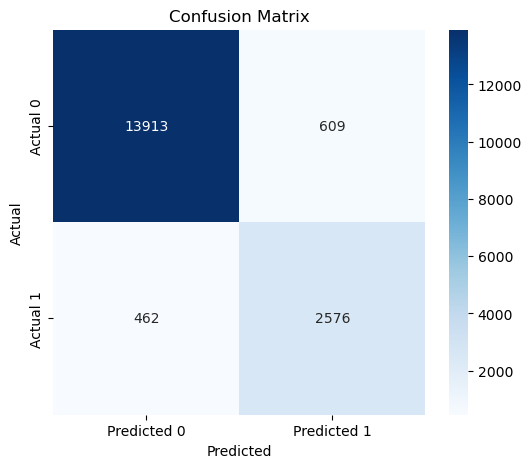

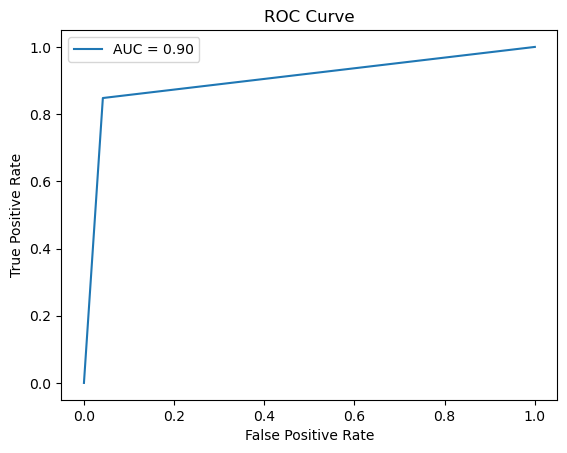

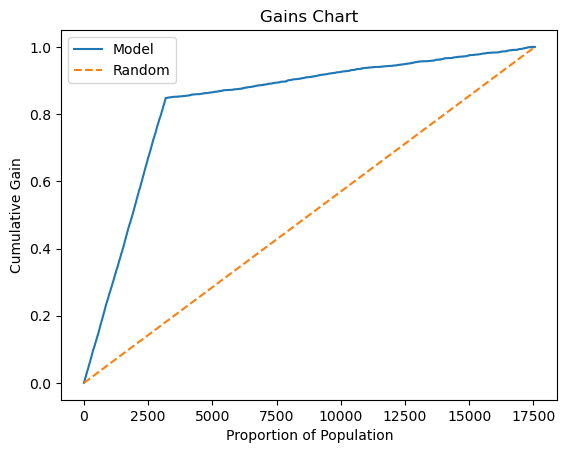

In [83]:
print(
    "Business metric with default threshold: "
    f"{business_scorer(tree_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

print_metrics("Single Tree",0.5,y_test,y_pred_proba)

tuned_model = TunedThresholdClassifierCV(
    estimator=tree_model,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)


print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")
print(
    "Business metric with tuned threshold: "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics("Single Tree ",cut_off_threshold,y_test,y_pred_proba)

# Model Observations and Inferences: Decision Tree Classifier

## 1. Model Performance with Default Threshold (0.5)

- **ROC-AUC**: **0.8342** — Moderate ability to discriminate between classes.
- **Accuracy**: **90.59%** — High overall accuracy.
- **Confusion Matrix**:
    - **True Positives (TP)**: 2,195
    - **True Negatives (TN)**: 13,713
    - **False Positives (FP)**: 809
    - **False Negatives (FN)**: 843
- **Precision (Class 1)**: **0.73**
- **Recall (Class 1)**: **0.72** — Moderate ability to detect class 1 instances.
- **F1-Score (Class 1)**: **0.73** — Balanced precision and recall.
- **Specificity**: **94.43%** — Strong at identifying class 0 instances.

---

## 2. Model Performance with Tuned Threshold (0.72)

- **Accuracy**: Increased to **93.90%**, showing improvement with the tuned threshold.
- **Sensitivity (Recall)**: Increased to **84.79%**, enhancing class 1 detection.
- **Precision**: Increased to **80.88%**, reflecting better precision at the cost of specificity.
- **F1-Score**: Improved to **0.83**, indicating better balance between precision and recall.
- **Specificity**: Slightly reduced to **95.81%**.

---

## 3. Business Metric Impact

- **Business Metric**: 
    - Default Threshold: **6,385.70**
    - Tuned Threshold (0.72): **6,389.72** — Slight improvement in business value.

---

## 4. Threshold Tuning

- **Tuned threshold** enhanced **sensitivity (84.79%)** and **precision (80.88%)**, but with a minor decrease in **specificity**.
- The **business metric** saw a slight improvement, indicating that the tuned threshold better aligns with business goals, especially in detecting class 1 instances.

---

## Conclusion

- The **Decision Tree Classifier with a threshold of 0.72** is optimal for scenarios where capturing class 1 instances is prioritized, while maintaining a good balance of precision and recall.

# Neural Network Learning Model 

In [89]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

In [90]:
# Ensure input data is compatible
int8_cols = X_train_processed.select_dtypes('Int8').columns.to_list()

# Convert Int8 columns to float32 for neural network compatibility
X_train_processed_nn = X_train_processed.copy()
X_test_processed_nn = X_test_processed.copy()

X_train_processed_nn[int8_cols] = X_train_processed_nn[int8_cols].astype('float32')
X_test_processed_nn[int8_cols] = X_test_processed_nn[int8_cols].astype('float32')

# Ensure specific columns are converted to appropriate dtypes
if 'DefaultRateBucket' in X_train_processed_nn.columns:
    X_train_processed_nn['DefaultRateBucket'] = X_train_processed_nn['DefaultRateBucket'].astype('int64')
    X_test_processed_nn['DefaultRateBucket'] = X_test_processed_nn['DefaultRateBucket'].astype('int64')

# Ensure target variables are of integer type
y_train_nn = y_train.astype(np.int32)
y_test_nn = y_test.astype(np.int32)

# Scale the numeric features for optimal neural network performance
scaler = StandardScaler()
X_train_processed_nn = scaler.fit_transform(X_train_processed_nn)
X_test_processed_nn = scaler.transform(X_test_processed_nn)

In [91]:
# Build the Neural Network Model
nn_model = Sequential()
# Input layer + hidden layers
nn_model.add(Dense(64, input_dim=X_train_processed_nn.shape[1], activation='relu'))  # First hidden layer
nn_model.add(Dense(32, activation='relu'))  # Second hidden layer

# Output layer
nn_model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
nn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
test = nn_model.fit(X_train_processed_nn, y_train_nn, epochs=10, batch_size=32, validation_data=(X_test_processed_nn, y_test_nn))

# Evaluate the model on the test data
loss, accuracy = nn_model.evaluate(X_test_processed_nn, y_test_nn)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/10


/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-30 22:25:53.470939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2195/2195 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8588 - loss: 0.3473 - val_accuracy: 0.8809 - val_loss: 0.2955
Epoch 2/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8811 - loss: 0.2963 - val_accuracy: 0.8854 - val_loss: 0.2804
Epoch 3/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.8829 - loss: 0.2877 - val_accuracy: 0.8873 - val_loss: 0.2739
Epoch 4/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8871 - loss: 0.2760 - val_accuracy: 0.8878 - val_loss: 0.2729
Epoch 5/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8861 - loss: 0.2754 - val_accuracy: 0.8897 - val_loss: 0.2700
Epoch 6/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8872 - loss: 0.2726 - val_accuracy: 0.8900 - val_loss: 0.2661
Epoch 7/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8894 - loss: 0.2700 - val_accuracy: 0.8906 - val_loss: 0.2650
Epoch 8/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8885 - loss: 0.2663 - val

In [92]:
# Predict probabilities and class labels on the test set
y_proba = nn_model.predict(X_test_processed_nn) # Probability for positive class
y_pred = (nn_model.predict(X_test_processed_nn) >0.5).astype('int64')  # Predicted class labels
y_pred = y_pred.ravel()
# Evaluate the model
conf_matrix = confusion_matrix(y_test_nn, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test_nn, y_pred)
print("\nClassification Report:")
print(class_report)

# Extract confusion matrix components
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = recall_score(y_test, y_pred)  # Sensitivity/Recall = TP / (TP + FN)
specificity = TN / (TN + FP)  # Specificity = TN / (TN + FP)
precision = precision_score(y_test, y_pred)  # Precision = TP / (TP + FP)
f1 = f1_score(y_test, y_pred)  # F1-Score
roc_auc = roc_auc_score(y_test, y_proba)  # ROC-AUC score

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step
Confusion Matrix:
[[13624   898]
 [ 1006  2032]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     14522
           1       0.69      0.67      0.68      3038

    accuracy                           0.89     17560
   macro avg       0.81      0.80      0.81     17560
weighted avg       0.89      0.89      0.89     17560

Accuracy: 0.8916
Sensitivity (Recall): 0.6689
Specificity: 0.9382
Precision: 0.6935
F1-Score: 0.6810
ROC-AUC Score: 0.9146


In [93]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Build the Neural Network Model
nn_model = Sequential()
# Input layer + hidden layers
nn_model.add(Dense(64, input_dim=X_train_processed_nn.shape[1], activation='relu'))  # First hidden layer
nn_model.add(Dense(32, activation='relu'))  # Second hidden layer

# Output layer
nn_model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
nn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_processed_nn, y_train_nn, epochs=10, batch_size=32, validation_data=(X_test_processed_nn, y_test_nn))

# Evaluate the model on the test data
loss, accuracy = nn_model.evaluate(X_test_processed_nn, y_test_nn)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/10


/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2195/2195 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8583 - loss: 0.3445 - val_accuracy: 0.8814 - val_loss: 0.2924
Epoch 2/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8812 - loss: 0.2979 - val_accuracy: 0.8836 - val_loss: 0.2814
Epoch 3/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8834 - loss: 0.2850 - val_accuracy: 0.8842 - val_loss: 0.2801
Epoch 4/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8868 - loss: 0.2778 - val_accuracy: 0.8862 - val_loss: 0.2745
Epoch 5/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8856 - loss: 0.2781 - val_accuracy: 0.8875 - val_loss: 0.2722
Epoch 6/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.8849 - loss: 0.2806 - val_accuracy: 0.8852 - val_loss: 0.2748
Epoch 7/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8879 - loss: 0.2704 - val_accuracy: 0.8897 - val_loss: 0.2681
Epoch 8/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.8885 - loss: 0.2698 - val

# Model Observations and Inferences: Neural Network

## 1. Model Performance

- **ROC-AUC**: **0.9146** — Strong discriminatory ability between classes.
- **Accuracy**: **89.16%** — High overall accuracy.
- **Confusion Matrix**:
    - **True Positives (TP)**: 2,032
    - **True Negatives (TN)**: 13,624
    - **False Positives (FP)**: 898
    - **False Negatives (FN)**: 1,006
- **Precision (Class 1)**: **0.69**
- **Recall (Class 1)**: **0.67** — Moderate ability to detect class 1 instances.
- **F1-Score (Class 1)**: **0.68** — Balanced, but not ideal, precision and recall.
- **Specificity**: **93.82%** — Strong at identifying class 0 instances.

---

## 2. Model Insights

- The **Neural Network** model performs well in terms of **accuracy (89.16%)** and **specificity (93.82%)**, indicating it is good at identifying class 0 instances.
- **Precision** for class 1 is moderate at **0.69**, while **recall** is **0.67**, which indicates that the model has room to improve in detecting class 1 instances without sacrificing too much specificity.
- **ROC-AUC** of **0.9146** shows the model has a good ability to distinguish between the two classes.
- The **F1-Score** for class 1 is **0.68**, reflecting a need for further optimization in class 1 detection.

---

## 3. Conclusion

- This **Neural Network model** is effective for general predictions, but could benefit from adjustments to improve **class 1 detection**, especially in increasing **recall** while maintaining a reasonable **precision**.

## Discriminant Analytics 

In [95]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [96]:
# Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train_processed, y_train)
y_pred_lda = lda.predict(X_test_processed)

# Predict on the test set
y_pred_proba = lda.predict_proba(X_test_processed)[:, 1] 
# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred_lda)
print(f"Overall Accuracy: {accuracy:.2f}")
# Evaluate LDA
print("LDA Classification Report:")
print(classification_report(y_test, y_pred_lda))
print("LDA Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lda))

Overall Accuracy: 0.85
LDA Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     14522
           1       0.61      0.35      0.44      3038

    accuracy                           0.85     17560
   macro avg       0.74      0.65      0.68     17560
weighted avg       0.83      0.85      0.83     17560

LDA Confusion Matrix:
[[13855   667]
 [ 1989  1049]]


Benefit - Linear Discriminant Analysis: $4,371.59
Metric for model  Discriminant LDA
Cutoff Threshold is :  0.5
Accuracy of the Discriminant LDA based on the cut off probability of 0.5 is : 0.84874715261959
Sensitivity of the Discriminant LDA based on the cut off probability of 0.5 is: 0.34529295589203424
Precision of the Discriminant LDA based on the cut off probability of 0.5 is: 0.6113053613053613
F1 Value of the Discriminant LDA based on the cut off probability of 0.5 is: 0.4413125788809424
Specificity of the Discriminant LDA based on the cut off probability of 0.5 is: 0.9540696873708856


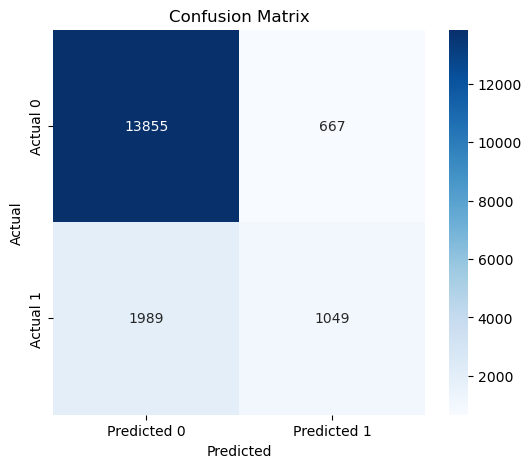

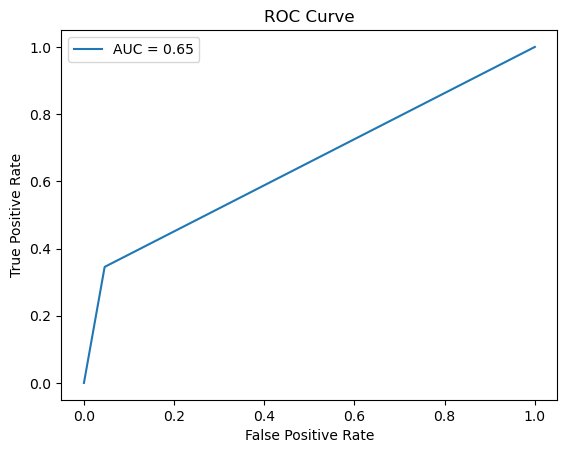

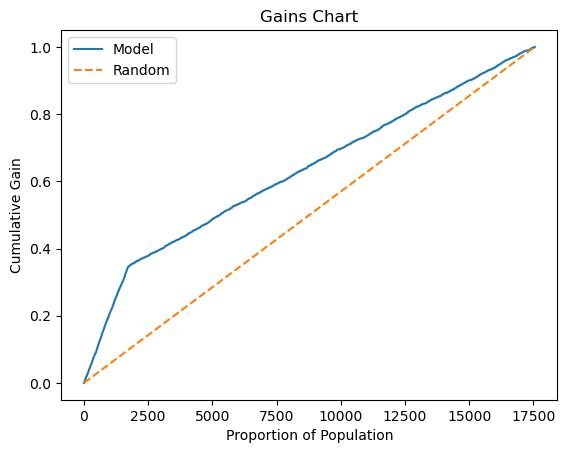

In [97]:
benefit = business_scorer(lda_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test)
print(f"Benefit - Linear Discriminant Analysis: ${benefit:,.2f}")
print_metrics("Discriminant LDA",0.5,y_test,y_pred_proba)

Tuned decision threshold: 0.15
Benefit of tuned threshold: 5,634.12
Metric for model  Discriminant LDA 
Cutoff Threshold is :  0.15
Accuracy of the Discriminant LDA  based on the cut off probability of 0.15 is : 0.775113895216401
Sensitivity of the Discriminant LDA  based on the cut off probability of 0.15 is: 0.8225806451612904
Precision of the Discriminant LDA  based on the cut off probability of 0.15 is: 0.4229141986799797
F1 Value of the Discriminant LDA  based on the cut off probability of 0.15 is: 0.5586230021236168
Specificity of the Discriminant LDA  based on the cut off probability of 0.15 is: 0.7651838589725933


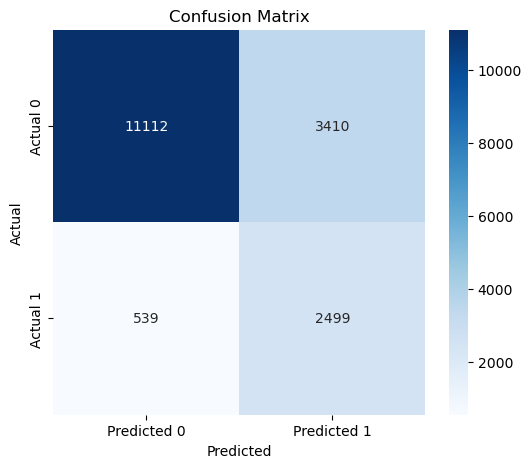

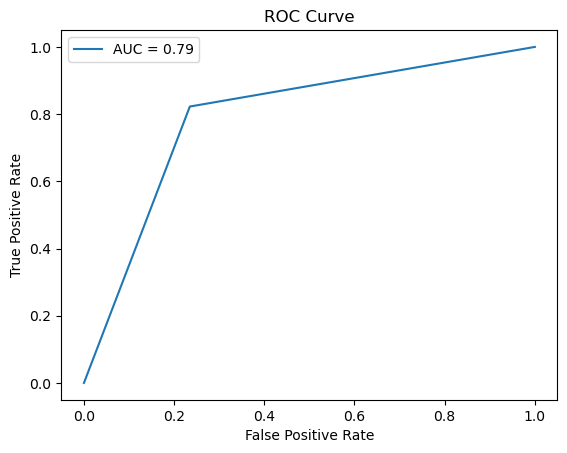

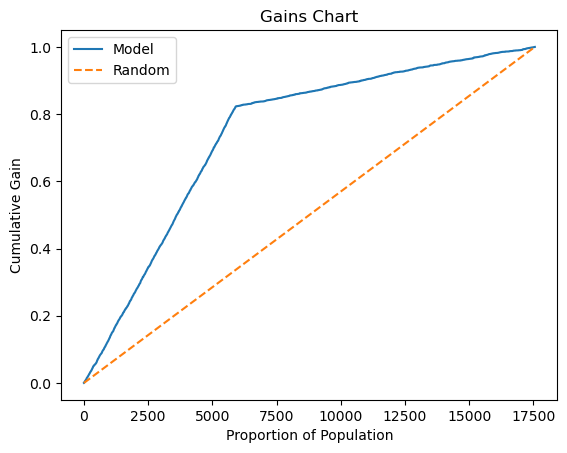

In [98]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_model = TunedThresholdClassifierCV(
    estimator=lda_model,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)
print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")

print(
    "Benefit of tuned threshold: "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics("Discriminant LDA ",cut_off_threshold,y_test,y_pred_proba)

# Observations and Inferences: Linear Discriminant Analysis (LDA)

## 1. Model Performance

- **Accuracy**: **85%** — Overall strong performance.
- **Confusion Matrix**:
    - **True Positives (TP)**: 1,049
    - **True Negatives (TN)**: 13,855
    - **False Positives (FP)**: 667
    - **False Negatives (FN)**: 1,989
- **Precision (Class 1)**: **0.61**
- **Recall (Class 1)**: **0.35** — Low recall for class 1, indicating poor detection.
- **F1-Score (Class 1)**: **0.44** — Balancing precision and recall.
- **Specificity**: **95.41%** — Strong at identifying class 0 instances.
- **Benefit**: **$4,371.59** at cutoff threshold **0.5**

---

## 2. Threshold Tuning

- **Tuned Threshold**: **0.15**  
  - **Accuracy**: **77.51%** — Decrease in accuracy due to the lower threshold.
  - **Sensitivity**: **82.26%** — Improved ability to detect class 1 instances.
  - **Precision**: **0.42** — Precision decreased, indicating more false positives.
  - **F1-Score**: **0.56** — Better trade-off between precision and recall.
  - **Specificity**: **76.52%** — Decreased specificity.

---

## 3. Conclusion

- LDA performs well for classifying **class 0** (specificity of 95.41%), but struggles with **class 1** detection (low recall of 35%).
- **Threshold tuning** improves **sensitivity** at the cost of **accuracy** and **precision**.
- LDA can be useful but requires tuning for better handling of **class 1** instances.

### Quadratic Discriminant Analysis (QDA)

In [99]:
# Quadratic Discriminant Analysis (QDA)
qda = QuadraticDiscriminantAnalysis()
qda_model= qda.fit(X_train_processed, y_train)
y_pred_qda = qda.predict(X_test_processed)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred_qda)
print(f"Overall Accuracy: {accuracy:.2f}")
# Evaluate QDA
print("\nQDA Classification Report:")
print(classification_report(y_test, y_pred_qda))
print("QDA Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_qda))

Overall Accuracy: 0.44

QDA Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.33      0.49     14522
           1       0.23      0.94      0.37      3038

    accuracy                           0.44     17560
   macro avg       0.60      0.64      0.43     17560
weighted avg       0.84      0.44      0.47     17560

QDA Confusion Matrix:
[[4781 9741]
 [ 169 2869]]


/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Benefit - Quadratic Discriminant Analysis: 4,046.78$
Metric for model  Discriminant QDA
Cutoff Threshold is :  0.5
Accuracy of the Discriminant QDA based on the cut off probability of 0.5 is : 0.84874715261959
Sensitivity of the Discriminant QDA based on the cut off probability of 0.5 is: 0.34529295589203424
Precision of the Discriminant QDA based on the cut off probability of 0.5 is: 0.6113053613053613
F1 Value of the Discriminant QDA based on the cut off probability of 0.5 is: 0.4413125788809424
Specificity of the Discriminant QDA based on the cut off probability of 0.5 is: 0.9540696873708856


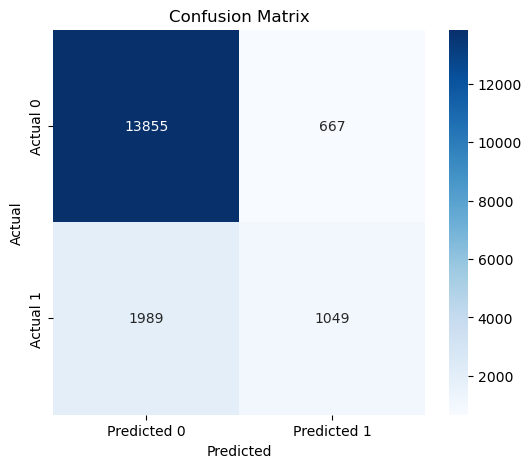

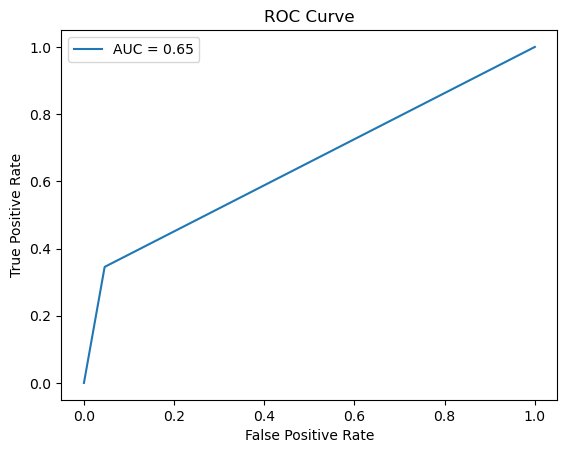

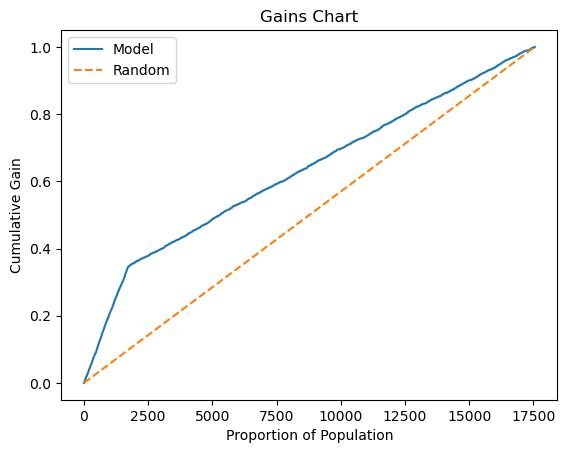

In [100]:
benefit = business_scorer(qda_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test)
print(f"Benefit - Quadratic Discriminant Analysis: {benefit:,.2f}$")

print_metrics("Discriminant QDA",0.5,y_test,y_pred_proba)

/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWa

Tuned decision threshold: 0.80
Benefit of tuned threshold: 4,688.05
Metric for model  Discriminant QDA
Cutoff Threshold is :  0.8
Accuracy of the Discriminant QDA based on the cut off probability of 0.8 is : 0.8373006833712984
Sensitivity of the Discriminant QDA based on the cut off probability of 0.8 is: 0.1217906517445688
Precision of the Discriminant QDA based on the cut off probability of 0.8 is: 0.6618962432915921
F1 Value of the Discriminant QDA based on the cut off probability of 0.8 is: 0.2057269947178204
Specificity of the Discriminant QDA based on the cut off probability of 0.8 is: 0.9869852637377772


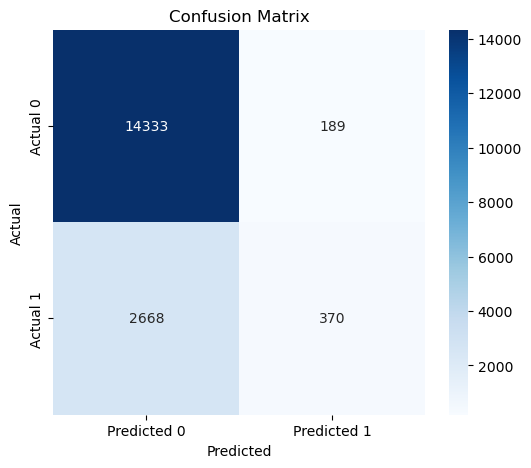

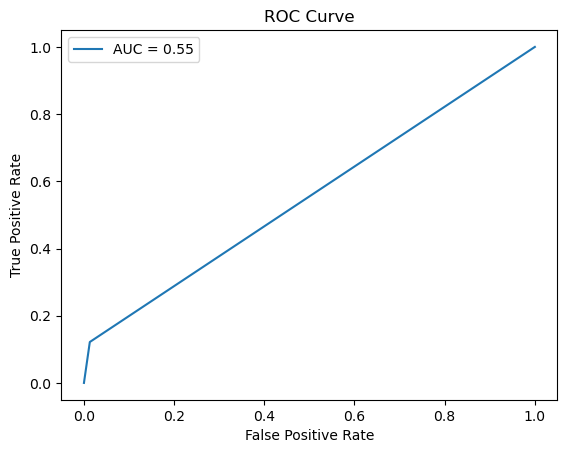

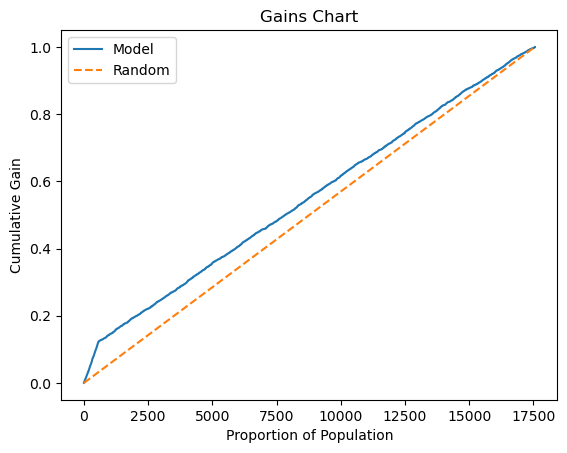

In [101]:
from sklearn.model_selection import TunedThresholdClassifierCV
tuned_model = TunedThresholdClassifierCV(
    estimator=qda_model,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)
print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")

print(
    "Benefit of tuned threshold: "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)
cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics("Discriminant QDA",cut_off_threshold,y_test,y_pred_proba)

In [102]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the LDA model
lda = LinearDiscriminantAnalysis()

# Define the parameter grid
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9],  # Shrinkage options (used with 'lsqr' and 'eigen')
    'n_components': [None, 1, 2]  # Number of components (useful for dimensionality reduction)
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=lda,
    param_grid=param_grid,
    scoring='accuracy',  # You can also use 'f1', 'roc_auc', etc.
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available processors
)

# Fit the model to the training data
grid_search.fit(X_train_processed, y_train)

# Print the best parameters and corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_lda = grid_search.best_estimator_
y_pred = best_lda.predict(X_test_processed)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
123 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dineshsaraswat/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dineshsaraswat/anaconda3/lib/python3.11/site-pack

Best Parameters: {'n_components': None, 'shrinkage': None, 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.8484701487424336
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     14522
           1       0.61      0.35      0.44      3038

    accuracy                           0.85     17560
   macro avg       0.74      0.65      0.68     17560
weighted avg       0.83      0.85      0.83     17560



Benefit - lda Discriminant Analysis hypertuned: 4,372.96$
Metric for model  Discriminant LDA Hypertunned
Cutoff Threshold is :  0.5
Accuracy of the Discriminant LDA Hypertunned based on the cut off probability of 0.5 is : 0.84874715261959
Sensitivity of the Discriminant LDA Hypertunned based on the cut off probability of 0.5 is: 0.34529295589203424
Precision of the Discriminant LDA Hypertunned based on the cut off probability of 0.5 is: 0.6113053613053613
F1 Value of the Discriminant LDA Hypertunned based on the cut off probability of 0.5 is: 0.4413125788809424
Specificity of the Discriminant LDA Hypertunned based on the cut off probability of 0.5 is: 0.9540696873708856


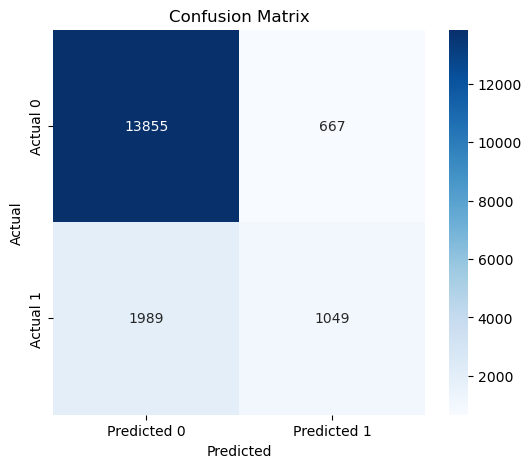

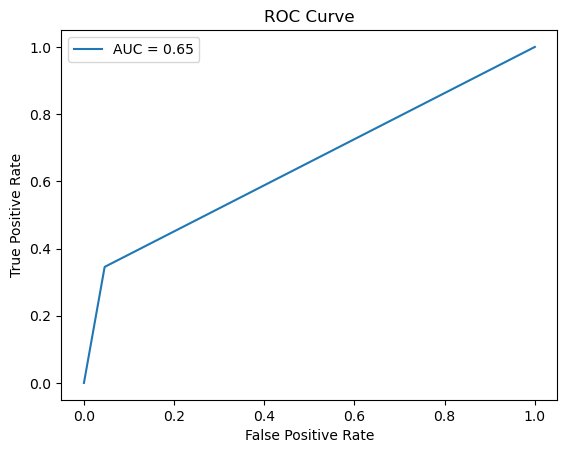

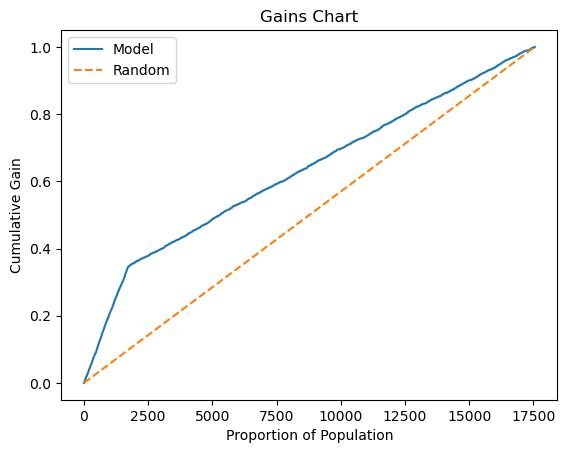

In [103]:
benefit = business_scorer(best_lda, X_test_processed, y_test, disbursement_gross=disbursement_gross_test)
print(f"Benefit - lda Discriminant Analysis hypertuned: {benefit:,.2f}$")
print_metrics("Discriminant LDA Hypertunned",0.5,y_test,y_pred_proba)

Tuned decision threshold: 0.15
Benefit of tuned threshold: 5,634.12
Metric for model  Discriminant LDA Hypertunned
Cutoff Threshold is :  0.15
Accuracy of the Discriminant LDA Hypertunned based on the cut off probability of 0.15 is : 0.775113895216401
Sensitivity of the Discriminant LDA Hypertunned based on the cut off probability of 0.15 is: 0.8225806451612904
Precision of the Discriminant LDA Hypertunned based on the cut off probability of 0.15 is: 0.4229141986799797
F1 Value of the Discriminant LDA Hypertunned based on the cut off probability of 0.15 is: 0.5586230021236168
Specificity of the Discriminant LDA Hypertunned based on the cut off probability of 0.15 is: 0.7651838589725933


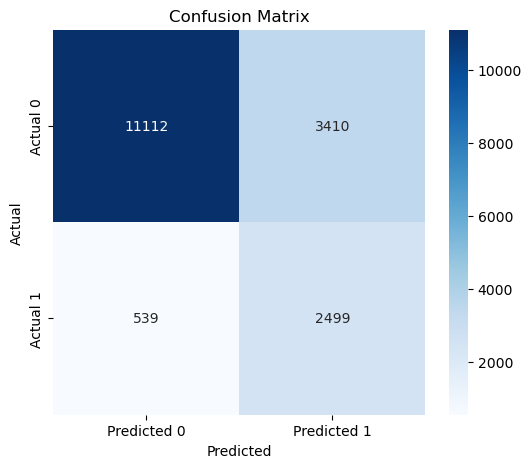

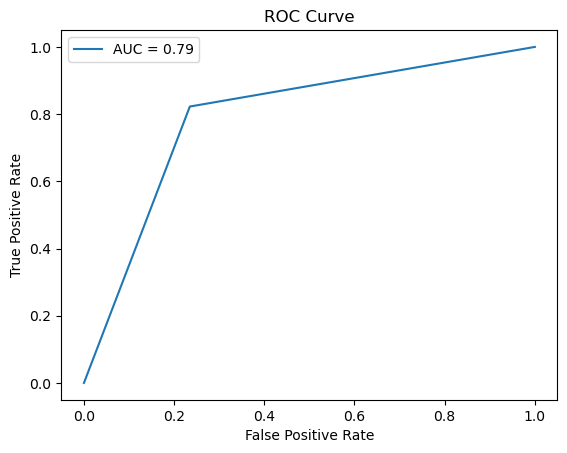

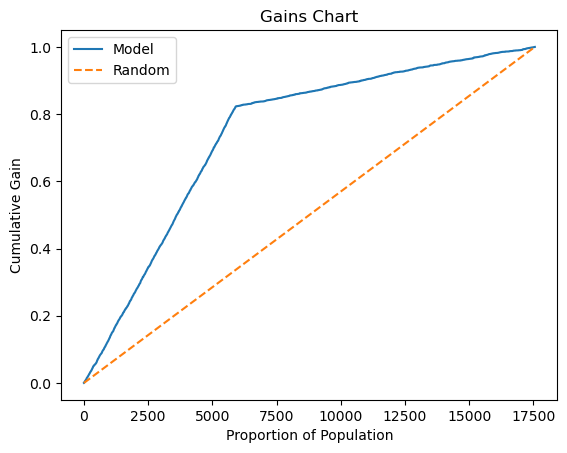

In [104]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_model = TunedThresholdClassifierCV(
    estimator=grid_search.best_estimator_,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_processed, y_train, disbursement_gross=disbursement_gross_train)
print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")

print(
    "Benefit of tuned threshold: "
    f"{business_scorer(tuned_model, X_test_processed, y_test, disbursement_gross=disbursement_gross_test):,.2f}"
)

cut_off_threshold = round(tuned_model.best_threshold_,2)
print_metrics("Discriminant LDA Hypertunned",cut_off_threshold,y_test,y_pred_proba)

# Observations and Summary

## 1. Quadratic Discriminant Analysis (QDA)
- **Overall Accuracy**: 44% — QDA performs poorly overall.
- **Classification Report**:
  - **Precision (Class 1)**: 0.23, **Recall (Class 1)**: 0.94 — High recall but low precision for class 1, resulting in many false positives.
  - **Specificity**: 95.41% — Strong performance for detecting class 0.
- **Threshold Tuning**: 
  - **Tuned Threshold 0.80** improves specificity but drastically reduces sensitivity (0.12) and F1-score (0.21).
  - **Benefit**: $4,046.78 at cutoff 0.5, and $4,688.05 at the tuned threshold.

## 2. Linear Discriminant Analysis (LDA)
- **Overall Accuracy**: 85% — LDA performs better than QDA.
- **Classification Report**:
  - **Precision (Class 1)**: 0.61, **Recall (Class 1)**: 0.35 — LDA struggles with class 1, especially recall.
  - **Specificity**: 95.41% — Strong performance for detecting class 0.
- **Threshold Tuning**: 
  - **Tuned Threshold 0.15**: Increases sensitivity (0.82) but reduces precision (0.42), leading to a balanced improvement in F1-score (0.56).
  - **Benefit**: $5,634.12 at tuned threshold.

## 3. Summary
- **QDA**: While it detects class 1 well (high recall), it suffers from poor precision and low overall accuracy, making it unsuitable for this dataset.
- **LDA**: Shows better performance overall but still has challenges with class 1. Threshold tuning improves the balance between precision and recall, yielding a higher benefit.
- **Best Performing Model**: **LDA (with tuned threshold)** for improved sensitivity and overall benefit.

## CATGBOOST as final Model

### Read the source cleaned data and make it run through the same changes and train on the final CATGBOOST model

In [105]:
category_cols = ['State','NewExist','UrbanRural','LowDoc_correct','RealEstate','recession',
                'If_Franchise','correct_RevLineCr','filled_industry','IndustryFlag'] # Drop this geo flag
numerical_cols = ['DisbursementGross','updated_term','SBA_portion','CompanySize','JOB_CREATED','DefaultRateBucket']
data[category_cols] = data[category_cols].astype('category')
#stratified_sample[numerical_cols] = stratified_sample[numerical_cols].astype('Float64')
data.dtypes

City                         object
State                      category
Zip                          object
Zip2                         string
BankState                    object
ApprovalDate         datetime64[ns]
ApprovalFY                    Int16
NoEmp                         int64
NewExist                   category
CreateJob                     int64
RetainedJob                   int64
UrbanRural                 category
ChgOffDate           datetime64[ns]
DisbursementDate     datetime64[ns]
DisbursementGross             Int64
BalanceGross                  Int64
MIS_Status                     Int8
ChgOffPrinGr                  Int64
GrAppv                        Int64
SBA_Appv                      Int64
econ_sector                  object
LowDoc_correct             category
updated_term                  int64
maturity_date        datetime64[ns]
maturity_year                 Int16
DisbursementYear              Int16
recession                  category
RealEstate                 c

In [106]:
# prompt: train test split
final_features_and_y = ['NewExist','UrbanRural','LowDoc_correct','RealEstate','recession','If_Franchise',
                        'correct_RevLineCr','DisbursementGross','updated_term',
                        'SBA_portion','CompanySize','JOB_CREATED','DefaultRateBucket','IndustryFlag','MIS_Status']
# Assuming 'loan' DataFrame is already prepared as shown in the provided code.
full_data = data[final_features_and_y].copy()

# Define features (X) and target variable (y)
X_full = full_data.drop(['MIS_Status'], axis=1)
X_full = X.fillna(0) 
y = loan['MIS_Status']


# Perform train-test split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the resulting datasets
print("X_train_full shape:", X_train_full.shape)
print("X_test_full shape:", X_test_full.shape)
print("y_train shape:", y_train_full.shape)
print("y_test shape:", y_test_full.shape)

cat_attrs = ['NewExist', 'UrbanRural' ]
lab_attrs = [ 'IndustryFlag', 'CompanySize', 'DefaultRateBucket']
log_attrs = ['updated_term', 'DisbursementGross']
quant_attrs = ['SBA_portion']
pass_attrs = ['recession', 'RealEstate', 'LowDoc_correct', 'correct_RevLineCr', 'If_Franchise', 'JOB_CREATED']

# prompt: create label encoding pipeline for lab_attrs.. not using pipeline

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for each categorical column
label_encoders = {}
for col in lab_attrs:
    le = LabelEncoder()
    label_encoders[col] = le

# Fit and transform the training data
for col in lab_attrs:
    X_train_full[col] = label_encoders[col].fit_transform(X_train_full[col])

# Transform the test data using the fitted LabelEncoders
for col in lab_attrs:
    X_test_full[col] = label_encoders[col].transform(X_test_full[col])
    
X_test_full.head()



X_train_full shape: (70237, 14)
X_test_full shape: (17560, 14)
y_train shape: (70237,)
y_test shape: (17560,)


NewExist UrbanRural LowDoc_correct RealEstate recession  \
LoanNr_ChkDgt                                                           
6528515008           2          1              0          0         0   
3097415006           1          1              1          0         1   
5412984006           2          1              1          0         0   
9441303002           1          0              1          0         0   
3830714010           2          1              0          0         0   

              If_Franchise correct_RevLineCr  DisbursementGross  updated_term  \
LoanNr_ChkDgt                                                                   
6528515008               1                 0             150000           120   
3097415006               0                 0              25000            51   
5412984006               0                 0              20000            21   
9441303002               0                 0             100000            84   
3830714010               0                 1             558000            71   

               SBA_portion  CompanySize  JOB_CREATED  DefaultRateBucket  \
LoanNr_ChkDgt                                                             
6528515008            85.0            2            1                  2   
3097415006            50.0            1            1                  3   
5412984006            85.0            1            0                  1   
9441303002            80.0            1            0                  0   
3830714010            50.0            1            0                  1   

               IndustryFlag  
LoanNr_ChkDgt                
6528515008                4  
3097415006                0  
5412984006                6  
9441303002                6  
3830714010                6

In [107]:


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  QuantileTransformer, PowerTransformer, OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer

quantile_pipeline = Pipeline([("quantile transformer", QuantileTransformer(n_quantiles=200))])
log_pipeline = Pipeline([("log transform", PowerTransformer(method = 'yeo-johnson')), ('standard scaler', StandardScaler())])
cat_pipeline = Pipeline([("one hot encoder", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ("quant", quantile_pipeline, quant_attrs),
    ("log", log_pipeline, log_attrs),
    ('cat', cat_pipeline, cat_attrs)],
     remainder='passthrough'
)

# Preprocess the numerical features of training and testing data
X_train_full_preprocessed = preprocessor.fit_transform(X_train_full)
X_test_full_preprocessed = preprocessor.transform(X_test_full)

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Rename columns in the DataFrames
X_train_full_final = pd.DataFrame(X_train_full_preprocessed, columns=feature_names)
X_test_full_final = pd.DataFrame(X_test_full_preprocessed, columns=feature_names)


disbursement_gross_test_full = X_test_full["DisbursementGross"]
disbursement_gross_train_full = X_train_full["DisbursementGross"]


In [110]:
X_test_full["DisbursementGross"]

LoanNr_ChkDgt
6528515008     150000
3097415006      25000
5412984006      20000
9441303002     100000
3830714010     558000
               ...   
5467404004    1267500
4576414001     100000
3108296010      29988
1895725000     173614
8688883009      40000
Name: DisbursementGross, Length: 17560, dtype: Int64

In [111]:
#baseline - Benefit of the 'always Approving' a loan: 
from sklearn.dummy import DummyClassifier

always_approve = DummyClassifier(strategy="constant", constant=0)
always_approve.fit(X_test_full_final, y_test_full)
benefit = business_scorer(
    always_approve, X_test_full_final, y_test_full, disbursement_gross=disbursement_gross_test_full
)
print(f"Benefit of 'always approving' loan: ${benefit:,.2f}")

Benefit of 'always approving' loan: $3,537.40


In [112]:
#baseline - Benefit of the 'always rejecting' a loan: 
from sklearn.dummy import DummyClassifier

always_approve = DummyClassifier(strategy="constant", constant=1)
always_approve.fit(X_test_full_final, y_test_full)
benefit = business_scorer(always_approve, X_test_full_final, y_test_full, disbursement_gross=disbursement_gross_test_full)

print(f"Benefit of 'always rejecting' loan: ${benefit:,.2f}")

Benefit of 'always rejecting' loan: $0.00


In [113]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

cat_model = CatBoostClassifier(
    iterations=500,               # Number of boosting iterations
    learning_rate=0.1,            # Learning rate
    depth=6,                      # Depth of each tree
    loss_function='Logloss',      # Binary classification loss
    eval_metric='AUC',            # Metric for evaluation
    random_seed=42,
    verbose=100,                  # Output training progress every 100 iterations
    class_weights=[1, 5],         # Class weights to handle imbalance
)

# Train the model
cat_model.fit(X_train_full_final, y_train_full, eval_set=(X_test_full_final, y_test_full), early_stopping_rounds=50)

# Predictions and probabilities
y_pred_proba_full = cat_model.predict_proba(X_test_full_final)[:, 1]  # Probability of class 1 (Default)
y_pred_full = cat_model.predict(X_test_full_final)

# Evaluate the model
roc_auc = roc_auc_score(y_test_full, y_pred_proba_full)
conf_matrix = confusion_matrix(y_test_full, y_pred_full)
classification_rep = classification_report(y_test_full, y_pred_full)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
print(f"Accuracy: {accuracy:.4f}")

0:	test: 0.9004956	best: 0.9004956 (0)	total: 13.3ms	remaining: 6.63s
100:	test: 0.9610157	best: 0.9610157 (100)	total: 1.02s	remaining: 4.05s
200:	test: 0.9679818	best: 0.9679818 (200)	total: 2.16s	remaining: 3.21s
300:	test: 0.9696000	best: 0.9696000 (300)	total: 3.28s	remaining: 2.17s
400:	test: 0.9704729	best: 0.9704729 (400)	total: 4.41s	remaining: 1.09s
499:	test: 0.9707338	best: 0.9707338 (499)	total: 5.51s	remaining: 0us

bestTest = 0.970733764
bestIteration = 499

ROC-AUC: 0.9707
Confusion Matrix:
[[13373  1149]
 [  251  2787]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     14522
         1.0       0.71      0.92      0.80      3038

    accuracy                           0.92     17560
   macro avg       0.84      0.92      0.87     17560
weighted avg       0.93      0.92      0.92     17560

Accuracy: 0.8916


In [119]:
print(
    "Business metric with default threshold: "
    f"{business_scorer(cat_model, X_test_full_final, y_test_full, disbursement_gross=disbursement_gross_test):,.2f}"
)
#print_metrics("CatGboost ",0.5,y_test_full,y_pred_proba_full)
tuned_model = TunedThresholdClassifierCV(
    estimator=cat_model,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)
tuned_model.fit(X_train_full_final, y_train_full, disbursement_gross=disbursement_gross_train_full)


print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")
print(
    "Business metric with tuned threshold: "
    f"{business_scorer(tuned_model, X_test_full_final, y_test_full, disbursement_gross=disbursement_gross_test_full):,.2f}"
)
cut_off_threshold = round(tuned_model.best_threshold_,2)
#print_metrics("CatGBoost ",cut_off_threshold,y_test_full,y_pred_proba_full)

Business metric with default threshold: 7,571.41
0:	total: 8.65ms	remaining: 4.31s
100:	total: 926ms	remaining: 3.66s
200:	total: 2s	remaining: 2.98s
300:	total: 3.05s	remaining: 2.01s
400:	total: 4.11s	remaining: 1.01s
499:	total: 5.13s	remaining: 0us
Tuned decision threshold: 0.44
Business metric with tuned threshold: 7,586.61


Optimal cutoff probability: 0.4056351052389176
Maximum cumulative profit: 134036359.15000018
Optimal number of loans: 13256


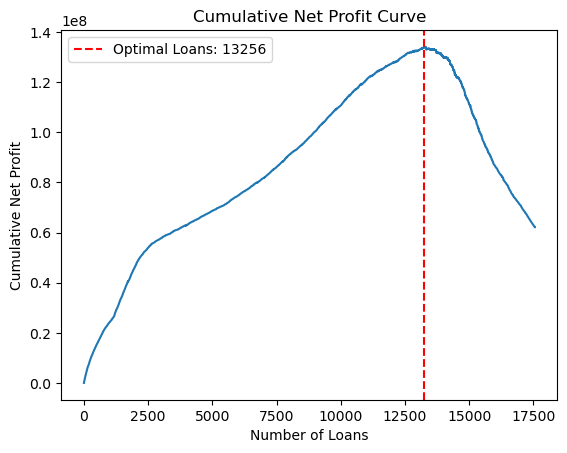

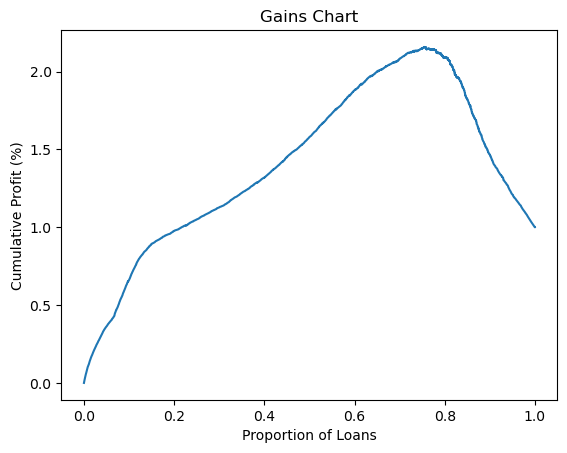

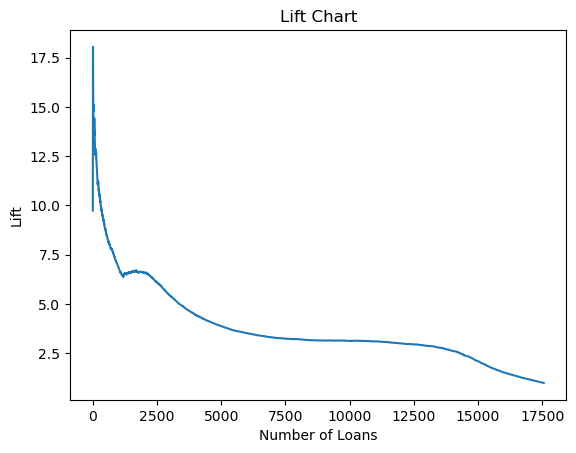

In [133]:
#Gettting predicted probabilities from the model
pd.set_option('display.float_format', '{:.6f}'.format)
X_test_full['probability'] = cat_model.predict_proba(X_test_full_final)[:, 1]

#Calculating profit or loss based on the DisbursementGross
X_test_full['net_profit'] = np.where(
    y_test_full == 0,  # No default
    0.05 * X_test_full['DisbursementGross'],  # Profit
    -5 * (0.05 * X_test_full['DisbursementGross'])  # Loss
)
#Sorting data by predicted probability of default
sorted_data = X_test_full.sort_values(by='probability')

#Calculating cumulative net profit
sorted_data['cumulative_profit'] = sorted_data['net_profit'].cumsum()
#sorted_data
#Resetting index to add a default numeric index
sorted_data = sorted_data.reset_index()  # Loan ID becomes a column, default numeric index is added
sorted_data['cumulative_profit'] = pd.to_numeric(sorted_data['cumulative_profit'], errors='coerce')
max_profit_idx = sorted_data['cumulative_profit'].idxmax() 
optimal_cutoff = sorted_data.loc[max_profit_idx, 'probability']  # Probability at max profit
max_profit = sorted_data.loc[max_profit_idx, 'cumulative_profit']  # Max cumulative profit

# Optimal number of loans is directly the position (1-based)
optimal_num_loans = max_profit_idx + 1

print(f"Optimal cutoff probability: {optimal_cutoff}")
print(f"Maximum cumulative profit: {max_profit}")
print(f"Optimal number of loans: {optimal_num_loans}")

#Cumulative profit curve
plt.plot(sorted_data.index, sorted_data['cumulative_profit'])
plt.axvline(max_profit_idx, color='red', linestyle='--', label=f'Optimal Loans: {optimal_num_loans}')
plt.xlabel('Number of Loans')
plt.ylabel('Cumulative Net Profit')
plt.title('Cumulative Net Profit Curve')
plt.legend()
plt.show()

#Gains Chart
sorted_data['cumulative_profit_percent'] = (
    sorted_data['cumulative_profit'] / sorted_data['cumulative_profit'].iloc[-1]
)
plt.plot(
    np.arange(len(sorted_data)) / len(sorted_data), 
    sorted_data['cumulative_profit_percent']
)
plt.xlabel('Proportion of Loans')
plt.ylabel('Cumulative Profit (%)')
plt.title('Gains Chart')
plt.show()

#Lift Chart
random_gain = sorted_data['net_profit'].mean() * np.arange(1, len(sorted_data) + 1)
lift = sorted_data['cumulative_profit'] / random_gain
plt.plot(np.arange(len(sorted_data)), lift)
plt.xlabel('Number of Loans')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.show()

1. **Algorithm**: Catboost model ( train and test split - 70/30 ratio)
    
**Performance Metrics:**
    
Accuracy: 89.16%
Precision: 98% for non-default loans (class 0) and 71% for default loans (class 1).
Recall: 92% for both non-default and default loans.
F1-Score:
0.95 for non-default loans.
0.80 for default loans.

he model achieves a high recall for default loans (92%), critical for minimizing financial losses due to loan 
defaults.High precision for non-default loans (98%) ensures most approved loans generate profit.

**Business Metric Evaluation**

1. Threshold (Tuned): 0.44.
2. This threshold was determined to maximize business profit based on cumulative net profit.
3. Default Threshold Profit: 7,571.41 dollars.
4. Tuned Threshold Profit: 7,586.61 dollars.

Optimizing the threshold from the default value significantly improved business profit, demonstrating the 
importance of tailoring thresholds to business objectives.

**Profit Optimization**

1. Maximum Cumulative Profit: $134,036,359.15.
2. Optimal Cutoff Probability: 0.4056.
3. Optimal Number of Loans: 13,256.
    
These loans, selected using the tuned cutoff probability, balance the trade-off between granting loans 
to non-default borrowers and denying loans to potential defaulters.